In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import SelectFromModel
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# read in relevant dataset

df_01 = pd.read_csv("df_modelling_std_01_labels.csv").drop(columns=["Unnamed: 0"])

In [3]:
# list out unique feature values for gentrifying labels (GEN_Class3)

df_01["GEN_Class3"].unique()

array(['NON-GEN', 'SupGen', 'MargGen', 'MainGen'], dtype=object)

In [4]:
# extract only gentrifying LSOAs

df_01 = df_01[df_01["GEN_Class3"] != "NON-GEN"]

In [5]:
# groupby typology and tabulate

df_01.groupby("GEN_Class3").size()

GEN_Class3
MainGen     42
MargGen     52
SupGen     156
dtype: int64

In [6]:
# drop cluster unnecessary feature columns for this stage

df_01 = df_01.drop(columns=["LSOA11CD","Class_2_status","Class_3_status","GEN_Class2"])

In [7]:
# split the dataframe into 2 - (1) input data to be crunched and (2) labels for verfication

df_01_data = df_01.drop(["GEN_Class3"],axis=1)
df_01_labels = df_01[["GEN_Class3"]]

In [8]:
# split the data into training and test sets

x_train, x_test, y_train, y_test = train_test_split(df_01_data, df_01_labels, test_size=0.3, stratify=df_01_labels, random_state=42)

## Building the Baseline Algorithms

### 1) Balanced Random Forest Classifier

In [9]:
# initialise model

brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

In [10]:
# parameter space for checking by GridSearchCV

param_grid_brf = { 
    'n_estimators': range(50, 301, 50),
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

In [11]:
# search for optimal hyperparameters

CV_brf = GridSearchCV(estimator=brf, param_grid=param_grid_brf, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
CV_brf.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\base.py", line 42, in _validate_params
    valida

GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(class_weight='balanced',
                                                      n_jobs=-1,
                                                      random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(50, 301, 50)},
             scoring='f1_weighted', verbose=3)

In [12]:
# extract optimal hyperparameters

CV_brf.best_params_

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}

In [13]:
# do a finer-grained search for optimal hyperparameters within a narrowed down parameter space derived above

param_grid_brf2 = { 
    'n_estimators': range(210, 291, 10),
    'max_features': ['log2'],
    'criterion' :['entropy']
}

In [14]:
# search for optimal hyperparameters

CV_brf2 = GridSearchCV(estimator=brf, param_grid=param_grid_brf2, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
CV_brf2.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warni

GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(class_weight='balanced',
                                                      n_jobs=-1,
                                                      random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_features': ['log2'],
                         'n_estimators': range(210, 291, 10)},
             scoring='f1_weighted', verbose=3)

In [15]:
# extract best parameters

CV_brf2.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 210}

In [16]:
# model based on best paramters

brf2=BalancedRandomForestClassifier(random_state=42, max_features='log2', n_estimators= 230, criterion='entropy', n_jobs=-1, verbose=3, class_weight="balanced")

In [17]:
# evaluate the model's performance

scores = cross_val_score(brf2, x_train, y_train.values.ravel(), cv=5, scoring = 'f1_weighted')
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
brf2 = brf2.fit(x_train, y_train.values.ravel())
y_pred = brf2.predict(x_test)
f1 = f1_score(y_test, y_pred, average="weighted")
print ('Wighted F1 score on Test set:', f1)

C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warni

mean validation - F1 Weighted score: F1 score: 0.75 (+/- 0.12)
building tree 1 of 230
building tree 2 of 230
building tree 6 of 230
building tree 5 of 230
building tree 7 of 230
building tree 9 of 230
building tree 3 of 230
building tree 11 of 230
building tree 10 of 230
building tree 8 of 230
building tree 14 of 230
building tree 12 of 230
building tree 16 of 230
building tree 4 of 230
building tree 15 of 230
building tree 18 of 230
building tree 17 of 230
building tree 13 of 230
building tree 21 of 230
building tree 19 of 230
building tree 20 of 230
building tree 24 of 230
building tree 23 of 230
building tree 25 of 230
building tree 27 of 230
building tree 28 of 230
building tree 29 of 230
building tree 31 of 230
building tree 22 of 230
building tree 33 of 230
building tree 35 of 230
building tree 32 of 230
building tree 34 of 230
building tree 26 of 230


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 30 of 230
building tree 38 of 230
building tree 36 of 230
building tree 37 of 230
building tree 42 of 230
building tree 44 of 230
building tree 39 of 230
building tree 41 of 230
building tree 40 of 230
building tree 43 of 230
building tree 45 of 230
building tree 47 of 230
building tree 48 of 230
building tree 52 of 230
building tree 46 of 230
building tree 51 of 230
building tree 49 of 230
building tree 53 of 230
building tree 50 of 230
building tree 54 of 230
building tree 55 of 230
building tree 56 of 230
building tree 57 of 230
building tree 60 of 230
building tree 58 of 230
building tree 62 of 230
building tree 65 of 230
building tree 63 of 230
building tree 61 of 230
building tree 67 of 230
building tree 59 of 230
building tree 64 of 230
building tree 68 of 230
building tree 70 of 230
building tree 66 of 230
building tree 69 of 230
building tree 73 of 230
building tree 74 of 230
building tree 72 of 230
building tree 76 of 230
building tree 71 of 230
building tree 77

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 118 of 230
building tree 121 of 230
building tree 120 of 230
building tree 122 of 230
building tree 119 of 230
building tree 124 of 230
building tree 126 of 230
building tree 123 of 230
building tree 125 of 230
building tree 128 of 230
building tree 129 of 230
building tree 131 of 230
building tree 130 of 230
building tree 127 of 230
building tree 135 of 230
building tree 132 of 230
building tree 133 of 230
building tree 137 of 230
building tree 136 of 230
building tree 134 of 230
building tree 138 of 230
building tree 141 of 230
building tree 140 of 230
building tree 143 of 230
building tree 139 of 230
building tree 142 of 230
building tree 144 of 230
building tree 145 of 230
building tree 148 of 230
building tree 151 of 230
building tree 150 of 230
building tree 153 of 230
building tree 146 of 230
building tree 152 of 230
building tree 149 of 230
building tree 147 of 230
building tree 155 of 230
building tree 156 of 230
building tree 159 of 230
building tree 158 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished


In [18]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(y_test.values.ravel(),y_pred)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.6880966042156114


In [19]:
# visualise results using a simple confusion matrix

unique_label = np.unique(y_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:MainGen  pred:MargGen  pred:SupGen
true:MainGen            12             0            0
true:MargGen             2             7            7
true:SupGen              2            10           35


<Axes: title={'center': 'Non-normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

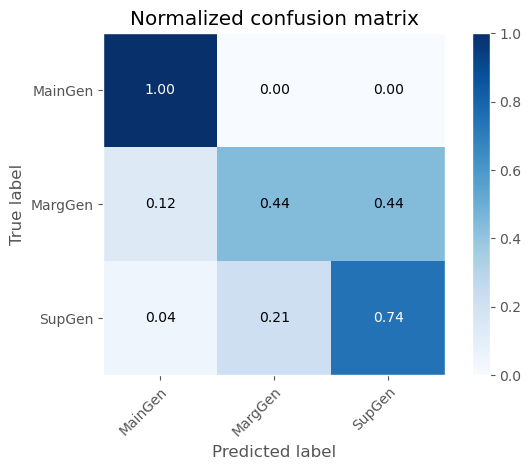

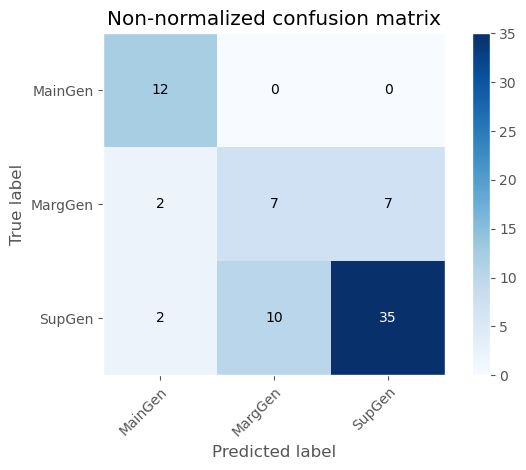

In [20]:
# plot a better visualisation using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=["MainGen","MargGen","SupGen"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=["MainGen","MargGen","SupGen"], normalize=False,
                      title='Non-normalized confusion matrix')

## 2) Balanced Adaboost Classifier

In [23]:
# initialise model

ada=RUSBoostClassifier(random_state=42)

In [24]:
# parameter space for checking by GridSearchCV

param_grid_ada = { 
    'n_estimators': range(50, 301, 50),
    'learning_rate':[.001,0.01,.1]
}

In [25]:
# search for optimal hyperparameters

CV_ada = GridSearchCV(estimator=ada, param_grid=param_grid_ada, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
CV_ada.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RUSBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': range(50, 301, 50)},
             scoring='f1_weighted', verbose=3)

In [26]:
# extract optimal hyperparameters

CV_ada.best_params_

{'learning_rate': 0.1, 'n_estimators': 150}

In [27]:
# do a finer-grained search for optimal hyperparameters within a narrowed down parameter space derived above

param_grid_ada2 = { 
    'n_estimators': range(60, 140, 10),
    'learning_rate':[0.1]
}

In [28]:
# search for optimal hyperparameters

CV_ada2 = GridSearchCV(estimator=ada, param_grid=param_grid_ada2, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
CV_ada2.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RUSBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1],
                         'n_estimators': range(60, 140, 10)},
             scoring='f1_weighted', verbose=3)

In [29]:
# extract optimal hyperparameters

CV_ada2.best_params_

{'learning_rate': 0.1, 'n_estimators': 130}

In [30]:
# model based on best paramters

ada2=RUSBoostClassifier(random_state=42,learning_rate= 0.1, n_estimators= 90)

In [31]:
# evaluate model's performance

scores = cross_val_score(ada2, x_train, y_train.values.ravel(), cv=5, scoring = 'f1_weighted',n_jobs=-1)
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
ada2 = ada2.fit(x_train, y_train.values.ravel())
y_pred_1 = ada2.predict(x_test)
f1 = f1_score(y_test, y_pred_1, average="weighted")
print ('Wighted F1 score on Test set:', f1)

mean validation - F1 Weighted score: F1 score: 0.79 (+/- 0.17)
Wighted F1 score on Test set: 0.7163391781948483


In [32]:
print('The geometric mean of Balanced Adaboost classifier on the test set is {}'.format(geometric_mean_score(y_test.values.ravel(),y_pred_1)))

The geometric mean of Balanced Adaboost classifier on the test set is 0.6194544872883991


In [33]:
# visualise results using a simple confusion matrix

unique_label = np.unique(y_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred_1, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:MainGen  pred:MargGen  pred:SupGen
true:MainGen            11             0            1
true:MargGen             1             5           10
true:SupGen              3             5           39


<Axes: title={'center': 'Non-normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

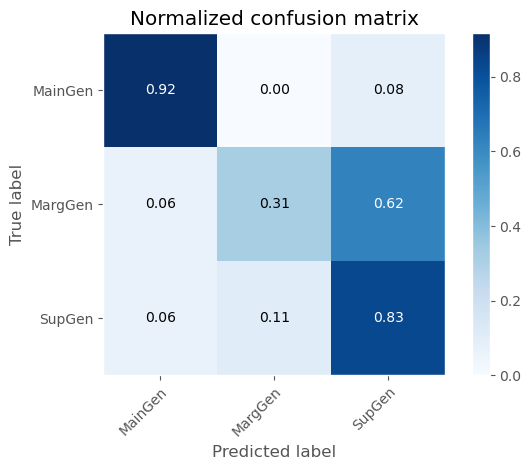

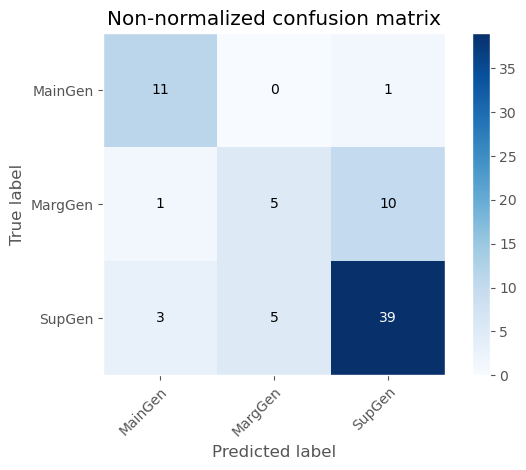

In [34]:
# plot a better visualisation using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_1, classes=["MainGen","MargGen","SupGen"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_1, classes=["MainGen","MargGen","SupGen"], normalize=False,
                      title='Non-normalized confusion matrix')

## Extract Feature Importance from the Model

In [21]:
# extract feature importance

feature_importance = pd.DataFrame(brf2.feature_importances_,index=df_01_data.columns).reset_index()

In [22]:
feature_importance.head()

,index,0
0,Pop_size,0.006464
1,avg_pop_churn,0.013682
2,age_0_4,0.005496
3,age_5_9,0.001249
4,age_10_14,0.004698


In [23]:
# rename dataframe

feature_importance=feature_importance.rename(columns={"index":"Variable", 0:"var_impt"})

In [24]:
feature_importance.sort_values(by = "var_impt", ascending=False)

,Variable,var_impt
82,median_income,0.035473
98,NS-SEC_6,0.033112
83,Managers_directors_senior_occup,0.028301
29,1-family_lone_depKids,0.025689
93,NS-SEC_1,0.025317
...,...,...
46,Christian,0.001612
59,4_more_carsVans,0.001561
17,age_75_79,0.001433
18,age_80_84,0.001423


In [39]:
# checkpoint - output file

impt_features_modelling2 = pd.DataFrame(feature_importance.sort_values(by = "var_impt", ascending=False).iloc[0:128,0])
impt_features_modelling2 .to_csv("impt_features_modelling2.csv")

In [40]:
# read in file with the variable codes and categories

var_code = pd.read_csv("variable_codes.csv")

In [41]:
var_code.head()

,Variable,Category,Code
0,avg_pop_churn,Pop. Churn,1
1,Pop_size,Pop. & Demographics,2
2,age_0_4,Pop. & Demographics,2
3,age_5_9,Pop. & Demographics,2
4,age_10_14,Pop. & Demographics,2


In [42]:
# merge these datasets

feature_importance = feature_importance.merge(var_code, left_on="Variable", right_on="Variable")

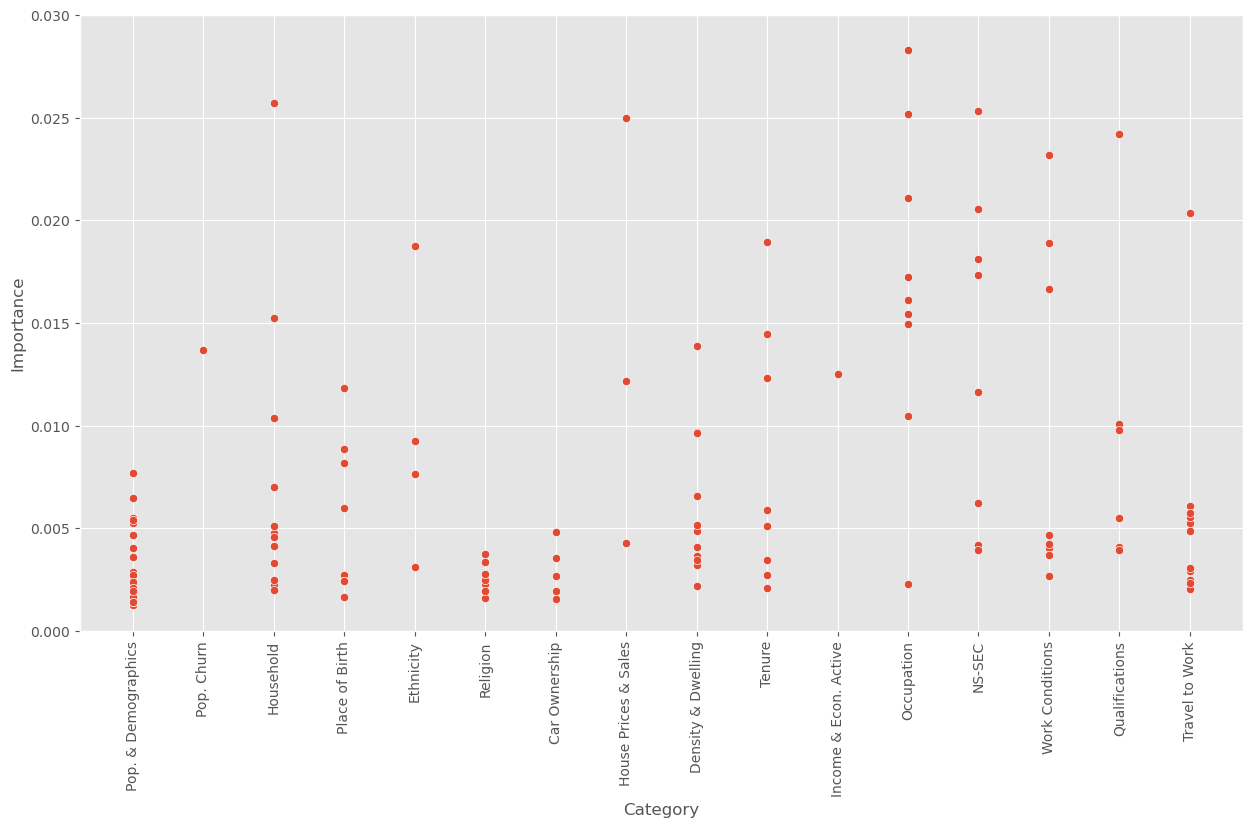

In [44]:
# visualise the most important variables

plt.figure(figsize=(15,8))
plt.ylim(0, 0.03)
plt.xticks(rotation=90)

ax = sns.scatterplot(x="Category", y="var_impt", data=feature_importance)
ax.set(ylabel='Importance')

plt.savefig('GEN feature`.png', dpi = 100)
# uncomment for loop below to annotate the chart
# for line in range(0,feature_importance.shape[0]):
#     ax.text(feature_importance.Category[line], feature_importance.var_impt[line], feature_importance.Variable[line], horizontalalignment='left', size='small', color='black')

## Feature Engineering - Variable Pruning

In [45]:
# test to establish the optimal quantum of least important variables to be removed

f1_array = []
geo_mean_array=[]
no_to_drop = range(1,65)

for i in range(len(no_to_drop)):
    to_drop = feature_importance.sort_values(by = "var_impt", ascending=False)[-no_to_drop[i]:len(feature_importance)]
    to_drop_list = to_drop.reset_index().iloc[:,1]
    
    df_01_data_dropped = df_01_data[:]
    df_01_data_dropped = df_01_data_dropped.drop(columns=to_drop_list)
    x_train_dropped, x_test_dropped, y_train, y_test = train_test_split(df_01_data_dropped, df_01_labels, stratify=df_01_labels, test_size=0.3, random_state=42)
    brf2 = brf2.fit(x_train_dropped, y_train.values.ravel())
    y_pred = brf2.predict(x_test_dropped)
    f1 = f1_score(y_test, y_pred, average="weighted")
    f1_array.append(f1)
    geo_mean = geometric_mean_score(y_test.values.ravel(),y_pred)
    geo_mean_array.append(geo_mean)

C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warni

building tree 1 of 230
building tree 2 of 230
building tree 4 of 230
building tree 3 of 230
building tree 6 of 230
building tree 9 of 230
building tree 8 of 230
building tree 5 of 230
building tree 11 of 230
building tree 7 of 230
building tree 12 of 230
building tree 13 of 230
building tree 14 of 230
building tree 10 of 230
building tree 15 of 230
building tree 16 of 230
building tree 18 of 230
building tree 17 of 230
building tree 22 of 230
building tree 19 of 230
building tree 20 of 230
building tree 21 of 230
building tree 24 of 230
building tree 25 of 230
building tree 23 of 230
building tree 26 of 230
building tree 28 of 230
building tree 31 of 230
building tree 29 of 230
building tree 27 of 230
building tree 30 of 230
building tree 33 of 230
building tree 36 of 230
building tree 32 of 230
building tree 37 of 230
building tree 35 of 230
building tree 40 of 230
building tree 41 of 230
building tree 34 of 230
building tree 39 of 230
building tree 42 of 230
building tree 44 of 230
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 185 of 230
building tree 188 of 230
building tree 190 of 230
building tree 189 of 230
building tree 193 of 230
building tree 192 of 230
building tree 196 of 230
building tree 194 of 230
building tree 191 of 230
building tree 201 of 230
building tree 199 of 230
building tree 198 of 230
building tree 197 of 230
building tree 195 of 230
building tree 200 of 230
building tree 205 of 230
building tree 204 of 230
building tree 203 of 230
building tree 202 of 230
building tree 209 of 230
building tree 208 of 230
building tree 207 of 230
building tree 206 of 230
building tree 210 of 230
building tree 211 of 230
building tree 216 of 230
building tree 217 of 230
building tree 218 of 230
building tree 212 of 230
building tree 215 of 230
building tree 213 of 230
building tree 214 of 230
building tree 219 of 230
building tree 221 of 230
building tree 222 of 230
building tree 225 of 230
building tree 220 of 230
building tree 224 of 230
building tree 226 of 230
building tree 229 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 4 of 230
building tree 2 of 230
building tree 6 of 230
building tree 3 of 230
building tree 9 of 230
building tree 5 of 230
building tree 7 of 230
building tree 8 of 230
building tree 13 of 230
building tree 10 of 230
building tree 16 of 230
building tree 12 of 230
building tree 11 of 230
building tree 15 of 230
building tree 17 of 230
building tree 18 of 230
building tree 14 of 230
building tree 20 of 230
building tree 23 of 230
building tree 21 of 230
building tree 22 of 230
building tree 19 of 230
building tree 24 of 230
building tree 25 of 230
building tree 30 of 230
building tree 29 of 230
building tree 27 of 230
building tree 26 of 230
building tree 28 of 230
building tree 34 of 230
building tree 31 of 230
building tree 33 of 230
building tree 36 of 230
building tree 35 of 230
building tree 32 of 230
building tree 37 of 230
building tree 39 of 230
building tree 42 of 230
building tree 40 of 230
building tree 38 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 91 of 230
building tree 97 of 230
building tree 93 of 230
building tree 90 of 230
building tree 92 of 230
building tree 94 of 230
building tree 98 of 230
building tree 95 of 230
building tree 100 of 230
building tree 99 of 230
building tree 101 of 230
building tree 102 of 230
building tree 96 of 230
building tree 103 of 230
building tree 105 of 230
building tree 109 of 230
building tree 108 of 230
building tree 104 of 230
building tree 111 of 230
building tree 107 of 230
building tree 106 of 230
building tree 110 of 230
building tree 113 of 230
building tree 112 of 230
building tree 116 of 230
building tree 115 of 230
building tree 118 of 230
building tree 117 of 230
building tree 119 of 230
building tree 114 of 230
building tree 121 of 230
building tree 125 of 230
building tree 120 of 230
building tree 127 of 230
building tree 126 of 230
building tree 122 of 230
building tree 123 of 230
building tree 128 of 230
building tree 124 of 230
building tree 131 of 230
building t

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 180 of 230
building tree 179 of 230
building tree 178 of 230
building tree 176 of 230
building tree 182 of 230
building tree 184 of 230
building tree 185 of 230
building tree 189 of 230
building tree 186 of 230
building tree 187 of 230
building tree 188 of 230
building tree 191 of 230
building tree 190 of 230
building tree 194 of 230
building tree 197 of 230
building tree 192 of 230
building tree 195 of 230
building tree 198 of 230
building tree 193 of 230
building tree 200 of 230
building tree 199 of 230
building tree 201 of 230
building tree 203 of 230
building tree 202 of 230
building tree 196 of 230
building tree 205 of 230
building tree 204 of 230
building tree 206 of 230
building tree 207 of 230
building tree 209 of 230
building tree 213 of 230
building tree 214 of 230
building tree 212 of 230
building tree 210 of 230
building tree 208 of 230
building tree 215 of 230
building tree 216 of 230
building tree 211 of 230
building tree 217 of 230
building tree 219 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 2 of 230
building tree 9 of 230
building tree 8 of 230
building tree 5 of 230
building tree 4 of 230
building tree 6 of 230
building tree 10 of 230
building tree 7 of 230
building tree 11 of 230
building tree 14 of 230
building tree 16 of 230
building tree 15 of 230
building tree 17 of 230
building tree 18 of 230
building tree 19 of 230
building tree 12 of 230
building tree 22 of 230
building tree 20 of 230
building tree 13 of 230
building tree 23 of 230
building tree 21 of 230
building tree 25 of 230
building tree 24 of 230
building tree 27 of 230
building tree 28 of 230
building tree 31 of 230
building tree 26 of 230
building tree 30 of 230
building tree 29 of 230
building tree 32 of 230
building tree 34 of 230
building tree 37 of 230
building tree 33 of 230
building tree 39 of 230
building tree 40 of 230
building tree 36 of 230
building tree 38 of 230
building tree 35 of 230
building tree 41 of 230
building tree 45 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 96 of 230
building tree 94 of 230
building tree 89 of 230
building tree 98 of 230
building tree 100 of 230
building tree 99 of 230
building tree 95 of 230
building tree 97 of 230
building tree 104 of 230
building tree 102 of 230
building tree 101 of 230
building tree 103 of 230
building tree 111 of 230
building tree 107 of 230
building tree 108 of 230
building tree 105 of 230
building tree 106 of 230
building tree 112 of 230
building tree 109 of 230
building tree 114 of 230
building tree 110 of 230
building tree 116 of 230
building tree 113 of 230
building tree 119 of 230
building tree 115 of 230
building tree 120 of 230
building tree 121 of 230
building tree 122 of 230
building tree 118 of 230
building tree 123 of 230
building tree 124 of 230
building tree 126 of 230
building tree 117 of 230
building tree 128 of 230
building tree 125 of 230
building tree 127 of 230
building tree 130 of 230
building tree 129 of 230
building tree 132 of 230
building tree 131 of 230
buildin

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 5 of 230
building tree 7 of 230
building tree 6 of 230
building tree 8 of 230
building tree 9 of 230
building tree 10 of 230
building tree 14 of 230
building tree 11 of 230
building tree 15 of 230
building tree 16 of 230
building tree 13 of 230
building tree 12 of 230
building tree 17 of 230
building tree 18 of 230
building tree 23 of 230
building tree 19 of 230
building tree 21 of 230
building tree 25 of 230
building tree 24 of 230
building tree 22 of 230
building tree 20 of 230
building tree 27 of 230
building tree 29 of 230
building tree 26 of 230
building tree 30 of 230
building tree 32 of 230
building tree 33 of 230
building tree 28 of 230
building tree 34 of 230
building tree 31 of 230
building tree 37 of 230
building tree 35 of 230
building tree 36 of 230
building tree 40 of 230
building tree 38 of 230
building tree 39 of 230
building tree 41 of 230
building tree 42 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 96 of 230
building tree 95 of 230
building tree 101 of 230
building tree 98 of 230
building tree 97 of 230
building tree 100 of 230
building tree 99 of 230
building tree 103 of 230
building tree 102 of 230
building tree 104 of 230
building tree 109 of 230
building tree 106 of 230
building tree 108 of 230
building tree 105 of 230
building tree 110 of 230
building tree 115 of 230
building tree 111 of 230
building tree 113 of 230
building tree 107 of 230
building tree 118 of 230
building tree 116 of 230
building tree 114 of 230
building tree 112 of 230
building tree 117 of 230
building tree 119 of 230
building tree 121 of 230
building tree 120 of 230
building tree 124 of 230
building tree 123 of 230
building tree 122 of 230
building tree 128 of 230
building tree 127 of 230
building tree 125 of 230
building tree 131 of 230
building tree 126 of 230
building tree 129 of 230
building tree 130 of 230
building tree 134 of 230
building tree 136 of 230
building tree 137 of 230
build

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 201 of 230
building tree 203 of 230
building tree 206 of 230
building tree 200 of 230
building tree 202 of 230
building tree 209 of 230
building tree 208 of 230
building tree 210 of 230
building tree 211 of 230
building tree 207 of 230
building tree 212 of 230
building tree 216 of 230
building tree 214 of 230
building tree 213 of 230
building tree 217 of 230
building tree 215 of 230
building tree 220 of 230
building tree 222 of 230
building tree 221 of 230
building tree 219 of 230
building tree 218 of 230
building tree 225 of 230
building tree 226 of 230
building tree 224 of 230
building tree 229 of 230
building tree 223 of 230
building tree 227 of 230
building tree 228 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 1 of 230
building tree 5 of 230
building tree 9 of 230
building tree 8 of 230
building tree 7 of 230
building tree 6 of 230
building tree 13 of 230
building tree 14 of 230
building tree 15 of 230
building tree 16 of 230
building tree 11 of 230
building tree 10 of 230
building tree 12 of 230
building tree 17 of 230
building tree 19 of 230
building tree 18 of 230
building tree 25 of 230
building tree 20 of 230
building tree 21 of 230
building tree 23 of 230
building tree 22 of 230
building tree 24 of 230
building tree 26 of 230
building tree 29 of 230
building tree 27 of 230
building tree 28 of 230
building tree 32 of 230
building tree 30 of 230
building tree 31 of 230
building tree 34 of 230
building tree 35 of 230
building tree 38 of 230
building tree 33 of 230
building tree 37 of 230
building tree 39 of 230
building tree 36 of 230
building tree 41 of 230
building tree 42 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 90 of 230
building tree 92 of 230
building tree 87 of 230
building tree 89 of 230
building tree 96 of 230
building tree 93 of 230
building tree 95 of 230
building tree 94 of 230
building tree 99 of 230
building tree 97 of 230
building tree 100 of 230
building tree 102 of 230
building tree 98 of 230
building tree 103 of 230
building tree 101 of 230
building tree 104 of 230
building tree 105 of 230
building tree 106 of 230
building tree 108 of 230
building tree 107 of 230
building tree 113 of 230
building tree 111 of 230
building tree 112 of 230
building tree 115 of 230
building tree 109 of 230
building tree 114 of 230
building tree 116 of 230
building tree 110 of 230
building tree 117 of 230
building tree 120 of 230
building tree 121 of 230
building tree 118 of 230
building tree 122 of 230
building tree 119 of 230
building tree 127 of 230
building tree 129 of 230
building tree 123 of 230
building tree 124 of 230
building tree 128 of 230
building tree 126 of 230
building tr

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 4 of 230
building tree 2 of 230
building tree 5 of 230
building tree 3 of 230
building tree 6 of 230
building tree 7 of 230
building tree 10 of 230
building tree 11 of 230
building tree 8 of 230
building tree 9 of 230
building tree 12 of 230
building tree 13 of 230
building tree 14 of 230
building tree 15 of 230
building tree 17 of 230
building tree 20 of 230
building tree 18 of 230
building tree 21 of 230
building tree 19 of 230
building tree 22 of 230
building tree 23 of 230
building tree 16 of 230
building tree 25 of 230
building tree 26 of 230
building tree 24 of 230
building tree 29 of 230
building tree 27 of 230
building tree 28 of 230
building tree 32 of 230
building tree 31 of 230
building tree 34 of 230
building tree 30 of 230
building tree 35 of 230
building tree 39 of 230
building tree 36 of 230
building tree 37 of 230
building tree 38 of 230
building tree 41 of 230
building tree 33 of 230
building tree 42 of 230
building tree 40 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 97 of 230
building tree 102 of 230
building tree 101 of 230
building tree 103 of 230
building tree 100 of 230
building tree 99 of 230
building tree 104 of 230
building tree 105 of 230
building tree 98 of 230
building tree 108 of 230
building tree 110 of 230
building tree 107 of 230
building tree 114 of 230
building tree 106 of 230
building tree 113 of 230
building tree 111 of 230
building tree 112 of 230
building tree 116 of 230
building tree 115 of 230
building tree 117 of 230
building tree 109 of 230
building tree 119 of 230
building tree 121 of 230
building tree 118 of 230
building tree 120 of 230
building tree 124 of 230
building tree 122 of 230
building tree 125 of 230
building tree 123 of 230
building tree 129 of 230
building tree 128 of 230
building tree 131 of 230
building tree 126 of 230
building tree 127 of 230
building tree 130 of 230
building tree 133 of 230
building tree 132 of 230
building tree 134 of 230
building tree 135 of 230
building tree 137 of 230
bui

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 4 of 230
building tree 5 of 230
building tree 6 of 230
building tree 1 of 230
building tree 7 of 230
building tree 3 of 230
building tree 11 of 230
building tree 10 of 230
building tree 8 of 230
building tree 9 of 230
building tree 2 of 230
building tree 12 of 230
building tree 14 of 230
building tree 15 of 230
building tree 13 of 230
building tree 20 of 230
building tree 18 of 230
building tree 16 of 230
building tree 21 of 230
building tree 19 of 230
building tree 17 of 230
building tree 23 of 230
building tree 22 of 230
building tree 28 of 230
building tree 26 of 230
building tree 25 of 230
building tree 29 of 230
building tree 24 of 230
building tree 27 of 230
building tree 30 of 230
building tree 32 of 230
building tree 35 of 230
building tree 31 of 230
building tree 36 of 230
building tree 34 of 230
building tree 39 of 230
building tree 33 of 230
building tree 37 of 230
building tree 41 of 230
building tree 42 of 230
building tree 38 of 230
building tree 40 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 96 of 230
building tree 93 of 230
building tree 98 of 230
building tree 99 of 230
building tree 94 of 230
building tree 101 of 230
building tree 95 of 230
building tree 100 of 230
building tree 102 of 230
building tree 104 of 230
building tree 107 of 230
building tree 103 of 230
building tree 105 of 230
building tree 110 of 230
building tree 109 of 230
building tree 108 of 230
building tree 106 of 230
building tree 111 of 230
building tree 115 of 230
building tree 112 of 230
building tree 114 of 230
building tree 113 of 230
building tree 117 of 230
building tree 118 of 230
building tree 120 of 230
building tree 119 of 230
building tree 116 of 230
building tree 121 of 230
building tree 122 of 230
building tree 123 of 230
building tree 125 of 230
building tree 127 of 230
building tree 124 of 230
building tree 126 of 230
building tree 131 of 230
building tree 132 of 230
building tree 129 of 230
building tree 133 of 230
building tree 128 of 230
building tree 136 of 230
buildi

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 8 of 230
building tree 3 of 230
building tree 7 of 230
building tree 5 of 230
building tree 9 of 230
building tree 4 of 230
building tree 6 of 230
building tree 10 of 230
building tree 15 of 230
building tree 12 of 230
building tree 17 of 230
building tree 18 of 230
building tree 14 of 230
building tree 13 of 230
building tree 16 of 230
building tree 11 of 230
building tree 19 of 230
building tree 21 of 230
building tree 24 of 230
building tree 22 of 230
building tree 25 of 230
building tree 27 of 230
building tree 26 of 230
building tree 20 of 230
building tree 29 of 230
building tree 28 of 230
building tree 23 of 230
building tree 30 of 230
building tree 31 of 230
building tree 32 of 230
building tree 33 of 230
building tree 35 of 230
building tree 34 of 230
building tree 37 of 230
building tree 39 of 230
building tree 38 of 230
building tree 36 of 230
building tree 40 of 230
building tree 43 of 230
building tree 41 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 98 of 230
building tree 99 of 230
building tree 101 of 230
building tree 97 of 230
building tree 96 of 230
building tree 102 of 230
building tree 103 of 230
building tree 104 of 230
building tree 100 of 230
building tree 105 of 230
building tree 106 of 230
building tree 108 of 230
building tree 109 of 230
building tree 107 of 230
building tree 110 of 230
building tree 113 of 230
building tree 114 of 230
building tree 111 of 230
building tree 115 of 230
building tree 116 of 230
building tree 112 of 230
building tree 117 of 230
building tree 120 of 230
building tree 118 of 230
building tree 121 of 230
building tree 122 of 230
building tree 119 of 230
building tree 126 of 230
building tree 127 of 230
building tree 124 of 230
building tree 125 of 230
building tree 130 of 230
building tree 123 of 230
building tree 128 of 230
building tree 132 of 230
building tree 131 of 230
building tree 133 of 230
building tree 135 of 230
building tree 134 of 230
building tree 129 of 230
buil

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 203 of 230
building tree 197 of 230
building tree 201 of 230
building tree 200 of 230
building tree 202 of 230
building tree 207 of 230
building tree 206 of 230
building tree 208 of 230
building tree 204 of 230
building tree 210 of 230
building tree 212 of 230
building tree 209 of 230
building tree 211 of 230
building tree 215 of 230
building tree 218 of 230
building tree 213 of 230
building tree 217 of 230
building tree 219 of 230
building tree 205 of 230
building tree 214 of 230
building tree 221 of 230
building tree 216 of 230
building tree 220 of 230
building tree 223 of 230
building tree 222 of 230
building tree 224 of 230
building tree 226 of 230
building tree 228 of 230
building tree 227 of 230
building tree 229 of 230
building tree 225 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 4 of 230
building tree 2 of 230
building tree 10 of 230
building tree 5 of 230
building tree 7 of 230
building tree 6 of 230
building tree 8 of 230
building tree 14 of 230
building tree 13 of 230
building tree 17 of 230
building tree 9 of 230
building tree 11 of 230
building tree 15 of 230
building tree 12 of 230
building tree 16 of 230
building tree 20 of 230
building tree 18 of 230
building tree 22 of 230
building tree 19 of 230
building tree 23 of 230
building tree 24 of 230
building tree 25 of 230
building tree 28 of 230
building tree 27 of 230
building tree 26 of 230
building tree 30 of 230
building tree 21 of 230
building tree 32 of 230
building tree 29 of 230
building tree 35 of 230
building tree 37 of 230
building tree 36 of 230
building tree 34 of 230
building tree 33 of 230
building tree 31 of 230
building tree 41 of 230
building tree 38 of 230
building tree 44 of 230
building tree 40 of 230
building tree 42 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 96 of 230
building tree 99 of 230
building tree 97 of 230
building tree 93 of 230
building tree 100 of 230
building tree 101 of 230
building tree 98 of 230
building tree 104 of 230
building tree 102 of 230
building tree 103 of 230
building tree 108 of 230
building tree 106 of 230
building tree 107 of 230
building tree 105 of 230
building tree 113 of 230
building tree 110 of 230
building tree 109 of 230
building tree 116 of 230
building tree 112 of 230
building tree 115 of 230
building tree 114 of 230
building tree 111 of 230
building tree 118 of 230
building tree 117 of 230
building tree 120 of 230
building tree 123 of 230
building tree 121 of 230
building tree 122 of 230
building tree 119 of 230
building tree 127 of 230
building tree 124 of 230
building tree 126 of 230
building tree 125 of 230
building tree 130 of 230
building tree 131 of 230
building tree 128 of 230
building tree 134 of 230
building tree 133 of 230
building tree 136 of 230
building tree 129 of 230
build

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 192 of 230
building tree 193 of 230
building tree 196 of 230
building tree 197 of 230
building tree 194 of 230
building tree 199 of 230
building tree 198 of 230
building tree 195 of 230
building tree 202 of 230
building tree 200 of 230
building tree 201 of 230
building tree 203 of 230
building tree 204 of 230
building tree 209 of 230
building tree 208 of 230
building tree 206 of 230
building tree 205 of 230
building tree 211 of 230
building tree 212 of 230
building tree 207 of 230
building tree 210 of 230
building tree 214 of 230
building tree 215 of 230
building tree 217 of 230
building tree 218 of 230
building tree 220 of 230
building tree 216 of 230
building tree 221 of 230
building tree 213 of 230
building tree 219 of 230
building tree 223 of 230
building tree 224 of 230
building tree 222 of 230
building tree 225 of 230
building tree 228 of 230
building tree 227 of 230
building tree 226 of 230
building tree 229 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 6 of 230
building tree 2 of 230
building tree 4 of 230
building tree 9 of 230
building tree 5 of 230
building tree 3 of 230
building tree 7 of 230
building tree 12 of 230
building tree 10 of 230
building tree 8 of 230
building tree 13 of 230
building tree 16 of 230
building tree 14 of 230
building tree 11 of 230
building tree 17 of 230
building tree 15 of 230
building tree 20 of 230
building tree 18 of 230
building tree 21 of 230
building tree 19 of 230
building tree 23 of 230
building tree 28 of 230
building tree 22 of 230
building tree 25 of 230
building tree 24 of 230
building tree 26 of 230
building tree 30 of 230
building tree 32 of 230
building tree 27 of 230
building tree 33 of 230
building tree 34 of 230
building tree 29 of 230
building tree 35 of 230
building tree 36 of 230
building tree 31 of 230
building tree 37 of 230
building tree 40 of 230
building tree 39 of 230
building tree 38 of 230
building tree 44 of 230
building tree 41 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 94 of 230
building tree 96 of 230
building tree 98 of 230
building tree 93 of 230
building tree 95 of 230
building tree 97 of 230
building tree 100 of 230
building tree 101 of 230
building tree 102 of 230
building tree 99 of 230
building tree 103 of 230
building tree 106 of 230
building tree 107 of 230
building tree 105 of 230
building tree 111 of 230
building tree 109 of 230
building tree 110 of 230
building tree 104 of 230
building tree 113 of 230
building tree 112 of 230
building tree 114 of 230
building tree 116 of 230
building tree 119 of 230
building tree 115 of 230
building tree 108 of 230
building tree 118 of 230
building tree 117 of 230
building tree 121 of 230
building tree 120 of 230
building tree 125 of 230
building tree 127 of 230
building tree 122 of 230
building tree 126 of 230
building tree 123 of 230
building tree 128 of 230
building tree 124 of 230
building tree 130 of 230
building tree 132 of 230
building tree 137 of 230
building tree 129 of 230
buildin

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 195 of 230building tree 198 of 230

building tree 201 of 230
building tree 202 of 230
building tree 199 of 230
building tree 200 of 230
building tree 203 of 230
building tree 205 of 230
building tree 204 of 230
building tree 207 of 230
building tree 211 of 230
building tree 206 of 230
building tree 210 of 230
building tree 209 of 230
building tree 208 of 230
building tree 213 of 230
building tree 214 of 230
building tree 218 of 230
building tree 217 of 230
building tree 215 of 230
building tree 219 of 230
building tree 216 of 230
building tree 220 of 230
building tree 212 of 230
building tree 222 of 230
building tree 223 of 230
building tree 226 of 230
building tree 225 of 230
building tree 221 of 230
building tree 224 of 230
building tree 228 of 230
building tree 227 of 230
building tree 229 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 6 of 230
building tree 4 of 230
building tree 5 of 230
building tree 10 of 230
building tree 12 of 230
building tree 7 of 230
building tree 9 of 230
building tree 8 of 230
building tree 11 of 230
building tree 16 of 230
building tree 14 of 230
building tree 15 of 230
building tree 13 of 230
building tree 18 of 230
building tree 23 of 230
building tree 20 of 230
building tree 19 of 230
building tree 21 of 230
building tree 22 of 230
building tree 17 of 230
building tree 24 of 230
building tree 26 of 230
building tree 29 of 230
building tree 30 of 230
building tree 28 of 230
building tree 31 of 230
building tree 25 of 230
building tree 32 of 230
building tree 27 of 230
building tree 34 of 230
building tree 35 of 230
building tree 33 of 230
building tree 36 of 230
building tree 38 of 230
building tree 40 of 230
building tree 37 of 230
building tree 39 of 230
building tree 43 of 230
building tree 41 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 93 of 230
building tree 96 of 230
building tree 100 of 230
building tree 99 of 230
building tree 98 of 230
building tree 103 of 230
building tree 102 of 230
building tree 104 of 230
building tree 101 of 230
building tree 107 of 230
building tree 108 of 230
building tree 109 of 230
building tree 105 of 230
building tree 111 of 230
building tree 112 of 230
building tree 106 of 230
building tree 113 of 230
building tree 115 of 230
building tree 110 of 230
building tree 114 of 230
building tree 117 of 230
building tree 116 of 230
building tree 120 of 230
building tree 119 of 230
building tree 118 of 230
building tree 126 of 230
building tree 122 of 230
building tree 121 of 230
building tree 124 of 230
building tree 127 of 230
building tree 123 of 230
building tree 125 of 230
building tree 130 of 230
building tree 129 of 230
building tree 133 of 230
building tree 134 of 230
building tree 132 of 230
building tree 135 of 230
building tree 131 of 230
building tree 137 of 230
buil

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 194 of 230
building tree 188 of 230
building tree 196 of 230
building tree 198 of 230
building tree 197 of 230
building tree 195 of 230
building tree 192 of 230
building tree 199 of 230
building tree 200 of 230
building tree 202 of 230
building tree 205 of 230
building tree 203 of 230
building tree 201 of 230
building tree 204 of 230
building tree 210 of 230
building tree 206 of 230
building tree 209 of 230
building tree 212 of 230
building tree 207 of 230
building tree 208 of 230
building tree 211 of 230
building tree 213 of 230
building tree 215 of 230
building tree 216 of 230
building tree 217 of 230
building tree 214 of 230
building tree 219 of 230
building tree 220 of 230
building tree 218 of 230
building tree 221 of 230
building tree 222 of 230
building tree 223 of 230
building tree 225 of 230
building tree 226 of 230
building tree 228 of 230
building tree 227 of 230
building tree 230 of 230
building tree 229 of 230
building tree 224 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 4 of 230
building tree 2 of 230
building tree 6 of 230
building tree 3 of 230
building tree 5 of 230
building tree 7 of 230
building tree 11 of 230
building tree 10 of 230
building tree 8 of 230
building tree 9 of 230
building tree 12 of 230
building tree 14 of 230
building tree 15 of 230
building tree 18 of 230
building tree 13 of 230
building tree 16 of 230
building tree 17 of 230
building tree 19 of 230
building tree 22 of 230
building tree 21 of 230
building tree 20 of 230
building tree 23 of 230
building tree 25 of 230
building tree 24 of 230
building tree 29 of 230
building tree 26 of 230
building tree 33 of 230
building tree 32 of 230
building tree 28 of 230
building tree 27 of 230
building tree 30 of 230
building tree 31 of 230
building tree 37 of 230
building tree 38 of 230
building tree 35 of 230
building tree 39 of 230
building tree 34 of 230
building tree 43 of 230
building tree 40 of 230
building tree 42 of 230
building tree 36 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 108 of 230
building tree 99 of 230
building tree 106 of 230
building tree 110 of 230
building tree 111 of 230
building tree 112 of 230
building tree 109 of 230
building tree 113 of 230
building tree 116 of 230
building tree 115 of 230
building tree 114 of 230
building tree 117 of 230
building tree 118 of 230
building tree 120 of 230
building tree 121 of 230
building tree 119 of 230
building tree 122 of 230
building tree 123 of 230
building tree 125 of 230
building tree 127 of 230
building tree 129 of 230
building tree 124 of 230
building tree 126 of 230
building tree 128 of 230
building tree 132 of 230
building tree 131 of 230
building tree 130 of 230
building tree 138 of 230
building tree 137 of 230
building tree 133 of 230
building tree 136 of 230
building tree 135 of 230
building tree 134 of 230
building tree 139 of 230
building tree 141 of 230
building tree 144 of 230
building tree 142 of 230
building tree 140 of 230
building tree 147 of 230
building tree 146 of 230
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 200 of 230
building tree 198 of 230
building tree 204 of 230
building tree 203 of 230
building tree 208 of 230
building tree 205 of 230
building tree 202 of 230
building tree 209 of 230
building tree 194 of 230
building tree 206 of 230
building tree 210 of 230
building tree 213 of 230
building tree 211 of 230
building tree 212 of 230
building tree 207 of 230
building tree 215 of 230
building tree 218 of 230
building tree 216 of 230
building tree 219 of 230
building tree 222 of 230
building tree 220 of 230
building tree 221 of 230
building tree 214 of 230
building tree 224 of 230
building tree 217 of 230
building tree 225 of 230
building tree 228 of 230
building tree 223 of 230
building tree 227 of 230
building tree 229 of 230
building tree 230 of 230
building tree 226 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 2 of 230
building tree 6 of 230
building tree 10 of 230
building tree 8 of 230
building tree 9 of 230
building tree 7 of 230
building tree 4 of 230
building tree 14 of 230
building tree 13 of 230
building tree 11 of 230
building tree 15 of 230
building tree 5 of 230
building tree 12 of 230
building tree 17 of 230
building tree 20 of 230
building tree 18 of 230
building tree 16 of 230
building tree 21 of 230
building tree 19 of 230
building tree 23 of 230
building tree 24 of 230
building tree 22 of 230
building tree 25 of 230
building tree 26 of 230
building tree 31 of 230
building tree 33 of 230
building tree 29 of 230
building tree 28 of 230
building tree 32 of 230
building tree 27 of 230
building tree 30 of 230
building tree 34 of 230
building tree 35 of 230
building tree 36 of 230
building tree 37 of 230
building tree 39 of 230
building tree 40 of 230
building tree 42 of 230
building tree 38 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 97 of 230
building tree 95 of 230
building tree 101 of 230
building tree 100 of 230
building tree 99 of 230
building tree 108 of 230
building tree 103 of 230
building tree 102 of 230
building tree 107 of 230
building tree 105 of 230
building tree 106 of 230
building tree 109 of 230
building tree 104 of 230
building tree 111 of 230
building tree 110 of 230
building tree 112 of 230
building tree 115 of 230
building tree 117 of 230
building tree 113 of 230
building tree 118 of 230
building tree 116 of 230
building tree 122 of 230
building tree 119 of 230
building tree 121 of 230
building tree 114 of 230
building tree 124 of 230
building tree 123 of 230
building tree 126 of 230
building tree 125 of 230
building tree 120 of 230
building tree 127 of 230
building tree 130 of 230
building tree 129 of 230
building tree 128 of 230
building tree 133 of 230
building tree 136 of 230
building tree 135 of 230
building tree 134 of 230
building tree 132 of 230
building tree 140 of 230
bui

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 185 of 230
building tree 191 of 230
building tree 192 of 230
building tree 193 of 230
building tree 184 of 230
building tree 194 of 230
building tree 197 of 230
building tree 195 of 230
building tree 199 of 230
building tree 196 of 230
building tree 198 of 230
building tree 201 of 230
building tree 200 of 230
building tree 203 of 230
building tree 202 of 230
building tree 204 of 230
building tree 207 of 230
building tree 206 of 230
building tree 212 of 230
building tree 205 of 230
building tree 208 of 230
building tree 210 of 230
building tree 213 of 230
building tree 209 of 230
building tree 211 of 230
building tree 219 of 230
building tree 215 of 230
building tree 214 of 230
building tree 216 of 230
building tree 220 of 230
building tree 218 of 230
building tree 222 of 230
building tree 224 of 230
building tree 221 of 230
building tree 217 of 230
building tree 225 of 230
building tree 223 of 230
building tree 226 of 230
building tree 228 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 8 of 230
building tree 4 of 230
building tree 3 of 230
building tree 9 of 230
building tree 5 of 230
building tree 2 of 230
building tree 11 of 230
building tree 7 of 230
building tree 10 of 230
building tree 13 of 230
building tree 12 of 230
building tree 14 of 230
building tree 18 of 230
building tree 15 of 230
building tree 6 of 230
building tree 20 of 230
building tree 19 of 230
building tree 17 of 230
building tree 22 of 230
building tree 21 of 230
building tree 16 of 230
building tree 24 of 230
building tree 23 of 230
building tree 27 of 230
building tree 26 of 230
building tree 28 of 230
building tree 29 of 230
building tree 25 of 230
building tree 30 of 230
building tree 32 of 230
building tree 33 of 230
building tree 35 of 230
building tree 31 of 230
building tree 38 of 230
building tree 34 of 230
building tree 36 of 230
building tree 37 of 230
building tree 39 of 230
building tree 43 of 230
building tree 42 of 230
building tree 40 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 100 of 230
building tree 99 of 230
building tree 103 of 230
building tree 105 of 230
building tree 104 of 230
building tree 102 of 230
building tree 101 of 230
building tree 107 of 230
building tree 109 of 230
building tree 108 of 230
building tree 110 of 230
building tree 114 of 230
building tree 115 of 230
building tree 113 of 230
building tree 106 of 230
building tree 112 of 230
building tree 116 of 230
building tree 117 of 230
building tree 111 of 230
building tree 120 of 230
building tree 118 of 230
building tree 119 of 230
building tree 122 of 230
building tree 121 of 230
building tree 124 of 230
building tree 125 of 230
building tree 123 of 230
building tree 126 of 230
building tree 127 of 230
building tree 129 of 230
building tree 132 of 230
building tree 135 of 230
building tree 133 of 230
building tree 128 of 230
building tree 130 of 230
building tree 136 of 230
building tree 134 of 230
building tree 131 of 230
building tree 138 of 230
building tree 137 of 230
b

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 2 of 230building tree 4 of 230
building tree 5 of 230

building tree 3 of 230
building tree 1 of 230
building tree 7 of 230
building tree 9 of 230
building tree 6 of 230
building tree 12 of 230
building tree 11 of 230
building tree 8 of 230
building tree 13 of 230
building tree 15 of 230
building tree 16 of 230
building tree 17 of 230
building tree 10 of 230
building tree 14 of 230
building tree 18 of 230
building tree 21 of 230
building tree 19 of 230
building tree 23 of 230
building tree 20 of 230
building tree 22 of 230
building tree 25 of 230
building tree 27 of 230
building tree 29 of 230
building tree 31 of 230
building tree 24 of 230
building tree 28 of 230
building tree 30 of 230
building tree 26 of 230
building tree 32 of 230
building tree 35 of 230
building tree 36 of 230
building tree 33 of 230
building tree 34 of 230
building tree 38 of 230
building tree 39 of 230
building tree 41 of 230
building tree 43 of 230
building tree 40 of 230
building tree 37 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 99 of 230
building tree 94 of 230
building tree 101 of 230
building tree 106 of 230
building tree 100 of 230
building tree 97 of 230
building tree 105 of 230
building tree 102 of 230
building tree 108 of 230
building tree 103 of 230
building tree 107 of 230
building tree 112 of 230
building tree 104 of 230
building tree 110 of 230
building tree 114 of 230
building tree 113 of 230
building tree 116 of 230
building tree 115 of 230
building tree 109 of 230
building tree 118 of 230
building tree 117 of 230
building tree 111 of 230
building tree 121 of 230
building tree 123 of 230
building tree 120 of 230
building tree 122 of 230
building tree 119 of 230
building tree 125 of 230
building tree 126 of 230
building tree 124 of 230
building tree 128 of 230
building tree 127 of 230
building tree 129 of 230
building tree 132 of 230
building tree 131 of 230
building tree 134 of 230
building tree 136 of 230
building tree 135 of 230
building tree 130 of 230
building tree 133 of 230
bui

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 4 of 230
building tree 3 of 230
building tree 9 of 230
building tree 7 of 230
building tree 2 of 230
building tree 8 of 230
building tree 1 of 230
building tree 6 of 230
building tree 5 of 230
building tree 11 of 230
building tree 10 of 230
building tree 13 of 230
building tree 12 of 230
building tree 14 of 230
building tree 15 of 230
building tree 16 of 230
building tree 17 of 230
building tree 20 of 230
building tree 19 of 230
building tree 18 of 230
building tree 23 of 230
building tree 22 of 230
building tree 21 of 230
building tree 26 of 230
building tree 25 of 230
building tree 24 of 230
building tree 28 of 230
building tree 27 of 230
building tree 29 of 230
building tree 31 of 230
building tree 32 of 230
building tree 36 of 230
building tree 30 of 230
building tree 33 of 230
building tree 35 of 230
building tree 34 of 230
building tree 38 of 230
building tree 37 of 230
building tree 40 of 230
building tree 44 of 230
building tree 39 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 103 of 230
building tree 104 of 230
building tree 110 of 230
building tree 107 of 230
building tree 106 of 230
building tree 105 of 230
building tree 112 of 230
building tree 111 of 230
building tree 109 of 230
building tree 108 of 230
building tree 113 of 230
building tree 114 of 230
building tree 117 of 230
building tree 115 of 230
building tree 118 of 230
building tree 116 of 230
building tree 120 of 230
building tree 119 of 230
building tree 121 of 230
building tree 122 of 230
building tree 124 of 230
building tree 125 of 230
building tree 126 of 230
building tree 123 of 230
building tree 128 of 230
building tree 127 of 230
building tree 132 of 230
building tree 131 of 230
building tree 130 of 230
building tree 129 of 230
building tree 133 of 230
building tree 136 of 230
building tree 134 of 230
building tree 137 of 230
building tree 138 of 230
building tree 141 of 230
building tree 135 of 230
building tree 140 of 230
building tree 142 of 230
building tree 143 of 230


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 204 of 230
building tree 205 of 230
building tree 207 of 230
building tree 208 of 230
building tree 209 of 230
building tree 206 of 230
building tree 213 of 230
building tree 211 of 230
building tree 210 of 230
building tree 214 of 230
building tree 212 of 230
building tree 217 of 230
building tree 215 of 230
building tree 216 of 230
building tree 219 of 230
building tree 220 of 230
building tree 218 of 230
building tree 221 of 230
building tree 222 of 230
building tree 224 of 230
building tree 225 of 230
building tree 223 of 230
building tree 226 of 230
building tree 227 of 230
building tree 229 of 230
building tree 230 of 230
building tree 228 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 4 of 230
building tree 6 of 230
building tree 2 of 230
building tree 5 of 230
building tree 10 of 230
building tree 7 of 230
building tree 11 of 230
building tree 8 of 230
building tree 9 of 230
building tree 12 of 230
building tree 14 of 230
building tree 13 of 230
building tree 15 of 230
building tree 18 of 230
building tree 17 of 230
building tree 20 of 230
building tree 21 of 230
building tree 19 of 230
building tree 22 of 230
building tree 16 of 230
building tree 24 of 230
building tree 23 of 230
building tree 28 of 230
building tree 26 of 230
building tree 25 of 230
building tree 27 of 230
building tree 33 of 230
building tree 30 of 230
building tree 31 of 230
building tree 29 of 230
building tree 32 of 230
building tree 35 of 230
building tree 36 of 230
building tree 37 of 230
building tree 38 of 230
building tree 42 of 230
building tree 34 of 230
building tree 39 of 230
building tree 41 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 89 of 230
building tree 90 of 230
building tree 96 of 230
building tree 94 of 230
building tree 93 of 230
building tree 97 of 230
building tree 98 of 230
building tree 95 of 230
building tree 101 of 230
building tree 102 of 230
building tree 99 of 230
building tree 100 of 230
building tree 103 of 230
building tree 105 of 230
building tree 104 of 230
building tree 106 of 230
building tree 107 of 230
building tree 109 of 230
building tree 110 of 230
building tree 113 of 230
building tree 111 of 230
building tree 112 of 230
building tree 108 of 230
building tree 114 of 230
building tree 117 of 230
building tree 115 of 230
building tree 119 of 230
building tree 120 of 230
building tree 122 of 230
building tree 118 of 230
building tree 123 of 230
building tree 116 of 230
building tree 121 of 230
building tree 126 of 230
building tree 125 of 230
building tree 127 of 230
building tree 131 of 230
building tree 128 of 230
building tree 130 of 230
building tree 124 of 230
building 

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 4 of 230
building tree 2 of 230
building tree 6 of 230
building tree 10 of 230
building tree 9 of 230
building tree 8 of 230
building tree 11 of 230
building tree 7 of 230
building tree 5 of 230
building tree 16 of 230
building tree 13 of 230
building tree 15 of 230
building tree 19 of 230
building tree 14 of 230
building tree 17 of 230
building tree 12 of 230
building tree 21 of 230
building tree 22 of 230
building tree 18 of 230
building tree 20 of 230
building tree 27 of 230
building tree 28 of 230
building tree 25 of 230
building tree 26 of 230
building tree 23 of 230
building tree 24 of 230
building tree 30 of 230
building tree 29 of 230
building tree 31 of 230
building tree 32 of 230
building tree 33 of 230
building tree 34 of 230
building tree 35 of 230
building tree 36 of 230
building tree 39 of 230
building tree 38 of 230
building tree 37 of 230
building tree 42 of 230
building tree 43 of 230
building tree 41 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 102 of 230
building tree 101 of 230
building tree 100 of 230
building tree 105 of 230
building tree 104 of 230
building tree 103 of 230
building tree 108 of 230
building tree 106 of 230
building tree 107 of 230
building tree 111 of 230
building tree 112 of 230
building tree 113 of 230
building tree 109 of 230
building tree 115 of 230
building tree 116 of 230
building tree 114 of 230
building tree 110 of 230
building tree 118 of 230
building tree 117 of 230
building tree 123 of 230
building tree 121 of 230
building tree 119 of 230
building tree 122 of 230
building tree 125 of 230
building tree 120 of 230
building tree 124 of 230
building tree 127 of 230
building tree 126 of 230
building tree 133 of 230
building tree 132 of 230
building tree 128 of 230
building tree 134 of 230
building tree 131 of 230
building tree 129 of 230
building tree 130 of 230
building tree 136 of 230
building tree 135 of 230
building tree 141 of 230
building tree 138 of 230
building tree 137 of 230


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 195 of 230
building tree 197 of 230
building tree 199 of 230
building tree 200 of 230
building tree 201 of 230
building tree 205 of 230
building tree 203 of 230
building tree 209 of 230
building tree 206 of 230
building tree 204 of 230
building tree 208 of 230
building tree 202 of 230
building tree 207 of 230
building tree 210 of 230
building tree 213 of 230
building tree 211 of 230
building tree 212 of 230
building tree 216 of 230
building tree 214 of 230
building tree 215 of 230
building tree 218 of 230
building tree 217 of 230
building tree 219 of 230
building tree 223 of 230
building tree 221 of 230
building tree 220 of 230
building tree 222 of 230
building tree 224 of 230
building tree 226 of 230
building tree 227 of 230
building tree 228 of 230
building tree 229 of 230
building tree 225 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 6 of 230
building tree 4 of 230
building tree 8 of 230
building tree 5 of 230
building tree 3 of 230
building tree 9 of 230
building tree 7 of 230
building tree 10 of 230
building tree 11 of 230
building tree 2 of 230
building tree 15 of 230
building tree 13 of 230
building tree 16 of 230
building tree 17 of 230
building tree 12 of 230
building tree 14 of 230
building tree 19 of 230
building tree 20 of 230
building tree 18 of 230
building tree 24 of 230
building tree 25 of 230
building tree 21 of 230
building tree 22 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 30 of 230
building tree 31 of 230
building tree 34 of 230
building tree 32 of 230
building tree 33 of 230
building tree 23 of 230
building tree 35 of 230
building tree 36 of 230
building tree 38 of 230
building tree 29 of 230
building tree 39 of 230
building tree 40 of 230
building tree 37 of 230
building tree 43 of 230
building tree 45 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 98 of 230
building tree 95 of 230
building tree 100 of 230
building tree 99 of 230
building tree 92 of 230
building tree 101 of 230
building tree 102 of 230
building tree 96 of 230
building tree 103 of 230
building tree 107 of 230
building tree 105 of 230
building tree 108 of 230
building tree 106 of 230
building tree 110 of 230
building tree 104 of 230
building tree 114 of 230
building tree 109 of 230
building tree 111 of 230
building tree 112 of 230
building tree 115 of 230
building tree 117 of 230
building tree 119 of 230
building tree 116 of 230
building tree 113 of 230
building tree 121 of 230
building tree 122 of 230
building tree 120 of 230
building tree 127 of 230
building tree 123 of 230
building tree 124 of 230
building tree 118 of 230
building tree 126 of 230
building tree 125 of 230
building tree 129 of 230
building tree 131 of 230
building tree 128 of 230
building tree 132 of 230
building tree 134 of 230
building tree 130 of 230
building tree 133 of 230
build

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 6 of 230
building tree 5 of 230
building tree 9 of 230
building tree 7 of 230
building tree 8 of 230
building tree 4 of 230
building tree 11 of 230
building tree 10 of 230
building tree 15 of 230
building tree 14 of 230
building tree 12 of 230
building tree 17 of 230
building tree 13 of 230
building tree 19 of 230
building tree 21 of 230
building tree 18 of 230
building tree 16 of 230
building tree 20 of 230
building tree 22 of 230
building tree 25 of 230
building tree 26 of 230
building tree 23 of 230
building tree 24 of 230
building tree 27 of 230
building tree 28 of 230
building tree 29 of 230
building tree 32 of 230
building tree 30 of 230
building tree 31 of 230
building tree 34 of 230
building tree 36 of 230
building tree 33 of 230
building tree 40 of 230
building tree 37 of 230
building tree 35 of 230
building tree 43 of 230
building tree 39 of 230
building tree 44 of 230
building tree 41 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 93 of 230
building tree 94 of 230
building tree 91 of 230
building tree 96 of 230
building tree 97 of 230
building tree 99 of 230
building tree 98 of 230
building tree 100 of 230
building tree 95 of 230
building tree 103 of 230
building tree 104 of 230
building tree 106 of 230
building tree 102 of 230
building tree 101 of 230
building tree 105 of 230
building tree 109 of 230
building tree 112 of 230
building tree 108 of 230
building tree 107 of 230
building tree 111 of 230
building tree 113 of 230
building tree 114 of 230
building tree 116 of 230
building tree 110 of 230
building tree 115 of 230
building tree 120 of 230
building tree 118 of 230
building tree 119 of 230
building tree 117 of 230
building tree 121 of 230
building tree 124 of 230
building tree 122 of 230
building tree 126 of 230
building tree 125 of 230
building tree 129 of 230
building tree 128 of 230
building tree 130 of 230
building tree 131 of 230
building tree 123 of 230
building tree 133 of 230
building

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 4 of 230
building tree 3 of 230
building tree 5 of 230
building tree 7 of 230
building tree 9 of 230
building tree 8 of 230
building tree 12 of 230
building tree 11 of 230
building tree 16 of 230
building tree 10 of 230
building tree 14 of 230
building tree 17 of 230
building tree 6 of 230
building tree 15 of 230
building tree 13 of 230
building tree 20 of 230
building tree 23 of 230
building tree 18 of 230
building tree 21 of 230
building tree 19 of 230
building tree 22 of 230
building tree 26 of 230
building tree 28 of 230
building tree 25 of 230
building tree 24 of 230
building tree 29 of 230
building tree 30 of 230
building tree 27 of 230
building tree 32 of 230
building tree 35 of 230
building tree 33 of 230
building tree 31 of 230
building tree 36 of 230
building tree 40 of 230
building tree 34 of 230
building tree 41 of 230
building tree 38 of 230
building tree 39 of 230
building tree 42 of 230
building tree 37 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 91 of 230
building tree 94 of 230
building tree 97 of 230
building tree 101 of 230
building tree 99 of 230
building tree 105 of 230
building tree 103 of 230
building tree 102 of 230
building tree 100 of 230
building tree 104 of 230
building tree 107 of 230
building tree 98 of 230
building tree 106 of 230
building tree 112 of 230
building tree 108 of 230
building tree 114 of 230
building tree 113 of 230
building tree 109 of 230
building tree 110 of 230
building tree 111 of 230
building tree 118 of 230
building tree 115 of 230
building tree 120 of 230
building tree 119 of 230
building tree 117 of 230
building tree 121 of 230
building tree 116 of 230
building tree 123 of 230
building tree 124 of 230
building tree 122 of 230
building tree 126 of 230
building tree 125 of 230
building tree 132 of 230
building tree 129 of 230
building tree 128 of 230
building tree 131 of 230
building tree 127 of 230
building tree 134 of 230
building tree 130 of 230
building tree 136 of 230
build

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 192 of 230
building tree 190 of 230
building tree 194 of 230
building tree 191 of 230
building tree 193 of 230
building tree 195 of 230
building tree 189 of 230
building tree 196 of 230
building tree 197 of 230
building tree 198 of 230
building tree 199 of 230
building tree 201 of 230
building tree 202 of 230
building tree 200 of 230
building tree 203 of 230
building tree 205 of 230
building tree 207 of 230
building tree 206 of 230
building tree 208 of 230
building tree 209 of 230
building tree 204 of 230
building tree 210 of 230
building tree 211 of 230
building tree 212 of 230
building tree 214 of 230
building tree 213 of 230
building tree 217 of 230
building tree 219 of 230
building tree 215 of 230
building tree 218 of 230
building tree 220 of 230
building tree 221 of 230
building tree 216 of 230
building tree 225 of 230
building tree 222 of 230
building tree 224 of 230
building tree 223 of 230
building tree 229 of 230
building tree 227 of 230
building tree 228 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 6 of 230
building tree 5 of 230
building tree 4 of 230
building tree 12 of 230
building tree 11 of 230
building tree 9 of 230
building tree 10 of 230
building tree 8 of 230
building tree 7 of 230
building tree 14 of 230
building tree 13 of 230
building tree 15 of 230
building tree 17 of 230
building tree 16 of 230
building tree 18 of 230
building tree 19 of 230
building tree 21 of 230
building tree 20 of 230
building tree 22 of 230
building tree 24 of 230
building tree 25 of 230
building tree 27 of 230
building tree 26 of 230
building tree 28 of 230
building tree 23 of 230
building tree 30 of 230
building tree 29 of 230
building tree 32 of 230
building tree 34 of 230
building tree 36 of 230
building tree 35 of 230
building tree 37 of 230
building tree 33 of 230
building tree 31 of 230
building tree 40 of 230
building tree 41 of 230
building tree 38 of 230
building tree 42 of 230
building tree 39 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 100 of 230
building tree 98 of 230
building tree 99 of 230
building tree 96 of 230
building tree 107 of 230
building tree 102 of 230
building tree 105 of 230
building tree 103 of 230
building tree 104 of 230
building tree 106 of 230
building tree 108 of 230
building tree 101 of 230
building tree 109 of 230
building tree 111 of 230
building tree 110 of 230
building tree 112 of 230
building tree 113 of 230
building tree 117 of 230
building tree 115 of 230
building tree 114 of 230
building tree 116 of 230
building tree 118 of 230
building tree 122 of 230
building tree 119 of 230
building tree 120 of 230
building tree 121 of 230
building tree 123 of 230
building tree 124 of 230
building tree 126 of 230
building tree 127 of 230
building tree 125 of 230
building tree 129 of 230
building tree 132 of 230
building tree 134 of 230
building tree 128 of 230
building tree 133 of 230
building tree 130 of 230
building tree 131 of 230
building tree 135 of 230
building tree 137 of 230
bui

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 5 of 230
building tree 6 of 230
building tree 7 of 230
building tree 3 of 230
building tree 4 of 230
building tree 10 of 230
building tree 12 of 230
building tree 8 of 230
building tree 14 of 230
building tree 15 of 230
building tree 11 of 230
building tree 9 of 230
building tree 13 of 230
building tree 17 of 230
building tree 16 of 230
building tree 22 of 230
building tree 20 of 230
building tree 18 of 230
building tree 25 of 230
building tree 23 of 230
building tree 24 of 230
building tree 21 of 230
building tree 26 of 230
building tree 27 of 230
building tree 29 of 230
building tree 19 of 230
building tree 28 of 230
building tree 31 of 230
building tree 30 of 230
building tree 32 of 230
building tree 35 of 230
building tree 33 of 230
building tree 34 of 230
building tree 37 of 230
building tree 38 of 230
building tree 36 of 230
building tree 40 of 230
building tree 42 of 230
building tree 39 of 230
building tree 46 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 98 of 230
building tree 105 of 230
building tree 104 of 230
building tree 103 of 230
building tree 108 of 230
building tree 106 of 230
building tree 112 of 230
building tree 111 of 230
building tree 107 of 230
building tree 109 of 230
building tree 110 of 230
building tree 113 of 230
building tree 114 of 230
building tree 117 of 230
building tree 120 of 230
building tree 119 of 230
building tree 115 of 230
building tree 118 of 230
building tree 116 of 230
building tree 122 of 230
building tree 121 of 230
building tree 124 of 230
building tree 125 of 230
building tree 127 of 230
building tree 126 of 230
building tree 128 of 230
building tree 130 of 230
building tree 123 of 230
building tree 131 of 230
building tree 129 of 230
building tree 135 of 230
building tree 132 of 230
building tree 134 of 230
building tree 133 of 230
building tree 136 of 230
building tree 137 of 230
building tree 138 of 230
building tree 139 of 230
building tree 143 of 230
building tree 145 of 230
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 201 of 230
building tree 199 of 230
building tree 200 of 230
building tree 202 of 230
building tree 204 of 230
building tree 203 of 230
building tree 206 of 230
building tree 205 of 230
building tree 209 of 230
building tree 207 of 230
building tree 211 of 230
building tree 213 of 230
building tree 210 of 230
building tree 212 of 230
building tree 208 of 230
building tree 214 of 230
building tree 215 of 230
building tree 216 of 230
building tree 217 of 230
building tree 218 of 230
building tree 223 of 230
building tree 219 of 230
building tree 220 of 230
building tree 221 of 230
building tree 226 of 230
building tree 222 of 230
building tree 225 of 230
building tree 224 of 230
building tree 227 of 230
building tree 228 of 230
building tree 229 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 5 of 230
building tree 4 of 230
building tree 6 of 230
building tree 8 of 230
building tree 7 of 230
building tree 11 of 230
building tree 10 of 230
building tree 12 of 230
building tree 14 of 230
building tree 13 of 230
building tree 16 of 230
building tree 15 of 230
building tree 17 of 230
building tree 9 of 230
building tree 19 of 230
building tree 22 of 230
building tree 24 of 230
building tree 21 of 230
building tree 23 of 230
building tree 18 of 230
building tree 20 of 230
building tree 25 of 230
building tree 26 of 230
building tree 27 of 230
building tree 29 of 230
building tree 33 of 230
building tree 28 of 230
building tree 31 of 230
building tree 32 of 230
building tree 30 of 230
building tree 35 of 230
building tree 37 of 230
building tree 36 of 230
building tree 34 of 230
building tree 38 of 230
building tree 43 of 230
building tree 42 of 230
building tree 41 of 230
building tree 39 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 97 of 230building tree 91 of 230
building tree 95 of 230
building tree 96 of 230

building tree 99 of 230
building tree 100 of 230
building tree 94 of 230
building tree 93 of 230
building tree 98 of 230
building tree 102 of 230
building tree 103 of 230
building tree 105 of 230
building tree 101 of 230
building tree 104 of 230
building tree 106 of 230
building tree 108 of 230
building tree 107 of 230
building tree 109 of 230
building tree 114 of 230
building tree 111 of 230
building tree 112 of 230
building tree 113 of 230
building tree 115 of 230
building tree 110 of 230
building tree 116 of 230
building tree 119 of 230
building tree 117 of 230
building tree 121 of 230
building tree 120 of 230
building tree 118 of 230
building tree 125 of 230
building tree 124 of 230
building tree 122 of 230
building tree 123 of 230
building tree 127 of 230
building tree 130 of 230
building tree 126 of 230
building tree 129 of 230
building tree 131 of 230
building tree 134 of 230
building

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 6 of 230
building tree 7 of 230
building tree 8 of 230
building tree 2 of 230
building tree 4 of 230
building tree 10 of 230
building tree 5 of 230
building tree 13 of 230
building tree 9 of 230
building tree 12 of 230
building tree 11 of 230
building tree 17 of 230
building tree 14 of 230
building tree 15 of 230
building tree 18 of 230
building tree 19 of 230
building tree 16 of 230
building tree 21 of 230
building tree 22 of 230
building tree 23 of 230
building tree 20 of 230
building tree 26 of 230
building tree 25 of 230
building tree 24 of 230
building tree 27 of 230
building tree 28 of 230
building tree 29 of 230
building tree 31 of 230
building tree 35 of 230
building tree 30 of 230
building tree 34 of 230
building tree 33 of 230
building tree 36 of 230
building tree 32 of 230
building tree 38 of 230
building tree 39 of 230
building tree 40 of 230
building tree 37 of 230
building tree 43 of 230
building tree 42 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 94 of 230
building tree 91 of 230
building tree 96 of 230
building tree 97 of 230
building tree 99 of 230
building tree 95 of 230
building tree 98 of 230
building tree 100 of 230
building tree 101 of 230
building tree 105 of 230
building tree 106 of 230
building tree 102 of 230
building tree 108 of 230
building tree 103 of 230
building tree 107 of 230
building tree 104 of 230
building tree 112 of 230
building tree 109 of 230
building tree 113 of 230
building tree 114 of 230
building tree 111 of 230
building tree 116 of 230
building tree 115 of 230
building tree 119 of 230
building tree 110 of 230
building tree 117 of 230
building tree 118 of 230
building tree 120 of 230
building tree 121 of 230
building tree 122 of 230
building tree 124 of 230
building tree 123 of 230
building tree 125 of 230
building tree 126 of 230
building tree 129 of 230
building tree 128 of 230
building tree 130 of 230
building tree 131 of 230
building tree 133 of 230
building tree 135 of 230
buildin

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 4 of 230
building tree 6 of 230
building tree 8 of 230
building tree 3 of 230
building tree 7 of 230
building tree 5 of 230
building tree 9 of 230
building tree 15 of 230
building tree 10 of 230
building tree 14 of 230
building tree 11 of 230
building tree 13 of 230
building tree 12 of 230
building tree 20 of 230
building tree 17 of 230
building tree 18 of 230
building tree 16 of 230
building tree 21 of 230
building tree 22 of 230
building tree 23 of 230
building tree 24 of 230
building tree 25 of 230
building tree 28 of 230
building tree 19 of 230
building tree 26 of 230
building tree 30 of 230
building tree 29 of 230
building tree 33 of 230
building tree 31 of 230
building tree 34 of 230
building tree 27 of 230
building tree 32 of 230
building tree 35 of 230
building tree 40 of 230
building tree 38 of 230
building tree 37 of 230
building tree 36 of 230
building tree 39 of 230
building tree 42 of 230
building tree 41 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 95 of 230
building tree 92 of 230
building tree 96 of 230
building tree 94 of 230
building tree 98 of 230
building tree 93 of 230
building tree 102 of 230
building tree 101 of 230
building tree 99 of 230
building tree 97 of 230
building tree 104 of 230
building tree 106 of 230
building tree 103 of 230
building tree 107 of 230
building tree 100 of 230
building tree 109 of 230
building tree 110 of 230
building tree 108 of 230
building tree 112 of 230
building tree 111 of 230
building tree 105 of 230
building tree 114 of 230
building tree 115 of 230
building tree 116 of 230
building tree 118 of 230
building tree 119 of 230
building tree 113 of 230
building tree 117 of 230
building tree 120 of 230
building tree 123 of 230
building tree 122 of 230
building tree 124 of 230
building tree 127 of 230
building tree 126 of 230
building tree 121 of 230
building tree 129 of 230
building tree 128 of 230
building tree 130 of 230
building tree 136 of 230
building tree 135 of 230
building

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 2 of 230
building tree 5 of 230
building tree 9 of 230
building tree 4 of 230
building tree 11 of 230
building tree 10 of 230
building tree 7 of 230
building tree 8 of 230
building tree 15 of 230
building tree 12 of 230
building tree 13 of 230
building tree 6 of 230
building tree 14 of 230
building tree 18 of 230
building tree 16 of 230
building tree 20 of 230
building tree 21 of 230
building tree 19 of 230
building tree 23 of 230
building tree 22 of 230
building tree 17 of 230
building tree 25 of 230
building tree 24 of 230
building tree 26 of 230
building tree 27 of 230
building tree 29 of 230
building tree 28 of 230
building tree 33 of 230
building tree 31 of 230
building tree 32 of 230
building tree 30 of 230
building tree 36 of 230
building tree 35 of 230
building tree 37 of 230
building tree 34 of 230
building tree 40 of 230
building tree 38 of 230
building tree 39 of 230
building tree 41 of 230
building tree 44 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 97 of 230
building tree 96 of 230
building tree 98 of 230
building tree 103 of 230
building tree 95 of 230
building tree 99 of 230
building tree 100 of 230
building tree 101 of 230
building tree 102 of 230
building tree 106 of 230
building tree 107 of 230
building tree 104 of 230
building tree 109 of 230
building tree 108 of 230
building tree 113 of 230
building tree 110 of 230
building tree 111 of 230
building tree 114 of 230
building tree 112 of 230
building tree 117 of 230
building tree 115 of 230
building tree 105 of 230
building tree 116 of 230
building tree 118 of 230
building tree 119 of 230
building tree 120 of 230
building tree 121 of 230
building tree 123 of 230
building tree 124 of 230
building tree 122 of 230
building tree 128 of 230
building tree 125 of 230
building tree 129 of 230
building tree 127 of 230
building tree 126 of 230
building tree 131 of 230
building tree 133 of 230
building tree 130 of 230
building tree 132 of 230
building tree 136 of 230
build

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 6 of 230
building tree 7 of 230
building tree 10 of 230
building tree 4 of 230
building tree 11 of 230
building tree 5 of 230
building tree 9 of 230
building tree 12 of 230
building tree 8 of 230
building tree 15 of 230
building tree 14 of 230
building tree 16 of 230
building tree 13 of 230
building tree 20 of 230
building tree 17 of 230
building tree 19 of 230
building tree 18 of 230
building tree 23 of 230
building tree 25 of 230
building tree 28 of 230
building tree 24 of 230
building tree 22 of 230
building tree 21 of 230
building tree 29 of 230
building tree 32 of 230
building tree 26 of 230
building tree 30 of 230
building tree 27 of 230
building tree 31 of 230
building tree 37 of 230
building tree 35 of 230
building tree 39 of 230
building tree 33 of 230
building tree 34 of 230
building tree 38 of 230
building tree 43 of 230
building tree 42 of 230
building tree 41 of 230
building tree 40 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 98 of 230
building tree 100 of 230
building tree 96 of 230
building tree 101 of 230
building tree 99 of 230
building tree 104 of 230
building tree 107 of 230
building tree 108 of 230
building tree 109 of 230
building tree 110 of 230
building tree 97 of 230
building tree 102 of 230
building tree 106 of 230
building tree 103 of 230
building tree 111 of 230
building tree 112 of 230
building tree 105 of 230
building tree 114 of 230
building tree 116 of 230
building tree 113 of 230
building tree 115 of 230
building tree 119 of 230
building tree 122 of 230
building tree 120 of 230
building tree 117 of 230
building tree 118 of 230
building tree 121 of 230
building tree 124 of 230
building tree 123 of 230
building tree 129 of 230
building tree 128 of 230
building tree 125 of 230
building tree 126 of 230
building tree 127 of 230
building tree 130 of 230
building tree 131 of 230
building tree 133 of 230
building tree 132 of 230
building tree 135 of 230
building tree 134 of 230
buil

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 186 of 230
building tree 178 of 230
building tree 183 of 230
building tree 185 of 230
building tree 187 of 230
building tree 188 of 230
building tree 189 of 230
building tree 193 of 230
building tree 191 of 230
building tree 192 of 230
building tree 190 of 230
building tree 196 of 230
building tree 195 of 230
building tree 198 of 230
building tree 194 of 230
building tree 200 of 230
building tree 197 of 230
building tree 202 of 230
building tree 203 of 230
building tree 201 of 230
building tree 199 of 230
building tree 204 of 230
building tree 206 of 230
building tree 205 of 230
building tree 211 of 230
building tree 209 of 230
building tree 212 of 230
building tree 213 of 230
building tree 210 of 230
building tree 207 of 230
building tree 208 of 230
building tree 214 of 230
building tree 216 of 230
building tree 218 of 230
building tree 219 of 230
building tree 215 of 230
building tree 221 of 230
building tree 220 of 230
building tree 222 of 230
building tree 217 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 7 of 230
building tree 4 of 230
building tree 8 of 230
building tree 3 of 230
building tree 2 of 230
building tree 9 of 230
building tree 6 of 230
building tree 5 of 230
building tree 10 of 230
building tree 11 of 230
building tree 14 of 230
building tree 12 of 230
building tree 16 of 230
building tree 13 of 230
building tree 15 of 230
building tree 17 of 230
building tree 19 of 230
building tree 20 of 230
building tree 18 of 230
building tree 24 of 230
building tree 23 of 230
building tree 22 of 230
building tree 21 of 230
building tree 25 of 230
building tree 27 of 230
building tree 26 of 230
building tree 28 of 230
building tree 30 of 230
building tree 29 of 230
building tree 31 of 230
building tree 32 of 230
building tree 37 of 230
building tree 33 of 230
building tree 35 of 230
building tree 36 of 230
building tree 39 of 230
building tree 40 of 230
building tree 38 of 230
building tree 41 of 230
building tree 42 of 230
building tree 34 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 95 of 230
building tree 102 of 230
building tree 104 of 230
building tree 100 of 230
building tree 103 of 230
building tree 109 of 230
building tree 107 of 230
building tree 112 of 230
building tree 108 of 230
building tree 106 of 230
building tree 111 of 230
building tree 110 of 230
building tree 105 of 230
building tree 113 of 230
building tree 115 of 230
building tree 114 of 230
building tree 118 of 230
building tree 116 of 230
building tree 117 of 230
building tree 119 of 230
building tree 120 of 230
building tree 122 of 230
building tree 124 of 230
building tree 121 of 230
building tree 128 of 230
building tree 127 of 230
building tree 129 of 230
building tree 126 of 230
building tree 130 of 230
building tree 131 of 230
building tree 123 of 230
building tree 125 of 230
building tree 133 of 230
building tree 134 of 230
building tree 138 of 230
building tree 136 of 230
building tree 135 of 230
building tree 132 of 230
building tree 137 of 230
building tree 139 of 230
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 208 of 230
building tree 204 of 230
building tree 207 of 230
building tree 209 of 230
building tree 206 of 230
building tree 210 of 230
building tree 205 of 230
building tree 211 of 230
building tree 212 of 230
building tree 214 of 230
building tree 216 of 230
building tree 213 of 230
building tree 217 of 230
building tree 215 of 230
building tree 219 of 230
building tree 221 of 230
building tree 223 of 230
building tree 218 of 230
building tree 222 of 230
building tree 224 of 230
building tree 225 of 230
building tree 220 of 230
building tree 228 of 230
building tree 229 of 230
building tree 227 of 230
building tree 226 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 4 of 230
building tree 3 of 230
building tree 6 of 230
building tree 10 of 230
building tree 5 of 230
building tree 9 of 230
building tree 12 of 230
building tree 7 of 230
building tree 8 of 230
building tree 14 of 230
building tree 11 of 230
building tree 13 of 230
building tree 22 of 230
building tree 16 of 230
building tree 17 of 230
building tree 18 of 230
building tree 15 of 230
building tree 21 of 230
building tree 23 of 230
building tree 20 of 230
building tree 26 of 230
building tree 24 of 230
building tree 27 of 230
building tree 19 of 230
building tree 29 of 230
building tree 25 of 230
building tree 31 of 230
building tree 28 of 230
building tree 30 of 230
building tree 32 of 230
building tree 34 of 230
building tree 35 of 230
building tree 36 of 230
building tree 33 of 230
building tree 39 of 230
building tree 40 of 230
building tree 41 of 230
building tree 37 of 230
building tree 46 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 92 of 230
building tree 95 of 230
building tree 91 of 230
building tree 96 of 230
building tree 98 of 230
building tree 94 of 230
building tree 97 of 230
building tree 93 of 230
building tree 102 of 230
building tree 100 of 230
building tree 101 of 230
building tree 99 of 230
building tree 103 of 230
building tree 104 of 230
building tree 107 of 230
building tree 109 of 230
building tree 105 of 230
building tree 106 of 230
building tree 110 of 230
building tree 111 of 230
building tree 108 of 230
building tree 112 of 230
building tree 113 of 230
building tree 114 of 230
building tree 116 of 230
building tree 115 of 230
building tree 117 of 230
building tree 120 of 230
building tree 119 of 230
building tree 121 of 230
building tree 124 of 230
building tree 118 of 230
building tree 123 of 230
building tree 122 of 230
building tree 126 of 230
building tree 127 of 230
building tree 125 of 230
building tree 130 of 230
building tree 128 of 230
building tree 129 of 230
building 

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 194 of 230
building tree 199 of 230
building tree 197 of 230
building tree 198 of 230
building tree 195 of 230
building tree 201 of 230
building tree 203 of 230
building tree 202 of 230
building tree 209 of 230
building tree 200 of 230
building tree 204 of 230
building tree 205 of 230
building tree 207 of 230
building tree 206 of 230
building tree 208 of 230
building tree 211 of 230
building tree 210 of 230
building tree 212 of 230
building tree 213 of 230
building tree 215 of 230
building tree 220 of 230
building tree 217 of 230
building tree 219 of 230
building tree 223 of 230
building tree 216 of 230
building tree 222 of 230
building tree 224 of 230
building tree 221 of 230
building tree 218 of 230
building tree 214 of 230
building tree 230 of 230
building tree 227 of 230
building tree 226 of 230
building tree 229 of 230
building tree 225 of 230
building tree 228 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 2 of 230
building tree 4 of 230
building tree 6 of 230
building tree 7 of 230
building tree 10 of 230
building tree 8 of 230
building tree 11 of 230
building tree 9 of 230
building tree 12 of 230
building tree 5 of 230
building tree 13 of 230
building tree 15 of 230
building tree 18 of 230
building tree 16 of 230
building tree 14 of 230
building tree 17 of 230
building tree 19 of 230
building tree 21 of 230
building tree 20 of 230
building tree 24 of 230
building tree 22 of 230
building tree 23 of 230
building tree 25 of 230
building tree 28 of 230
building tree 26 of 230
building tree 27 of 230
building tree 29 of 230
building tree 30 of 230
building tree 32 of 230
building tree 34 of 230
building tree 35 of 230
building tree 33 of 230
building tree 31 of 230
building tree 37 of 230
building tree 36 of 230
building tree 39 of 230
building tree 41 of 230
building tree 40 of 230
building tree 43 of 230
building tree 42 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 94 of 230
building tree 92 of 230
building tree 96 of 230
building tree 99 of 230
building tree 97 of 230
building tree 95 of 230
building tree 100 of 230
building tree 102 of 230
building tree 98 of 230
building tree 104 of 230
building tree 103 of 230
building tree 105 of 230
building tree 101 of 230
building tree 108 of 230
building tree 110 of 230
building tree 106 of 230
building tree 109 of 230
building tree 107 of 230
building tree 111 of 230
building tree 112 of 230
building tree 114 of 230
building tree 115 of 230
building tree 113 of 230
building tree 119 of 230
building tree 117 of 230
building tree 118 of 230
building tree 116 of 230
building tree 121 of 230
building tree 120 of 230
building tree 123 of 230
building tree 125 of 230
building tree 124 of 230
building tree 122 of 230
building tree 127 of 230
building tree 126 of 230
building tree 129 of 230
building tree 132 of 230
building tree 131 of 230
building tree 130 of 230
building tree 133 of 230
buildin

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 5 of 230
building tree 2 of 230
building tree 3 of 230
building tree 9 of 230
building tree 6 of 230
building tree 7 of 230
building tree 8 of 230
building tree 4 of 230
building tree 13 of 230
building tree 12 of 230
building tree 10 of 230
building tree 14 of 230
building tree 16 of 230
building tree 15 of 230
building tree 17 of 230
building tree 11 of 230
building tree 20 of 230
building tree 18 of 230
building tree 19 of 230
building tree 24 of 230
building tree 26 of 230
building tree 27 of 230
building tree 22 of 230
building tree 25 of 230
building tree 23 of 230
building tree 21 of 230
building tree 29 of 230
building tree 28 of 230
building tree 31 of 230
building tree 33 of 230
building tree 30 of 230
building tree 35 of 230
building tree 32 of 230
building tree 38 of 230
building tree 40 of 230
building tree 36 of 230
building tree 39 of 230
building tree 42 of 230
building tree 37 of 230
building tree 43 of 230
building tree 44 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 95 of 230
building tree 99 of 230
building tree 100 of 230
building tree 102 of 230
building tree 103 of 230
building tree 101 of 230
building tree 98 of 230
building tree 109 of 230
building tree 107 of 230
building tree 104 of 230
building tree 108 of 230
building tree 110 of 230
building tree 105 of 230
building tree 106 of 230
building tree 112 of 230
building tree 111 of 230
building tree 113 of 230
building tree 114 of 230
building tree 115 of 230
building tree 116 of 230
building tree 117 of 230
building tree 120 of 230
building tree 119 of 230
building tree 118 of 230
building tree 123 of 230
building tree 121 of 230
building tree 122 of 230
building tree 124 of 230
building tree 125 of 230
building tree 126 of 230
building tree 127 of 230
building tree 130 of 230
building tree 129 of 230
building tree 132 of 230
building tree 131 of 230
building tree 133 of 230
building tree 134 of 230
building tree 137 of 230
building tree 135 of 230
building tree 128 of 230
bui

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 2 of 230building tree 1 of 230

building tree 4 of 230
building tree 3 of 230
building tree 6 of 230
building tree 9 of 230
building tree 8 of 230
building tree 10 of 230
building tree 7 of 230
building tree 12 of 230
building tree 11 of 230
building tree 16 of 230
building tree 15 of 230
building tree 14 of 230
building tree 5 of 230
building tree 17 of 230
building tree 13 of 230
building tree 18 of 230
building tree 19 of 230
building tree 21 of 230
building tree 20 of 230
building tree 27 of 230
building tree 22 of 230
building tree 23 of 230
building tree 24 of 230
building tree 26 of 230
building tree 28 of 230
building tree 29 of 230
building tree 25 of 230
building tree 30 of 230
building tree 34 of 230
building tree 33 of 230
building tree 35 of 230
building tree 36 of 230
building tree 38 of 230
building tree 31 of 230
building tree 39 of 230
building tree 37 of 230
building tree 32 of 230
building tree 42 of 230
building tree 41 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 96 of 230
building tree 98 of 230
building tree 100 of 230
building tree 102 of 230
building tree 99 of 230
building tree 97 of 230
building tree 103 of 230
building tree 105 of 230
building tree 101 of 230
building tree 104 of 230
building tree 107 of 230
building tree 106 of 230
building tree 108 of 230
building tree 113 of 230
building tree 112 of 230
building tree 111 of 230
building tree 110 of 230
building tree 114 of 230
building tree 109 of 230
building tree 116 of 230
building tree 117 of 230
building tree 118 of 230
building tree 119 of 230
building tree 120 of 230
building tree 115 of 230
building tree 121 of 230
building tree 122 of 230
building tree 126 of 230
building tree 123 of 230
building tree 124 of 230
building tree 128 of 230
building tree 130 of 230
building tree 127 of 230
building tree 125 of 230
building tree 129 of 230
building tree 132 of 230
building tree 133 of 230
building tree 134 of 230
building tree 135 of 230
building tree 131 of 230
buil

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 190 of 230
building tree 193 of 230
building tree 191 of 230
building tree 187 of 230
building tree 195 of 230
building tree 196 of 230
building tree 194 of 230
building tree 198 of 230
building tree 188 of 230
building tree 192 of 230
building tree 197 of 230
building tree 200 of 230
building tree 202 of 230
building tree 203 of 230
building tree 201 of 230
building tree 205 of 230
building tree 207 of 230
building tree 199 of 230
building tree 204 of 230
building tree 208 of 230
building tree 206 of 230
building tree 209 of 230
building tree 212 of 230
building tree 211 of 230
building tree 210 of 230
building tree 215 of 230
building tree 213 of 230
building tree 216 of 230
building tree 214 of 230
building tree 218 of 230
building tree 219 of 230
building tree 217 of 230
building tree 220 of 230
building tree 221 of 230
building tree 222 of 230
building tree 225 of 230
building tree 227 of 230
building tree 223 of 230
building tree 224 of 230
building tree 226 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 9 of 230
building tree 5 of 230
building tree 8 of 230
building tree 6 of 230
building tree 12 of 230
building tree 7 of 230
building tree 14 of 230
building tree 13 of 230
building tree 10 of 230
building tree 11 of 230
building tree 17 of 230
building tree 19 of 230
building tree 16 of 230
building tree 18 of 230
building tree 20 of 230
building tree 21 of 230
building tree 15 of 230
building tree 22 of 230
building tree 23 of 230
building tree 24 of 230
building tree 26 of 230
building tree 25 of 230
building tree 27 of 230
building tree 30 of 230
building tree 28 of 230
building tree 29 of 230
building tree 31 of 230
building tree 32 of 230
building tree 33 of 230
building tree 35 of 230
building tree 34 of 230
building tree 36 of 230
building tree 37 of 230
building tree 39 of 230
building tree 43 of 230
building tree 41 of 230
building tree 40 of 230
building tree 42 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 98 of 230
building tree 101 of 230
building tree 99 of 230
building tree 102 of 230
building tree 95 of 230
building tree 96 of 230
building tree 103 of 230
building tree 105 of 230
building tree 104 of 230
building tree 107 of 230
building tree 106 of 230
building tree 113 of 230
building tree 108 of 230
building tree 112 of 230
building tree 109 of 230
building tree 110 of 230
building tree 111 of 230
building tree 114 of 230
building tree 118 of 230
building tree 116 of 230
building tree 119 of 230
building tree 115 of 230
building tree 121 of 230
building tree 120 of 230
building tree 117 of 230
building tree 123 of 230
building tree 122 of 230
building tree 126 of 230
building tree 124 of 230
building tree 125 of 230
building tree 127 of 230
building tree 130 of 230
building tree 128 of 230
building tree 131 of 230
building tree 129 of 230
building tree 133 of 230
building tree 134 of 230
building tree 136 of 230
building tree 135 of 230
building tree 138 of 230
buil

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 2 of 230
building tree 1 of 230
building tree 6 of 230
building tree 4 of 230
building tree 5 of 230
building tree 10 of 230
building tree 7 of 230
building tree 9 of 230
building tree 3 of 230
building tree 12 of 230
building tree 11 of 230
building tree 13 of 230
building tree 16 of 230
building tree 15 of 230
building tree 14 of 230
building tree 19 of 230
building tree 8 of 230
building tree 17 of 230
building tree 22 of 230
building tree 18 of 230
building tree 20 of 230
building tree 24 of 230
building tree 25 of 230
building tree 21 of 230
building tree 27 of 230
building tree 23 of 230
building tree 26 of 230
building tree 29 of 230
building tree 31 of 230
building tree 32 of 230
building tree 28 of 230
building tree 34 of 230
building tree 30 of 230
building tree 37 of 230
building tree 35 of 230
building tree 33 of 230
building tree 36 of 230
building tree 38 of 230
building tree 40 of 230
building tree 41 of 230
building tree 44 of 230
building tree 39 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 100 of 230
building tree 102 of 230
building tree 103 of 230
building tree 105 of 230
building tree 107 of 230
building tree 106 of 230
building tree 101 of 230
building tree 104 of 230
building tree 108 of 230
building tree 110 of 230
building tree 109 of 230
building tree 111 of 230
building tree 114 of 230
building tree 112 of 230
building tree 113 of 230
building tree 116 of 230
building tree 115 of 230
building tree 118 of 230
building tree 117 of 230
building tree 119 of 230
building tree 120 of 230
building tree 121 of 230
building tree 125 of 230
building tree 124 of 230
building tree 122 of 230
building tree 127 of 230
building tree 128 of 230
building tree 123 of 230
building tree 132 of 230
building tree 126 of 230
building tree 135 of 230
building tree 133 of 230
building tree 129 of 230
building tree 130 of 230
building tree 138 of 230
building tree 134 of 230
building tree 139 of 230
building tree 131 of 230
building tree 141 of 230
building tree 137 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 4 of 230
building tree 3 of 230
building tree 10 of 230
building tree 8 of 230
building tree 11 of 230
building tree 7 of 230
building tree 5 of 230
building tree 6 of 230
building tree 13 of 230
building tree 15 of 230
building tree 9 of 230
building tree 17 of 230
building tree 16 of 230
building tree 12 of 230
building tree 14 of 230
building tree 18 of 230
building tree 19 of 230
building tree 20 of 230
building tree 21 of 230
building tree 24 of 230
building tree 22 of 230
building tree 23 of 230
building tree 25 of 230
building tree 27 of 230
building tree 29 of 230
building tree 28 of 230
building tree 26 of 230
building tree 30 of 230
building tree 32 of 230
building tree 33 of 230
building tree 31 of 230
building tree 35 of 230
building tree 34 of 230
building tree 40 of 230
building tree 37 of 230
building tree 36 of 230
building tree 39 of 230
building tree 38 of 230
building tree 41 of 230
building tree 44 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 100 of 230
building tree 95 of 230
building tree 97 of 230
building tree 101 of 230
building tree 106 of 230
building tree 103 of 230
building tree 98 of 230
building tree 99 of 230
building tree 102 of 230
building tree 105 of 230
building tree 107 of 230
building tree 108 of 230
building tree 109 of 230
building tree 112 of 230
building tree 104 of 230
building tree 113 of 230
building tree 110 of 230
building tree 111 of 230
building tree 118 of 230
building tree 115 of 230
building tree 119 of 230
building tree 120 of 230
building tree 117 of 230
building tree 114 of 230
building tree 124 of 230
building tree 125 of 230
building tree 123 of 230
building tree 116 of 230
building tree 126 of 230
building tree 121 of 230
building tree 122 of 230
building tree 129 of 230
building tree 133 of 230
building tree 128 of 230
building tree 130 of 230
building tree 127 of 230
building tree 131 of 230
building tree 132 of 230
building tree 134 of 230
building tree 136 of 230
buil

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 4 of 230
building tree 3 of 230
building tree 8 of 230
building tree 9 of 230
building tree 10 of 230
building tree 6 of 230
building tree 5 of 230
building tree 12 of 230
building tree 17 of 230
building tree 7 of 230
building tree 16 of 230
building tree 11 of 230
building tree 13 of 230
building tree 19 of 230
building tree 20 of 230
building tree 15 of 230
building tree 24 of 230
building tree 21 of 230
building tree 18 of 230
building tree 14 of 230
building tree 23 of 230
building tree 25 of 230
building tree 26 of 230
building tree 27 of 230
building tree 22 of 230
building tree 29 of 230
building tree 28 of 230
building tree 31 of 230
building tree 30 of 230
building tree 32 of 230
building tree 34 of 230
building tree 33 of 230
building tree 36 of 230
building tree 35 of 230
building tree 37 of 230
building tree 38 of 230
building tree 41 of 230
building tree 42 of 230
building tree 39 of 230
building tree 44 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 98 of 230
building tree 93 of 230
building tree 99 of 230
building tree 96 of 230
building tree 97 of 230
building tree 95 of 230
building tree 100 of 230
building tree 102 of 230
building tree 105 of 230
building tree 101 of 230
building tree 103 of 230
building tree 108 of 230
building tree 107 of 230
building tree 109 of 230
building tree 106 of 230
building tree 104 of 230
building tree 112 of 230
building tree 115 of 230
building tree 110 of 230
building tree 117 of 230
building tree 111 of 230
building tree 114 of 230
building tree 113 of 230
building tree 116 of 230
building tree 119 of 230
building tree 122 of 230
building tree 118 of 230
building tree 121 of 230
building tree 123 of 230
building tree 120 of 230
building tree 125 of 230
building tree 124 of 230
building tree 127 of 230
building tree 126 of 230
building tree 128 of 230
building tree 132 of 230
building tree 130 of 230
building tree 131 of 230
building tree 133 of 230
building tree 129 of 230
buildi

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 195 of 230
building tree 189 of 230
building tree 194 of 230
building tree 190 of 230
building tree 196 of 230
building tree 198 of 230
building tree 197 of 230
building tree 200 of 230
building tree 199 of 230
building tree 203 of 230
building tree 202 of 230
building tree 201 of 230
building tree 204 of 230
building tree 205 of 230
building tree 206 of 230
building tree 208 of 230
building tree 212 of 230
building tree 210 of 230
building tree 209 of 230
building tree 211 of 230
building tree 213 of 230
building tree 207 of 230
building tree 215 of 230
building tree 216 of 230
building tree 217 of 230
building tree 214 of 230
building tree 218 of 230
building tree 223 of 230
building tree 222 of 230
building tree 220 of 230
building tree 219 of 230
building tree 225 of 230
building tree 221 of 230
building tree 224 of 230
building tree 228 of 230
building tree 229 of 230
building tree 226 of 230
building tree 230 of 230
building tree 227 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 3 of 230
building tree 2 of 230
building tree 6 of 230
building tree 1 of 230
building tree 8 of 230
building tree 4 of 230
building tree 5 of 230
building tree 10 of 230
building tree 11 of 230
building tree 12 of 230
building tree 9 of 230
building tree 14 of 230
building tree 13 of 230
building tree 15 of 230
building tree 7 of 230
building tree 18 of 230
building tree 19 of 230
building tree 16 of 230
building tree 17 of 230
building tree 22 of 230
building tree 24 of 230
building tree 21 of 230
building tree 20 of 230
building tree 26 of 230
building tree 23 of 230
building tree 29 of 230
building tree 28 of 230
building tree 27 of 230
building tree 25 of 230
building tree 30 of 230
building tree 31 of 230
building tree 34 of 230
building tree 32 of 230
building tree 35 of 230
building tree 33 of 230
building tree 37 of 230
building tree 40 of 230
building tree 39 of 230
building tree 41 of 230
building tree 38 of 230
building tree 44 of 230
building tree 42 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 98 of 230
building tree 102 of 230
building tree 91 of 230
building tree 99 of 230
building tree 101 of 230
building tree 97 of 230
building tree 100 of 230
building tree 106 of 230
building tree 104 of 230
building tree 105 of 230
building tree 108 of 230
building tree 110 of 230
building tree 103 of 230
building tree 109 of 230
building tree 107 of 230
building tree 111 of 230
building tree 114 of 230
building tree 113 of 230
building tree 115 of 230
building tree 116 of 230
building tree 122 of 230
building tree 117 of 230
building tree 112 of 230
building tree 121 of 230
building tree 123 of 230
building tree 118 of 230
building tree 119 of 230
building tree 120 of 230
building tree 124 of 230
building tree 125 of 230
building tree 128 of 230
building tree 129 of 230
building tree 127 of 230
building tree 126 of 230
building tree 132 of 230
building tree 133 of 230
building tree 131 of 230
building tree 130 of 230
building tree 136 of 230
building tree 134 of 230
buil

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 202 of 230building tree 203 of 230
building tree 198 of 230

building tree 204 of 230
building tree 201 of 230
building tree 207 of 230
building tree 209 of 230
building tree 206 of 230
building tree 199 of 230
building tree 211 of 230
building tree 208 of 230
building tree 215 of 230
building tree 214 of 230
building tree 212 of 230
building tree 205 of 230
building tree 216 of 230
building tree 218 of 230
building tree 217 of 230
building tree 213 of 230
building tree 210 of 230
building tree 221 of 230
building tree 220 of 230
building tree 223 of 230
building tree 219 of 230
building tree 222 of 230
building tree 225 of 230
building tree 224 of 230
building tree 227 of 230
building tree 226 of 230
building tree 230 of 230
building tree 228 of 230
building tree 229 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 3 of 230
building tree 2 of 230
building tree 1 of 230
building tree 5 of 230
building tree 10 of 230
building tree 4 of 230
building tree 7 of 230
building tree 6 of 230
building tree 9 of 230
building tree 8 of 230
building tree 13 of 230
building tree 11 of 230
building tree 12 of 230
building tree 19 of 230
building tree 18 of 230
building tree 14 of 230
building tree 16 of 230
building tree 20 of 230
building tree 17 of 230
building tree 15 of 230
building tree 22 of 230
building tree 24 of 230
building tree 26 of 230
building tree 21 of 230
building tree 25 of 230
building tree 28 of 230
building tree 23 of 230
building tree 29 of 230
building tree 27 of 230
building tree 32 of 230
building tree 31 of 230
building tree 30 of 230
building tree 33 of 230
building tree 36 of 230
building tree 34 of 230
building tree 37 of 230
building tree 39 of 230
building tree 35 of 230
building tree 38 of 230
building tree 40 of 230
building tree 42 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 95 of 230
building tree 99 of 230
building tree 102 of 230
building tree 101 of 230
building tree 104 of 230
building tree 103 of 230
building tree 100 of 230
building tree 105 of 230
building tree 106 of 230
building tree 107 of 230
building tree 109 of 230
building tree 111 of 230
building tree 110 of 230
building tree 112 of 230
building tree 108 of 230
building tree 114 of 230
building tree 118 of 230
building tree 117 of 230
building tree 116 of 230
building tree 121 of 230
building tree 115 of 230
building tree 119 of 230
building tree 120 of 230
building tree 122 of 230
building tree 113 of 230
building tree 123 of 230
building tree 124 of 230
building tree 131 of 230
building tree 125 of 230
building tree 127 of 230
building tree 129 of 230
building tree 130 of 230
building tree 128 of 230
building tree 126 of 230
building tree 132 of 230
building tree 133 of 230
building tree 136 of 230
building tree 140 of 230
building tree 134 of 230
building tree 139 of 230
bu

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 7 of 230
building tree 3 of 230
building tree 4 of 230
building tree 5 of 230
building tree 6 of 230
building tree 2 of 230
building tree 9 of 230
building tree 12 of 230
building tree 8 of 230
building tree 13 of 230
building tree 11 of 230
building tree 14 of 230
building tree 15 of 230
building tree 18 of 230
building tree 16 of 230
building tree 10 of 230
building tree 17 of 230
building tree 19 of 230
building tree 22 of 230
building tree 23 of 230
building tree 24 of 230
building tree 20 of 230
building tree 21 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 32 of 230
building tree 30 of 230
building tree 25 of 230
building tree 33 of 230
building tree 34 of 230
building tree 31 of 230
building tree 35 of 230
building tree 29 of 230
building tree 36 of 230
building tree 37 of 230
building tree 38 of 230
building tree 39 of 230
building tree 41 of 230
building tree 42 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 95 of 230
building tree 100 of 230
building tree 99 of 230
building tree 102 of 230
building tree 103 of 230
building tree 101 of 230
building tree 105 of 230
building tree 98 of 230
building tree 107 of 230
building tree 104 of 230
building tree 108 of 230
building tree 106 of 230
building tree 111 of 230
building tree 110 of 230
building tree 109 of 230
building tree 112 of 230
building tree 113 of 230
building tree 115 of 230
building tree 114 of 230
building tree 117 of 230
building tree 116 of 230
building tree 119 of 230
building tree 118 of 230
building tree 120 of 230
building tree 122 of 230
building tree 121 of 230
building tree 123 of 230
building tree 126 of 230
building tree 124 of 230
building tree 131 of 230
building tree 128 of 230
building tree 132 of 230
building tree 130 of 230
building tree 127 of 230
building tree 125 of 230
building tree 133 of 230
building tree 129 of 230
building tree 134 of 230
building tree 140 of 230
building tree 137 of 230
bui

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 2 of 230
building tree 4 of 230
building tree 8 of 230
building tree 7 of 230
building tree 6 of 230
building tree 9 of 230
building tree 5 of 230
building tree 11 of 230
building tree 10 of 230
building tree 15 of 230
building tree 14 of 230
building tree 13 of 230
building tree 12 of 230
building tree 17 of 230
building tree 16 of 230
building tree 19 of 230
building tree 18 of 230
building tree 22 of 230
building tree 21 of 230
building tree 23 of 230
building tree 27 of 230
building tree 25 of 230
building tree 20 of 230
building tree 26 of 230
building tree 28 of 230
building tree 24 of 230
building tree 31 of 230
building tree 32 of 230
building tree 30 of 230
building tree 33 of 230
building tree 34 of 230
building tree 29 of 230
building tree 38 of 230
building tree 39 of 230
building tree 37 of 230
building tree 36 of 230
building tree 35 of 230
building tree 41 of 230
building tree 42 of 230
building tree 40 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 104 of 230
building tree 105 of 230
building tree 99 of 230
building tree 106 of 230
building tree 108 of 230
building tree 107 of 230
building tree 109 of 230
building tree 112 of 230
building tree 113 of 230
building tree 111 of 230
building tree 114 of 230
building tree 115 of 230
building tree 110 of 230
building tree 116 of 230
building tree 118 of 230
building tree 117 of 230
building tree 120 of 230
building tree 119 of 230
building tree 123 of 230
building tree 124 of 230
building tree 121 of 230
building tree 125 of 230
building tree 128 of 230
building tree 126 of 230
building tree 122 of 230
building tree 129 of 230
building tree 132 of 230
building tree 127 of 230
building tree 131 of 230
building tree 135 of 230
building tree 137 of 230
building tree 134 of 230
building tree 133 of 230
building tree 136 of 230
building tree 130 of 230
building tree 140 of 230
building tree 138 of 230
building tree 143 of 230
building tree 141 of 230
building tree 142 of 230
b

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 5 of 230
building tree 4 of 230
building tree 7 of 230
building tree 10 of 230
building tree 11 of 230
building tree 8 of 230
building tree 3 of 230
building tree 6 of 230
building tree 12 of 230
building tree 9 of 230
building tree 14 of 230
building tree 13 of 230
building tree 15 of 230
building tree 16 of 230
building tree 18 of 230
building tree 20 of 230
building tree 19 of 230
building tree 17 of 230
building tree 23 of 230
building tree 24 of 230
building tree 22 of 230
building tree 21 of 230
building tree 28 of 230
building tree 26 of 230
building tree 31 of 230
building tree 27 of 230
building tree 25 of 230
building tree 30 of 230
building tree 29 of 230
building tree 33 of 230
building tree 32 of 230
building tree 34 of 230
building tree 35 of 230
building tree 37 of 230
building tree 41 of 230
building tree 39 of 230
building tree 38 of 230
building tree 40 of 230
building tree 36 of 230
building tree 42 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 98 of 230
building tree 99 of 230
building tree 97 of 230
building tree 103 of 230
building tree 100 of 230
building tree 101 of 230
building tree 102 of 230
building tree 96 of 230
building tree 105 of 230
building tree 104 of 230
building tree 108 of 230
building tree 107 of 230
building tree 109 of 230
building tree 112 of 230
building tree 111 of 230
building tree 115 of 230
building tree 106 of 230
building tree 113 of 230
building tree 116 of 230
building tree 114 of 230
building tree 110 of 230
building tree 120 of 230
building tree 119 of 230
building tree 117 of 230
building tree 123 of 230
building tree 124 of 230
building tree 125 of 230
building tree 122 of 230
building tree 121 of 230
building tree 118 of 230
building tree 127 of 230
building tree 128 of 230
building tree 129 of 230
building tree 126 of 230
building tree 130 of 230
building tree 132 of 230
building tree 136 of 230
building tree 134 of 230
building tree 131 of 230
building tree 135 of 230
buil

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 4 of 230
building tree 2 of 230
building tree 5 of 230
building tree 10 of 230
building tree 8 of 230
building tree 6 of 230
building tree 7 of 230
building tree 9 of 230
building tree 14 of 230
building tree 13 of 230
building tree 15 of 230
building tree 17 of 230
building tree 16 of 230
building tree 11 of 230
building tree 19 of 230
building tree 12 of 230
building tree 18 of 230
building tree 20 of 230
building tree 22 of 230
building tree 24 of 230
building tree 21 of 230
building tree 25 of 230
building tree 23 of 230
building tree 29 of 230
building tree 27 of 230
building tree 28 of 230
building tree 26 of 230
building tree 32 of 230
building tree 31 of 230
building tree 30 of 230
building tree 34 of 230
building tree 35 of 230
building tree 33 of 230
building tree 38 of 230
building tree 36 of 230
building tree 42 of 230
building tree 37 of 230
building tree 41 of 230
building tree 39 of 230
building tree 40 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 92 of 230
building tree 96 of 230
building tree 95 of 230
building tree 99 of 230
building tree 100 of 230
building tree 94 of 230
building tree 98 of 230
building tree 97 of 230
building tree 105 of 230
building tree 106 of 230
building tree 107 of 230
building tree 108 of 230
building tree 109 of 230
building tree 102 of 230
building tree 103 of 230
building tree 104 of 230
building tree 113 of 230
building tree 110 of 230
building tree 101 of 230
building tree 114 of 230
building tree 111 of 230
building tree 112 of 230
building tree 117 of 230
building tree 118 of 230
building tree 115 of 230
building tree 116 of 230
building tree 119 of 230
building tree 125 of 230
building tree 122 of 230
building tree 123 of 230
building tree 120 of 230
building tree 126 of 230
building tree 121 of 230
building tree 127 of 230
building tree 124 of 230
building tree 130 of 230
building tree 129 of 230
building tree 131 of 230
building tree 132 of 230
building tree 128 of 230
buildin

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 193 of 230
building tree 194 of 230
building tree 195 of 230
building tree 192 of 230
building tree 198 of 230
building tree 197 of 230
building tree 200 of 230
building tree 202 of 230
building tree 199 of 230
building tree 196 of 230
building tree 203 of 230
building tree 205 of 230
building tree 201 of 230
building tree 204 of 230
building tree 207 of 230
building tree 209 of 230
building tree 211 of 230
building tree 206 of 230
building tree 208 of 230
building tree 210 of 230
building tree 212 of 230
building tree 213 of 230
building tree 214 of 230
building tree 218 of 230
building tree 216 of 230
building tree 219 of 230
building tree 215 of 230
building tree 220 of 230
building tree 221 of 230
building tree 223 of 230
building tree 222 of 230
building tree 217 of 230
building tree 225 of 230
building tree 224 of 230
building tree 226 of 230
building tree 229 of 230
building tree 230 of 230
building tree 228 of 230
building tree 227 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 4 of 230
building tree 1 of 230
building tree 3 of 230
building tree 2 of 230
building tree 5 of 230
building tree 9 of 230
building tree 7 of 230
building tree 6 of 230
building tree 8 of 230
building tree 11 of 230
building tree 12 of 230
building tree 10 of 230
building tree 13 of 230
building tree 16 of 230
building tree 17 of 230
building tree 15 of 230
building tree 20 of 230
building tree 14 of 230
building tree 18 of 230
building tree 24 of 230
building tree 25 of 230
building tree 22 of 230
building tree 19 of 230
building tree 23 of 230
building tree 21 of 230
building tree 28 of 230
building tree 27 of 230
building tree 26 of 230
building tree 33 of 230
building tree 29 of 230
building tree 31 of 230
building tree 35 of 230
building tree 37 of 230
building tree 30 of 230
building tree 32 of 230
building tree 36 of 230
building tree 34 of 230
building tree 38 of 230
building tree 39 of 230
building tree 41 of 230
building tree 40 of 230
building tree 44 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 106 of 230
building tree 104 of 230
building tree 103 of 230
building tree 101 of 230
building tree 105 of 230
building tree 110 of 230
building tree 107 of 230
building tree 108 of 230
building tree 113 of 230
building tree 112 of 230
building tree 111 of 230
building tree 109 of 230
building tree 118 of 230
building tree 114 of 230
building tree 119 of 230
building tree 117 of 230
building tree 115 of 230
building tree 116 of 230
building tree 122 of 230
building tree 120 of 230
building tree 125 of 230
building tree 123 of 230
building tree 124 of 230
building tree 121 of 230
building tree 126 of 230
building tree 128 of 230
building tree 129 of 230
building tree 127 of 230
building tree 133 of 230
building tree 136 of 230
building tree 135 of 230
building tree 130 of 230
building tree 134 of 230
building tree 132 of 230
building tree 131 of 230
building tree 140 of 230
building tree 137 of 230
building tree 138 of 230
building tree 139 of 230
building tree 141 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 3 of 230
building tree 2 of 230
building tree 1 of 230
building tree 5 of 230
building tree 9 of 230
building tree 4 of 230
building tree 8 of 230
building tree 6 of 230
building tree 7 of 230
building tree 11 of 230
building tree 10 of 230
building tree 15 of 230
building tree 12 of 230
building tree 13 of 230
building tree 18 of 230
building tree 17 of 230
building tree 16 of 230
building tree 14 of 230
building tree 21 of 230
building tree 19 of 230
building tree 20 of 230
building tree 24 of 230
building tree 23 of 230
building tree 26 of 230
building tree 25 of 230
building tree 22 of 230
building tree 32 of 230
building tree 33 of 230
building tree 29 of 230
building tree 31 of 230
building tree 28 of 230
building tree 27 of 230
building tree 34 of 230
building tree 30 of 230
building tree 36 of 230
building tree 35 of 230
building tree 37 of 230
building tree 39 of 230
building tree 40 of 230
building tree 42 of 230
building tree 41 of 230
building tree 38 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 92 of 230
building tree 99 of 230
building tree 97 of 230
building tree 96 of 230
building tree 100 of 230
building tree 102 of 230
building tree 98 of 230
building tree 103 of 230
building tree 104 of 230
building tree 105 of 230
building tree 106 of 230
building tree 101 of 230
building tree 109 of 230
building tree 108 of 230
building tree 111 of 230
building tree 110 of 230
building tree 113 of 230
building tree 107 of 230
building tree 114 of 230
building tree 115 of 230
building tree 116 of 230
building tree 112 of 230
building tree 119 of 230
building tree 117 of 230
building tree 123 of 230
building tree 120 of 230
building tree 121 of 230
building tree 124 of 230
building tree 122 of 230
building tree 118 of 230
building tree 127 of 230
building tree 126 of 230
building tree 125 of 230
building tree 128 of 230
building tree 130 of 230
building tree 129 of 230
building tree 133 of 230
building tree 134 of 230
building tree 132 of 230
building tree 131 of 230
build

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230building tree 2 of 230

building tree 3 of 230
building tree 7 of 230
building tree 6 of 230
building tree 8 of 230
building tree 5 of 230
building tree 10 of 230
building tree 4 of 230
building tree 12 of 230
building tree 11 of 230
building tree 13 of 230
building tree 9 of 230
building tree 14 of 230
building tree 16 of 230
building tree 15 of 230
building tree 20 of 230
building tree 19 of 230
building tree 18 of 230
building tree 21 of 230
building tree 17 of 230
building tree 22 of 230
building tree 25 of 230
building tree 26 of 230
building tree 23 of 230
building tree 30 of 230
building tree 27 of 230
building tree 29 of 230
building tree 24 of 230
building tree 31 of 230
building tree 28 of 230
building tree 32 of 230
building tree 36 of 230
building tree 33 of 230
building tree 37 of 230
building tree 39 of 230
building tree 35 of 230
building tree 34 of 230
building tree 38 of 230
building tree 42 of 230
building tree 41 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 97 of 230
building tree 99 of 230
building tree 100 of 230
building tree 105 of 230
building tree 103 of 230
building tree 106 of 230
building tree 104 of 230
building tree 109 of 230
building tree 110 of 230
building tree 102 of 230
building tree 108 of 230
building tree 111 of 230
building tree 107 of 230
building tree 114 of 230
building tree 113 of 230
building tree 112 of 230
building tree 116 of 230
building tree 115 of 230
building tree 117 of 230
building tree 119 of 230
building tree 118 of 230
building tree 123 of 230
building tree 125 of 230
building tree 121 of 230
building tree 126 of 230
building tree 122 of 230
building tree 120 of 230
building tree 127 of 230
building tree 128 of 230
building tree 131 of 230
building tree 129 of 230
building tree 133 of 230
building tree 124 of 230
building tree 134 of 230
building tree 132 of 230
building tree 130 of 230
building tree 136 of 230
building tree 135 of 230
building tree 139 of 230
building tree 141 of 230
bu

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 193 of 230
building tree 191 of 230
building tree 195 of 230
building tree 194 of 230
building tree 198 of 230
building tree 197 of 230
building tree 199 of 230
building tree 196 of 230
building tree 202 of 230
building tree 204 of 230
building tree 203 of 230
building tree 201 of 230
building tree 200 of 230
building tree 207 of 230
building tree 210 of 230
building tree 211 of 230
building tree 209 of 230
building tree 205 of 230
building tree 206 of 230
building tree 213 of 230
building tree 214 of 230
building tree 208 of 230
building tree 212 of 230
building tree 216 of 230
building tree 217 of 230
building tree 215 of 230
building tree 218 of 230
building tree 220 of 230
building tree 219 of 230
building tree 221 of 230
building tree 223 of 230
building tree 224 of 230
building tree 222 of 230
building tree 225 of 230
building tree 227 of 230
building tree 228 of 230
building tree 226 of 230
building tree 229 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 7 of 230
building tree 8 of 230
building tree 10 of 230
building tree 6 of 230
building tree 13 of 230
building tree 5 of 230
building tree 12 of 230
building tree 9 of 230
building tree 11 of 230
building tree 17 of 230
building tree 15 of 230
building tree 14 of 230
building tree 16 of 230
building tree 19 of 230
building tree 18 of 230
building tree 23 of 230
building tree 21 of 230
building tree 25 of 230
building tree 20 of 230
building tree 26 of 230
building tree 24 of 230
building tree 28 of 230
building tree 22 of 230
building tree 30 of 230
building tree 27 of 230
building tree 32 of 230
building tree 31 of 230
building tree 35 of 230
building tree 29 of 230
building tree 33 of 230
building tree 37 of 230
building tree 34 of 230
building tree 38 of 230
building tree 36 of 230
building tree 41 of 230
building tree 44 of 230
building tree 43 of 230
building tree 45 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 91 of 230
building tree 94 of 230
building tree 90 of 230
building tree 92 of 230
building tree 95 of 230
building tree 93 of 230
building tree 96 of 230
building tree 99 of 230
building tree 97 of 230
building tree 100 of 230
building tree 98 of 230
building tree 103 of 230
building tree 105 of 230
building tree 102 of 230
building tree 101 of 230
building tree 106 of 230
building tree 107 of 230
building tree 104 of 230
building tree 108 of 230
building tree 111 of 230
building tree 110 of 230
building tree 109 of 230
building tree 112 of 230
building tree 115 of 230
building tree 113 of 230
building tree 118 of 230
building tree 114 of 230
building tree 116 of 230
building tree 117 of 230
building tree 119 of 230
building tree 123 of 230
building tree 122 of 230
building tree 125 of 230
building tree 121 of 230
building tree 124 of 230
building tree 120 of 230
building tree 127 of 230
building tree 129 of 230
building tree 126 of 230
building tree 128 of 230
building t

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 185 of 230
building tree 190 of 230
building tree 196 of 230
building tree 192 of 230
building tree 191 of 230
building tree 197 of 230
building tree 194 of 230
building tree 198 of 230
building tree 193 of 230
building tree 195 of 230
building tree 199 of 230
building tree 200 of 230
building tree 203 of 230
building tree 201 of 230
building tree 204 of 230
building tree 202 of 230
building tree 207 of 230
building tree 208 of 230
building tree 205 of 230
building tree 212 of 230
building tree 210 of 230
building tree 206 of 230
building tree 211 of 230
building tree 209 of 230
building tree 213 of 230
building tree 214 of 230
building tree 217 of 230
building tree 216 of 230
building tree 215 of 230
building tree 218 of 230
building tree 220 of 230
building tree 222 of 230
building tree 223 of 230
building tree 221 of 230
building tree 225 of 230
building tree 224 of 230
building tree 226 of 230
building tree 219 of 230
building tree 227 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 3 of 230
building tree 2 of 230
building tree 4 of 230
building tree 6 of 230
building tree 1 of 230
building tree 5 of 230
building tree 13 of 230
building tree 9 of 230
building tree 7 of 230
building tree 10 of 230
building tree 11 of 230
building tree 12 of 230
building tree 14 of 230
building tree 8 of 230
building tree 17 of 230
building tree 16 of 230
building tree 20 of 230
building tree 15 of 230
building tree 19 of 230
building tree 18 of 230
building tree 22 of 230
building tree 25 of 230
building tree 23 of 230
building tree 21 of 230
building tree 24 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 30 of 230
building tree 31 of 230
building tree 32 of 230
building tree 33 of 230
building tree 35 of 230
building tree 37 of 230
building tree 34 of 230
building tree 29 of 230
building tree 36 of 230
building tree 39 of 230
building tree 42 of 230
building tree 38 of 230
building tree 41 of 230
building tree 40 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 100 of 230
building tree 98 of 230
building tree 103 of 230
building tree 104 of 230
building tree 99 of 230
building tree 101 of 230
building tree 109 of 230
building tree 102 of 230
building tree 105 of 230
building tree 108 of 230
building tree 106 of 230
building tree 107 of 230
building tree 110 of 230
building tree 111 of 230
building tree 112 of 230
building tree 113 of 230
building tree 115 of 230
building tree 118 of 230
building tree 120 of 230
building tree 121 of 230
building tree 114 of 230
building tree 119 of 230
building tree 117 of 230
building tree 122 of 230
building tree 116 of 230
building tree 123 of 230
building tree 127 of 230
building tree 124 of 230
building tree 126 of 230
building tree 128 of 230
building tree 125 of 230
building tree 131 of 230
building tree 133 of 230
building tree 132 of 230
building tree 130 of 230
building tree 134 of 230
building tree 137 of 230
building tree 135 of 230
building tree 129 of 230
building tree 138 of 230
bu

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 193 of 230
building tree 198 of 230
building tree 194 of 230
building tree 195 of 230
building tree 197 of 230
building tree 199 of 230
building tree 200 of 230
building tree 201 of 230
building tree 202 of 230
building tree 204 of 230
building tree 207 of 230
building tree 205 of 230
building tree 203 of 230
building tree 206 of 230
building tree 208 of 230
building tree 210 of 230
building tree 212 of 230
building tree 211 of 230
building tree 216 of 230
building tree 214 of 230
building tree 209 of 230
building tree 218 of 230
building tree 219 of 230
building tree 215 of 230
building tree 213 of 230
building tree 221 of 230
building tree 217 of 230
building tree 220 of 230
building tree 223 of 230
building tree 225 of 230
building tree 227 of 230
building tree 222 of 230
building tree 226 of 230
building tree 224 of 230
building tree 230 of 230
building tree 229 of 230
building tree 228 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 5 of 230
building tree 6 of 230
building tree 4 of 230
building tree 3 of 230
building tree 9 of 230
building tree 7 of 230
building tree 8 of 230
building tree 11 of 230
building tree 10 of 230
building tree 12 of 230
building tree 16 of 230
building tree 13 of 230
building tree 17 of 230
building tree 15 of 230
building tree 18 of 230
building tree 19 of 230
building tree 14 of 230
building tree 22 of 230
building tree 21 of 230
building tree 24 of 230
building tree 25 of 230
building tree 27 of 230
building tree 23 of 230
building tree 20 of 230
building tree 26 of 230
building tree 32 of 230
building tree 29 of 230
building tree 31 of 230
building tree 28 of 230
building tree 33 of 230
building tree 34 of 230
building tree 30 of 230
building tree 36 of 230
building tree 35 of 230
building tree 37 of 230
building tree 38 of 230
building tree 42 of 230
building tree 41 of 230
building tree 43 of 230
building tree 44 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 96 of 230
building tree 93 of 230
building tree 99 of 230
building tree 101 of 230
building tree 98 of 230
building tree 92 of 230
building tree 100 of 230
building tree 102 of 230
building tree 97 of 230
building tree 103 of 230
building tree 104 of 230
building tree 106 of 230
building tree 109 of 230
building tree 105 of 230
building tree 107 of 230
building tree 108 of 230
building tree 110 of 230
building tree 115 of 230
building tree 111 of 230
building tree 114 of 230
building tree 116 of 230
building tree 119 of 230
building tree 113 of 230
building tree 118 of 230
building tree 117 of 230
building tree 112 of 230
building tree 122 of 230
building tree 123 of 230
building tree 120 of 230
building tree 121 of 230
building tree 124 of 230
building tree 125 of 230
building tree 127 of 230
building tree 129 of 230
building tree 126 of 230
building tree 128 of 230
building tree 130 of 230
building tree 131 of 230
building tree 132 of 230
building tree 133 of 230
buildi

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 3 of 230
building tree 1 of 230
building tree 2 of 230
building tree 4 of 230
building tree 9 of 230
building tree 5 of 230
building tree 6 of 230
building tree 8 of 230
building tree 10 of 230
building tree 13 of 230
building tree 11 of 230
building tree 12 of 230
building tree 18 of 230
building tree 15 of 230
building tree 14 of 230
building tree 17 of 230
building tree 16 of 230
building tree 21 of 230
building tree 7 of 230
building tree 19 of 230
building tree 20 of 230
building tree 22 of 230
building tree 25 of 230
building tree 24 of 230
building tree 23 of 230
building tree 26 of 230
building tree 28 of 230
building tree 27 of 230
building tree 29 of 230
building tree 34 of 230
building tree 32 of 230
building tree 31 of 230
building tree 33 of 230
building tree 30 of 230
building tree 35 of 230
building tree 38 of 230
building tree 37 of 230
building tree 36 of 230
building tree 39 of 230
building tree 43 of 230
building tree 42 of 230
building tree 40 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 93 of 230
building tree 98 of 230
building tree 95 of 230
building tree 101 of 230
building tree 96 of 230
building tree 99 of 230
building tree 97 of 230
building tree 100 of 230
building tree 103 of 230
building tree 108 of 230
building tree 107 of 230
building tree 104 of 230
building tree 102 of 230
building tree 105 of 230
building tree 106 of 230
building tree 110 of 230
building tree 112 of 230
building tree 111 of 230
building tree 113 of 230
building tree 109 of 230
building tree 116 of 230
building tree 115 of 230
building tree 119 of 230
building tree 117 of 230
building tree 121 of 230
building tree 114 of 230
building tree 122 of 230
building tree 124 of 230
building tree 120 of 230
building tree 125 of 230
building tree 118 of 230
building tree 123 of 230
building tree 127 of 230
building tree 129 of 230
building tree 131 of 230
building tree 128 of 230
building tree 132 of 230
building tree 126 of 230
building tree 133 of 230
building tree 130 of 230
buildi

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 3 of 230
building tree 1 of 230
building tree 5 of 230
building tree 6 of 230
building tree 8 of 230
building tree 4 of 230
building tree 7 of 230
building tree 2 of 230
building tree 10 of 230
building tree 11 of 230
building tree 12 of 230
building tree 14 of 230
building tree 13 of 230
building tree 16 of 230
building tree 15 of 230
building tree 18 of 230
building tree 19 of 230
building tree 20 of 230
building tree 9 of 230
building tree 17 of 230
building tree 22 of 230
building tree 21 of 230
building tree 24 of 230
building tree 23 of 230
building tree 25 of 230
building tree 28 of 230
building tree 27 of 230
building tree 26 of 230
building tree 31 of 230
building tree 29 of 230
building tree 30 of 230
building tree 33 of 230
building tree 34 of 230
building tree 32 of 230
building tree 35 of 230
building tree 38 of 230
building tree 37 of 230
building tree 40 of 230
building tree 36 of 230
building tree 41 of 230
building tree 42 of 230
building tree 45 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 99 of 230
building tree 98 of 230
building tree 97 of 230
building tree 100 of 230
building tree 101 of 230
building tree 102 of 230
building tree 96 of 230
building tree 105 of 230
building tree 106 of 230
building tree 108 of 230
building tree 103 of 230
building tree 109 of 230
building tree 107 of 230
building tree 112 of 230
building tree 104 of 230
building tree 114 of 230
building tree 111 of 230
building tree 110 of 230
building tree 113 of 230
building tree 115 of 230
building tree 117 of 230
building tree 120 of 230
building tree 116 of 230
building tree 118 of 230
building tree 119 of 230
building tree 121 of 230
building tree 122 of 230
building tree 124 of 230
building tree 126 of 230
building tree 123 of 230
building tree 125 of 230
building tree 127 of 230
building tree 128 of 230
building tree 131 of 230
building tree 129 of 230
building tree 135 of 230
building tree 132 of 230
building tree 130 of 230
building tree 133 of 230
building tree 134 of 230
buil

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 196 of 230
building tree 198 of 230
building tree 199 of 230
building tree 201 of 230
building tree 200 of 230
building tree 204 of 230
building tree 195 of 230
building tree 202 of 230
building tree 203 of 230
building tree 205 of 230
building tree 209 of 230
building tree 207 of 230
building tree 206 of 230
building tree 211 of 230
building tree 210 of 230
building tree 213 of 230
building tree 208 of 230
building tree 212 of 230
building tree 215 of 230
building tree 217 of 230
building tree 214 of 230
building tree 216 of 230
building tree 218 of 230
building tree 219 of 230
building tree 224 of 230
building tree 222 of 230
building tree 223 of 230
building tree 225 of 230
building tree 221 of 230
building tree 226 of 230
building tree 220 of 230
building tree 227 of 230
building tree 228 of 230
building tree 229 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 6 of 230
building tree 7 of 230
building tree 2 of 230
building tree 8 of 230
building tree 4 of 230
building tree 10 of 230
building tree 9 of 230
building tree 5 of 230
building tree 14 of 230
building tree 15 of 230
building tree 12 of 230
building tree 16 of 230
building tree 11 of 230
building tree 17 of 230
building tree 13 of 230
building tree 21 of 230
building tree 19 of 230
building tree 18 of 230
building tree 22 of 230
building tree 20 of 230
building tree 24 of 230
building tree 26 of 230
building tree 25 of 230
building tree 29 of 230
building tree 27 of 230
building tree 28 of 230
building tree 23 of 230
building tree 36 of 230
building tree 30 of 230
building tree 31 of 230
building tree 32 of 230
building tree 34 of 230
building tree 35 of 230
building tree 38 of 230
building tree 37 of 230
building tree 33 of 230
building tree 39 of 230
building tree 43 of 230
building tree 42 of 230
building tree 41 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 94 of 230
building tree 96 of 230
building tree 95 of 230
building tree 98 of 230
building tree 97 of 230
building tree 99 of 230
building tree 101 of 230
building tree 103 of 230
building tree 102 of 230
building tree 100 of 230
building tree 108 of 230
building tree 107 of 230
building tree 104 of 230
building tree 106 of 230
building tree 109 of 230
building tree 105 of 230
building tree 110 of 230
building tree 111 of 230
building tree 112 of 230
building tree 116 of 230
building tree 113 of 230
building tree 114 of 230
building tree 120 of 230
building tree 115 of 230
building tree 119 of 230
building tree 118 of 230
building tree 125 of 230
building tree 117 of 230
building tree 123 of 230
building tree 121 of 230
building tree 122 of 230
building tree 126 of 230
building tree 127 of 230
building tree 124 of 230
building tree 131 of 230
building tree 128 of 230
building tree 132 of 230
building tree 130 of 230
building tree 129 of 230
building tree 133 of 230
buildi

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 1 of 230
building tree 8 of 230
building tree 6 of 230
building tree 5 of 230
building tree 9 of 230
building tree 12 of 230
building tree 13 of 230
building tree 11 of 230
building tree 15 of 230
building tree 7 of 230
building tree 14 of 230
building tree 10 of 230
building tree 16 of 230
building tree 21 of 230
building tree 18 of 230
building tree 19 of 230
building tree 24 of 230
building tree 23 of 230
building tree 17 of 230
building tree 22 of 230
building tree 26 of 230
building tree 20 of 230
building tree 25 of 230
building tree 32 of 230
building tree 29 of 230
building tree 27 of 230
building tree 34 of 230
building tree 33 of 230
building tree 28 of 230
building tree 30 of 230
building tree 31 of 230
building tree 36 of 230
building tree 38 of 230
building tree 35 of 230
building tree 42 of 230
building tree 40 of 230
building tree 39 of 230
building tree 43 of 230
building tree 45 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 93 of 230
building tree 95 of 230
building tree 92 of 230
building tree 97 of 230
building tree 98 of 230
building tree 91 of 230
building tree 100 of 230
building tree 94 of 230
building tree 99 of 230
building tree 101 of 230
building tree 104 of 230
building tree 102 of 230
building tree 105 of 230
building tree 108 of 230
building tree 103 of 230
building tree 107 of 230
building tree 106 of 230
building tree 109 of 230
building tree 113 of 230
building tree 112 of 230
building tree 111 of 230
building tree 110 of 230
building tree 116 of 230
building tree 114 of 230
building tree 115 of 230
building tree 117 of 230
building tree 118 of 230
building tree 119 of 230
building tree 125 of 230
building tree 120 of 230
building tree 121 of 230
building tree 126 of 230
building tree 122 of 230
building tree 123 of 230
building tree 127 of 230
building tree 124 of 230
building tree 130 of 230
building tree 129 of 230
building tree 131 of 230
building tree 128 of 230
building

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 186 of 230
building tree 187 of 230
building tree 191 of 230
building tree 193 of 230
building tree 188 of 230
building tree 192 of 230
building tree 195 of 230
building tree 194 of 230
building tree 199 of 230
building tree 196 of 230
building tree 200 of 230
building tree 201 of 230
building tree 198 of 230
building tree 203 of 230
building tree 197 of 230
building tree 205 of 230
building tree 204 of 230
building tree 202 of 230
building tree 209 of 230
building tree 207 of 230
building tree 212 of 230
building tree 208 of 230
building tree 210 of 230
building tree 206 of 230
building tree 211 of 230
building tree 213 of 230
building tree 215 of 230
building tree 219 of 230
building tree 217 of 230
building tree 214 of 230
building tree 218 of 230
building tree 216 of 230
building tree 220 of 230
building tree 222 of 230
building tree 221 of 230
building tree 224 of 230
building tree 226 of 230
building tree 227 of 230
building tree 225 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 2 of 230
building tree 8 of 230
building tree 5 of 230
building tree 6 of 230
building tree 7 of 230
building tree 9 of 230
building tree 12 of 230
building tree 11 of 230
building tree 4 of 230
building tree 15 of 230
building tree 14 of 230
building tree 10 of 230
building tree 16 of 230
building tree 13 of 230
building tree 17 of 230
building tree 20 of 230
building tree 19 of 230
building tree 18 of 230
building tree 22 of 230
building tree 21 of 230
building tree 23 of 230
building tree 24 of 230
building tree 27 of 230
building tree 30 of 230
building tree 26 of 230
building tree 25 of 230
building tree 28 of 230
building tree 31 of 230
building tree 29 of 230
building tree 35 of 230
building tree 32 of 230
building tree 36 of 230
building tree 39 of 230
building tree 40 of 230
building tree 34 of 230
building tree 37 of 230
building tree 33 of 230
building tree 38 of 230
building tree 41 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 98 of 230
building tree 91 of 230
building tree 99 of 230
building tree 100 of 230
building tree 101 of 230
building tree 108 of 230
building tree 103 of 230
building tree 105 of 230
building tree 104 of 230
building tree 102 of 230
building tree 106 of 230
building tree 107 of 230
building tree 109 of 230
building tree 110 of 230
building tree 113 of 230
building tree 111 of 230
building tree 116 of 230
building tree 112 of 230
building tree 114 of 230
building tree 118 of 230
building tree 121 of 230
building tree 115 of 230
building tree 119 of 230
building tree 122 of 230
building tree 117 of 230
building tree 123 of 230
building tree 120 of 230
building tree 126 of 230
building tree 125 of 230
building tree 129 of 230
building tree 127 of 230
building tree 124 of 230
building tree 128 of 230
building tree 131 of 230
building tree 130 of 230
building tree 132 of 230
building tree 135 of 230
building tree 137 of 230
building tree 134 of 230
building tree 133 of 230
bui

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 192 of 230
building tree 191 of 230
building tree 193 of 230
building tree 194 of 230
building tree 195 of 230
building tree 190 of 230
building tree 200 of 230
building tree 197 of 230
building tree 196 of 230
building tree 198 of 230
building tree 199 of 230
building tree 201 of 230
building tree 206 of 230
building tree 208 of 230
building tree 202 of 230
building tree 207 of 230
building tree 203 of 230
building tree 205 of 230
building tree 204 of 230
building tree 211 of 230
building tree 212 of 230
building tree 210 of 230
building tree 209 of 230
building tree 214 of 230
building tree 215 of 230
building tree 217 of 230
building tree 213 of 230
building tree 220 of 230
building tree 216 of 230
building tree 219 of 230
building tree 224 of 230
building tree 221 of 230
building tree 222 of 230
building tree 218 of 230
building tree 226 of 230
building tree 225 of 230
building tree 228 of 230
building tree 227 of 230
building tree 223 of 230
building tree 229 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 2 of 230
building tree 1 of 230
building tree 3 of 230
building tree 6 of 230
building tree 5 of 230
building tree 7 of 230
building tree 9 of 230
building tree 8 of 230
building tree 11 of 230
building tree 12 of 230
building tree 10 of 230
building tree 13 of 230
building tree 15 of 230
building tree 4 of 230
building tree 16 of 230
building tree 18 of 230
building tree 14 of 230
building tree 17 of 230
building tree 19 of 230
building tree 20 of 230
building tree 23 of 230
building tree 27 of 230
building tree 25 of 230
building tree 24 of 230
building tree 21 of 230
building tree 22 of 230
building tree 26 of 230
building tree 31 of 230
building tree 29 of 230
building tree 30 of 230
building tree 32 of 230
building tree 33 of 230
building tree 28 of 230
building tree 34 of 230
building tree 37 of 230
building tree 35 of 230
building tree 38 of 230
building tree 36 of 230
building tree 43 of 230
building tree 44 of 230
building tree 41 of 230
building tree 42 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 96 of 230
building tree 93 of 230
building tree 92 of 230
building tree 97 of 230
building tree 99 of 230
building tree 98 of 230
building tree 102 of 230
building tree 100 of 230
building tree 103 of 230
building tree 101 of 230
building tree 110 of 230
building tree 106 of 230
building tree 105 of 230
building tree 104 of 230
building tree 107 of 230
building tree 109 of 230
building tree 108 of 230
building tree 112 of 230
building tree 111 of 230
building tree 115 of 230
building tree 116 of 230
building tree 113 of 230
building tree 119 of 230
building tree 114 of 230
building tree 117 of 230
building tree 120 of 230
building tree 123 of 230
building tree 124 of 230
building tree 125 of 230
building tree 126 of 230
building tree 127 of 230
building tree 122 of 230
building tree 128 of 230
building tree 121 of 230
building tree 118 of 230
building tree 131 of 230
building tree 130 of 230
building tree 132 of 230
building tree 133 of 230
building tree 129 of 230
buildi

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 200 of 230
building tree 203 of 230
building tree 201 of 230
building tree 195 of 230
building tree 199 of 230
building tree 204 of 230
building tree 197 of 230
building tree 205 of 230
building tree 202 of 230
building tree 208 of 230
building tree 209 of 230
building tree 212 of 230
building tree 210 of 230
building tree 206 of 230
building tree 207 of 230
building tree 215 of 230
building tree 213 of 230
building tree 211 of 230
building tree 219 of 230
building tree 216 of 230
building tree 218 of 230
building tree 217 of 230
building tree 220 of 230
building tree 214 of 230
building tree 224 of 230
building tree 222 of 230
building tree 223 of 230
building tree 221 of 230
building tree 226 of 230
building tree 227 of 230
building tree 225 of 230
building tree 228 of 230
building tree 229 of 230
building tree 230 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230building tree 3 of 230

building tree 4 of 230
building tree 8 of 230
building tree 7 of 230
building tree 5 of 230
building tree 2 of 230
building tree 11 of 230
building tree 9 of 230
building tree 6 of 230
building tree 10 of 230
building tree 13 of 230
building tree 16 of 230
building tree 12 of 230
building tree 14 of 230
building tree 18 of 230
building tree 17 of 230
building tree 20 of 230
building tree 19 of 230
building tree 15 of 230
building tree 23 of 230
building tree 22 of 230
building tree 26 of 230
building tree 21 of 230
building tree 24 of 230
building tree 27 of 230
building tree 29 of 230
building tree 30 of 230
building tree 31 of 230
building tree 28 of 230
building tree 25 of 230
building tree 32 of 230
building tree 33 of 230
building tree 38 of 230
building tree 37 of 230
building tree 35 of 230
building tree 39 of 230
building tree 40 of 230
building tree 41 of 230
building tree 36 of 230
building tree 34 of 230
building tree 44 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 99 of 230
building tree 95 of 230
building tree 91 of 230
building tree 92 of 230
building tree 94 of 230
building tree 97 of 230
building tree 96 of 230
building tree 100 of 230
building tree 101 of 230
building tree 102 of 230
building tree 106 of 230
building tree 105 of 230
building tree 104 of 230
building tree 103 of 230
building tree 107 of 230
building tree 112 of 230
building tree 108 of 230
building tree 113 of 230
building tree 109 of 230
building tree 110 of 230
building tree 114 of 230
building tree 115 of 230
building tree 116 of 230
building tree 111 of 230
building tree 121 of 230
building tree 117 of 230
building tree 119 of 230
building tree 120 of 230
building tree 126 of 230
building tree 123 of 230
building tree 125 of 230
building tree 124 of 230
building tree 118 of 230
building tree 122 of 230
building tree 127 of 230
building tree 132 of 230
building tree 129 of 230
building tree 133 of 230
building tree 128 of 230
building tree 130 of 230
buildin

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 183 of 230
building tree 181 of 230
building tree 187 of 230
building tree 186 of 230
building tree 185 of 230
building tree 188 of 230
building tree 190 of 230
building tree 194 of 230
building tree 189 of 230
building tree 195 of 230
building tree 192 of 230
building tree 193 of 230
building tree 191 of 230
building tree 196 of 230
building tree 197 of 230
building tree 200 of 230
building tree 198 of 230
building tree 199 of 230
building tree 201 of 230
building tree 204 of 230
building tree 208 of 230
building tree 207 of 230
building tree 202 of 230
building tree 206 of 230
building tree 209 of 230
building tree 210 of 230
building tree 203 of 230
building tree 205 of 230
building tree 213 of 230
building tree 212 of 230
building tree 215 of 230
building tree 214 of 230
building tree 218 of 230
building tree 211 of 230
building tree 217 of 230
building tree 219 of 230
building tree 220 of 230
building tree 222 of 230
building tree 221 of 230
building tree 227 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 2 of 230
building tree 9 of 230
building tree 5 of 230
building tree 8 of 230
building tree 6 of 230
building tree 1 of 230
building tree 4 of 230
building tree 7 of 230
building tree 3 of 230
building tree 14 of 230
building tree 12 of 230
building tree 15 of 230
building tree 11 of 230
building tree 10 of 230
building tree 18 of 230
building tree 19 of 230
building tree 13 of 230
building tree 16 of 230
building tree 17 of 230
building tree 23 of 230
building tree 22 of 230
building tree 20 of 230
building tree 21 of 230
building tree 24 of 230
building tree 27 of 230
building tree 25 of 230
building tree 28 of 230
building tree 26 of 230
building tree 34 of 230
building tree 29 of 230
building tree 30 of 230
building tree 36 of 230
building tree 31 of 230
building tree 37 of 230
building tree 35 of 230
building tree 33 of 230
building tree 39 of 230
building tree 32 of 230
building tree 40 of 230
building tree 41 of 230
building tree 38 of 230
building tree 42 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 90 of 230
building tree 97 of 230
building tree 98 of 230
building tree 96 of 230
building tree 100 of 230
building tree 92 of 230
building tree 95 of 230
building tree 99 of 230
building tree 101 of 230
building tree 102 of 230
building tree 103 of 230
building tree 105 of 230
building tree 104 of 230
building tree 107 of 230
building tree 112 of 230
building tree 108 of 230
building tree 109 of 230
building tree 110 of 230
building tree 106 of 230
building tree 113 of 230
building tree 111 of 230
building tree 114 of 230
building tree 119 of 230
building tree 116 of 230
building tree 117 of 230
building tree 120 of 230
building tree 115 of 230
building tree 123 of 230
building tree 118 of 230
building tree 121 of 230
building tree 122 of 230
building tree 124 of 230
building tree 125 of 230
building tree 126 of 230
building tree 129 of 230
building tree 127 of 230
building tree 131 of 230
building tree 130 of 230
building tree 128 of 230
building tree 135 of 230
buildin

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 3 of 230
building tree 9 of 230
building tree 8 of 230
building tree 2 of 230
building tree 10 of 230
building tree 7 of 230
building tree 14 of 230
building tree 4 of 230
building tree 5 of 230
building tree 11 of 230
building tree 6 of 230
building tree 12 of 230
building tree 16 of 230
building tree 15 of 230
building tree 13 of 230
building tree 18 of 230
building tree 19 of 230
building tree 20 of 230
building tree 23 of 230
building tree 22 of 230
building tree 21 of 230
building tree 17 of 230
building tree 26 of 230
building tree 25 of 230
building tree 28 of 230
building tree 24 of 230
building tree 27 of 230
building tree 30 of 230
building tree 29 of 230
building tree 31 of 230
building tree 32 of 230
building tree 33 of 230
building tree 35 of 230
building tree 34 of 230
building tree 38 of 230
building tree 39 of 230
building tree 36 of 230
building tree 37 of 230
building tree 42 of 230
building tree 41 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 93 of 230
building tree 98 of 230
building tree 97 of 230
building tree 100 of 230
building tree 94 of 230
building tree 91 of 230
building tree 99 of 230
building tree 103 of 230
building tree 105 of 230
building tree 102 of 230
building tree 106 of 230
building tree 101 of 230
building tree 108 of 230
building tree 109 of 230
building tree 112 of 230
building tree 110 of 230
building tree 107 of 230
building tree 111 of 230
building tree 104 of 230
building tree 113 of 230
building tree 116 of 230
building tree 115 of 230
building tree 118 of 230
building tree 114 of 230
building tree 119 of 230
building tree 123 of 230
building tree 122 of 230
building tree 121 of 230
building tree 120 of 230
building tree 117 of 230
building tree 125 of 230
building tree 126 of 230
building tree 124 of 230
building tree 128 of 230
building tree 129 of 230
building tree 132 of 230
building tree 133 of 230
building tree 127 of 230
building tree 130 of 230
building tree 135 of 230
buildi

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 3 of 230
building tree 2 of 230
building tree 8 of 230
building tree 6 of 230
building tree 4 of 230
building tree 1 of 230
building tree 9 of 230
building tree 5 of 230
building tree 10 of 230
building tree 14 of 230
building tree 7 of 230
building tree 15 of 230
building tree 11 of 230
building tree 12 of 230
building tree 16 of 230
building tree 18 of 230
building tree 13 of 230
building tree 21 of 230
building tree 17 of 230
building tree 22 of 230
building tree 19 of 230
building tree 20 of 230
building tree 23 of 230
building tree 26 of 230
building tree 28 of 230
building tree 27 of 230
building tree 25 of 230
building tree 24 of 230
building tree 30 of 230
building tree 31 of 230
building tree 29 of 230
building tree 34 of 230
building tree 33 of 230
building tree 35 of 230
building tree 36 of 230
building tree 32 of 230
building tree 38 of 230
building tree 39 of 230
building tree 37 of 230
building tree 43 of 230
building tree 40 of 230
building tree 41 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 91 of 230
building tree 98 of 230
building tree 99 of 230
building tree 95 of 230
building tree 101 of 230
building tree 103 of 230
building tree 102 of 230
building tree 105 of 230
building tree 106 of 230
building tree 108 of 230
building tree 100 of 230
building tree 104 of 230
building tree 107 of 230
building tree 109 of 230
building tree 110 of 230
building tree 114 of 230
building tree 112 of 230
building tree 113 of 230
building tree 116 of 230
building tree 111 of 230
building tree 115 of 230
building tree 120 of 230
building tree 118 of 230
building tree 117 of 230
building tree 119 of 230
building tree 121 of 230
building tree 123 of 230
building tree 127 of 230
building tree 125 of 230
building tree 124 of 230
building tree 126 of 230
building tree 128 of 230
building tree 130 of 230
building tree 129 of 230
building tree 134 of 230
building tree 133 of 230
building tree 136 of 230
building tree 132 of 230
building tree 131 of 230
building tree 135 of 230
buil

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 187 of 230
building tree 190 of 230
building tree 182 of 230
building tree 184 of 230
building tree 189 of 230
building tree 186 of 230
building tree 188 of 230
building tree 191 of 230
building tree 192 of 230
building tree 194 of 230
building tree 193 of 230
building tree 196 of 230
building tree 199 of 230
building tree 198 of 230
building tree 195 of 230
building tree 197 of 230
building tree 200 of 230
building tree 203 of 230
building tree 204 of 230
building tree 202 of 230
building tree 205 of 230
building tree 201 of 230
building tree 206 of 230
building tree 209 of 230
building tree 210 of 230
building tree 207 of 230
building tree 211 of 230
building tree 208 of 230
building tree 212 of 230
building tree 215 of 230
building tree 216 of 230
building tree 217 of 230
building tree 213 of 230
building tree 218 of 230
building tree 220 of 230
building tree 214 of 230
building tree 219 of 230
building tree 222 of 230
building tree 224 of 230
building tree 221 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 4 of 230
building tree 3 of 230
building tree 6 of 230
building tree 2 of 230
building tree 1 of 230
building tree 5 of 230
building tree 8 of 230
building tree 9 of 230
building tree 10 of 230
building tree 7 of 230
building tree 11 of 230
building tree 13 of 230
building tree 17 of 230
building tree 12 of 230
building tree 16 of 230
building tree 15 of 230
building tree 19 of 230
building tree 22 of 230
building tree 14 of 230
building tree 25 of 230
building tree 18 of 230
building tree 24 of 230
building tree 20 of 230
building tree 26 of 230
building tree 27 of 230
building tree 21 of 230
building tree 28 of 230
building tree 30 of 230
building tree 23 of 230
building tree 32 of 230
building tree 29 of 230
building tree 33 of 230
building tree 31 of 230
building tree 36 of 230
building tree 37 of 230
building tree 35 of 230
building tree 38 of 230
building tree 34 of 230
building tree 39 of 230
building tree 42 of 230
building tree 40 of 230
building tree 41 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 99 of 230
building tree 100 of 230
building tree 98 of 230
building tree 102 of 230
building tree 106 of 230
building tree 104 of 230
building tree 101 of 230
building tree 105 of 230
building tree 103 of 230
building tree 97 of 230
building tree 110 of 230
building tree 107 of 230
building tree 111 of 230
building tree 109 of 230
building tree 112 of 230
building tree 108 of 230
building tree 116 of 230
building tree 115 of 230
building tree 114 of 230
building tree 117 of 230
building tree 118 of 230
building tree 113 of 230
building tree 121 of 230
building tree 119 of 230
building tree 124 of 230
building tree 122 of 230
building tree 128 of 230
building tree 125 of 230
building tree 127 of 230
building tree 120 of 230
building tree 123 of 230
building tree 129 of 230
building tree 126 of 230
building tree 130 of 230
building tree 131 of 230
building tree 134 of 230
building tree 136 of 230
building tree 135 of 230
building tree 137 of 230
building tree 133 of 230
bui

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 2 of 230
building tree 1 of 230
building tree 7 of 230
building tree 6 of 230
building tree 4 of 230
building tree 9 of 230
building tree 10 of 230
building tree 11 of 230
building tree 8 of 230
building tree 5 of 230
building tree 3 of 230
building tree 13 of 230
building tree 12 of 230
building tree 15 of 230
building tree 16 of 230
building tree 14 of 230
building tree 17 of 230
building tree 19 of 230
building tree 18 of 230
building tree 21 of 230
building tree 23 of 230
building tree 22 of 230
building tree 20 of 230
building tree 28 of 230
building tree 26 of 230
building tree 25 of 230
building tree 24 of 230
building tree 29 of 230
building tree 27 of 230
building tree 30 of 230
building tree 31 of 230
building tree 32 of 230
building tree 36 of 230
building tree 34 of 230
building tree 35 of 230
building tree 33 of 230
building tree 39 of 230
building tree 38 of 230
building tree 37 of 230
building tree 41 of 230
building tree 40 of 230
building tree 45 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 91 of 230
building tree 93 of 230
building tree 94 of 230
building tree 96 of 230
building tree 97 of 230
building tree 99 of 230
building tree 95 of 230
building tree 98 of 230
building tree 102 of 230
building tree 105 of 230
building tree 100 of 230
building tree 106 of 230
building tree 104 of 230
building tree 103 of 230
building tree 101 of 230
building tree 109 of 230
building tree 107 of 230
building tree 110 of 230
building tree 108 of 230
building tree 115 of 230
building tree 114 of 230
building tree 111 of 230
building tree 113 of 230
building tree 112 of 230
building tree 119 of 230
building tree 118 of 230
building tree 116 of 230
building tree 120 of 230
building tree 117 of 230
building tree 124 of 230
building tree 122 of 230
building tree 123 of 230
building tree 129 of 230
building tree 127 of 230
building tree 125 of 230
building tree 126 of 230
building tree 121 of 230
building tree 128 of 230
building tree 134 of 230
building tree 132 of 230
building

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 6 of 230
building tree 4 of 230
building tree 2 of 230
building tree 7 of 230
building tree 5 of 230
building tree 8 of 230
building tree 3 of 230
building tree 11 of 230
building tree 9 of 230
building tree 13 of 230
building tree 10 of 230
building tree 15 of 230
building tree 12 of 230
building tree 14 of 230
building tree 17 of 230
building tree 16 of 230
building tree 18 of 230
building tree 19 of 230
building tree 23 of 230
building tree 21 of 230
building tree 20 of 230
building tree 26 of 230
building tree 22 of 230
building tree 25 of 230
building tree 27 of 230
building tree 29 of 230
building tree 28 of 230
building tree 31 of 230
building tree 34 of 230
building tree 32 of 230
building tree 30 of 230
building tree 33 of 230
building tree 24 of 230
building tree 37 of 230
building tree 36 of 230
building tree 35 of 230
building tree 38 of 230
building tree 39 of 230
building tree 40 of 230
building tree 42 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 98 of 230
building tree 99 of 230
building tree 97 of 230
building tree 102 of 230
building tree 105 of 230
building tree 100 of 230
building tree 106 of 230
building tree 103 of 230
building tree 101 of 230
building tree 110 of 230
building tree 107 of 230
building tree 109 of 230
building tree 108 of 230
building tree 113 of 230
building tree 114 of 230
building tree 111 of 230
building tree 104 of 230
building tree 112 of 230
building tree 115 of 230
building tree 116 of 230
building tree 119 of 230
building tree 121 of 230
building tree 117 of 230
building tree 120 of 230
building tree 122 of 230
building tree 123 of 230
building tree 118 of 230
building tree 124 of 230
building tree 125 of 230
building tree 127 of 230
building tree 128 of 230
building tree 126 of 230
building tree 135 of 230
building tree 134 of 230
building tree 130 of 230
building tree 132 of 230
building tree 129 of 230
building tree 133 of 230
building tree 136 of 230
building tree 131 of 230
bui

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 2 of 230
building tree 4 of 230
building tree 3 of 230
building tree 6 of 230
building tree 9 of 230
building tree 8 of 230
building tree 5 of 230
building tree 12 of 230
building tree 14 of 230
building tree 10 of 230
building tree 13 of 230
building tree 15 of 230
building tree 7 of 230
building tree 11 of 230
building tree 16 of 230
building tree 20 of 230
building tree 21 of 230
building tree 17 of 230
building tree 22 of 230
building tree 23 of 230
building tree 19 of 230
building tree 18 of 230
building tree 25 of 230
building tree 24 of 230
building tree 31 of 230
building tree 32 of 230
building tree 29 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 33 of 230
building tree 35 of 230
building tree 37 of 230
building tree 30 of 230
building tree 36 of 230
building tree 38 of 230
building tree 42 of 230
building tree 40 of 230
building tree 41 of 230
building tree 34 of 230
building tree 43 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 105 of 230
building tree 101 of 230
building tree 104 of 230
building tree 102 of 230
building tree 109 of 230
building tree 108 of 230
building tree 110 of 230
building tree 106 of 230
building tree 111 of 230
building tree 107 of 230
building tree 112 of 230
building tree 116 of 230
building tree 113 of 230
building tree 114 of 230
building tree 117 of 230
building tree 119 of 230
building tree 115 of 230
building tree 118 of 230
building tree 120 of 230
building tree 123 of 230
building tree 126 of 230
building tree 121 of 230
building tree 125 of 230
building tree 122 of 230
building tree 127 of 230
building tree 124 of 230
building tree 128 of 230
building tree 129 of 230
building tree 131 of 230
building tree 132 of 230
building tree 130 of 230
building tree 133 of 230
building tree 135 of 230
building tree 134 of 230
building tree 137 of 230
building tree 138 of 230
building tree 139 of 230
building tree 136 of 230
building tree 141 of 230
building tree 140 of 230


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 186 of 230
building tree 194 of 230
building tree 195 of 230
building tree 197 of 230
building tree 196 of 230
building tree 193 of 230
building tree 199 of 230
building tree 201 of 230
building tree 198 of 230
building tree 202 of 230
building tree 200 of 230
building tree 203 of 230
building tree 205 of 230
building tree 208 of 230
building tree 204 of 230
building tree 206 of 230
building tree 207 of 230
building tree 210 of 230
building tree 209 of 230
building tree 213 of 230
building tree 212 of 230
building tree 214 of 230
building tree 211 of 230
building tree 217 of 230
building tree 215 of 230
building tree 216 of 230
building tree 220 of 230
building tree 219 of 230
building tree 222 of 230
building tree 224 of 230
building tree 218 of 230
building tree 223 of 230
building tree 225 of 230
building tree 221 of 230
building tree 227 of 230
building tree 226 of 230
building tree 228 of 230
building tree 230 of 230
building tree 229 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warnin

building tree 1 of 230
building tree 4 of 230
building tree 5 of 230
building tree 2 of 230
building tree 3 of 230
building tree 8 of 230
building tree 6 of 230
building tree 9 of 230
building tree 7 of 230
building tree 12 of 230
building tree 14 of 230
building tree 13 of 230
building tree 10 of 230
building tree 11 of 230
building tree 16 of 230
building tree 18 of 230
building tree 15 of 230
building tree 17 of 230
building tree 19 of 230
building tree 21 of 230
building tree 23 of 230
building tree 20 of 230
building tree 22 of 230
building tree 25 of 230
building tree 28 of 230
building tree 26 of 230
building tree 24 of 230
building tree 27 of 230
building tree 30 of 230
building tree 29 of 230
building tree 32 of 230
building tree 33 of 230
building tree 31 of 230
building tree 34 of 230
building tree 39 of 230
building tree 37 of 230
building tree 38 of 230
building tree 36 of 230
building tree 40 of 230
building tree 42 of 230
building tree 43 of 230
building tree 35 of 230
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 101 of 230
building tree 102 of 230
building tree 105 of 230
building tree 103 of 230
building tree 104 of 230
building tree 99 of 230
building tree 107 of 230
building tree 106 of 230
building tree 109 of 230
building tree 111 of 230
building tree 113 of 230
building tree 114 of 230
building tree 110 of 230
building tree 108 of 230
building tree 115 of 230
building tree 112 of 230
building tree 116 of 230
building tree 117 of 230
building tree 118 of 230
building tree 119 of 230
building tree 120 of 230
building tree 122 of 230
building tree 121 of 230
building tree 123 of 230
building tree 127 of 230
building tree 128 of 230
building tree 125 of 230
building tree 124 of 230
building tree 132 of 230
building tree 131 of 230
building tree 133 of 230
building tree 126 of 230
building tree 129 of 230
building tree 130 of 230
building tree 134 of 230
building tree 135 of 230
building tree 136 of 230
building tree 138 of 230
building tree 137 of 230
building tree 141 of 230
b

[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished


In [46]:
score_array = pd.DataFrame(geo_mean_array, index=no_to_drop).reset_index().rename(columns={0:"geometric_mean_score", "index":"no_variables_dropped"})

In [47]:
score_array["Weighted_F1_score"]=f1_array

In [48]:
score_array["mean"]=(score_array["geometric_mean_score"]+score_array["Weighted_F1_score"])/2

TypeError: unsupported operand type(s) for +: 'int' and 'str'

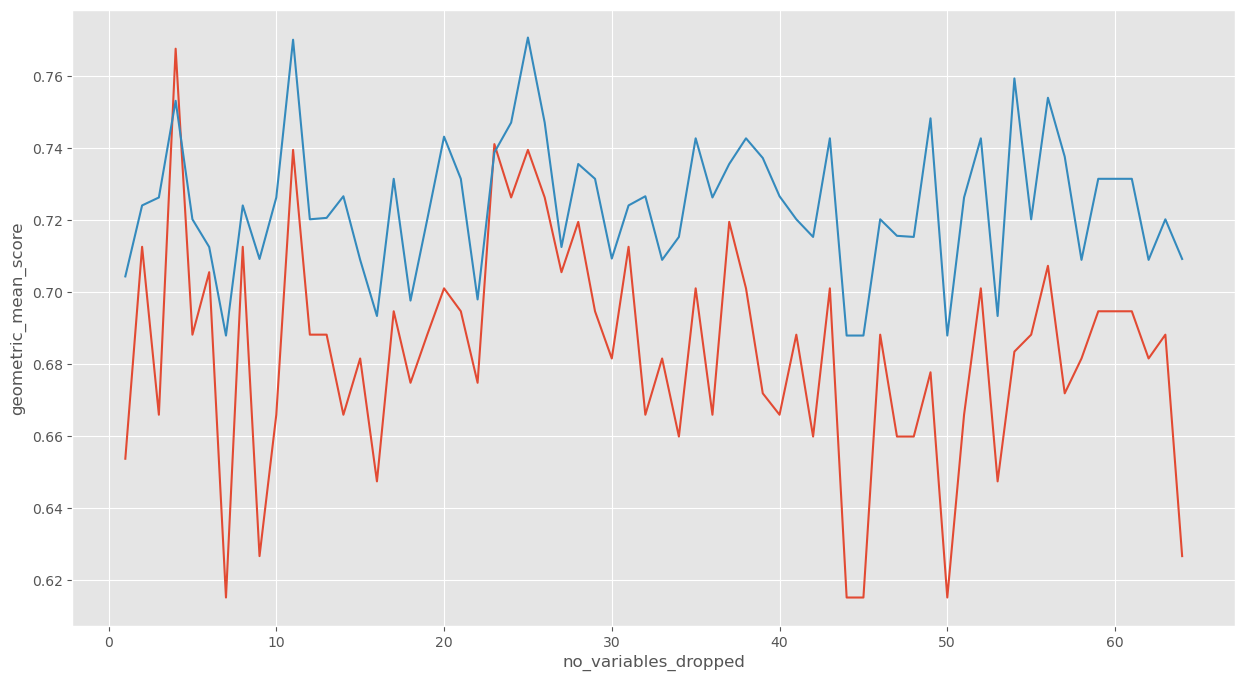

In [49]:
# plot the results

plt.figure(figsize=(15,8))

ax1 = sns.lineplot(x="no_variables_dropped", y="geometric_mean_score", data=score_array)
ax1 = sns.lineplot(x="no_variables_dropped", y="Weighted_F1_score", data=score_array)
ax2 = sns.lineplot(x="no_variables_dropped", y="mean", data=score_array,dashes="--")
ax1.set(xlabel='No. of variables dropped', ylabel='Scores')
plt.legend(labels=['Geometric Mean Score', 'Weighted F1 Score','Combined Average'])
plt.fill_between(score_array.no_variables_dropped, score_array.geometric_mean_score, score_array.Weighted_F1_score, alpha=0.2,facecolor='orange')

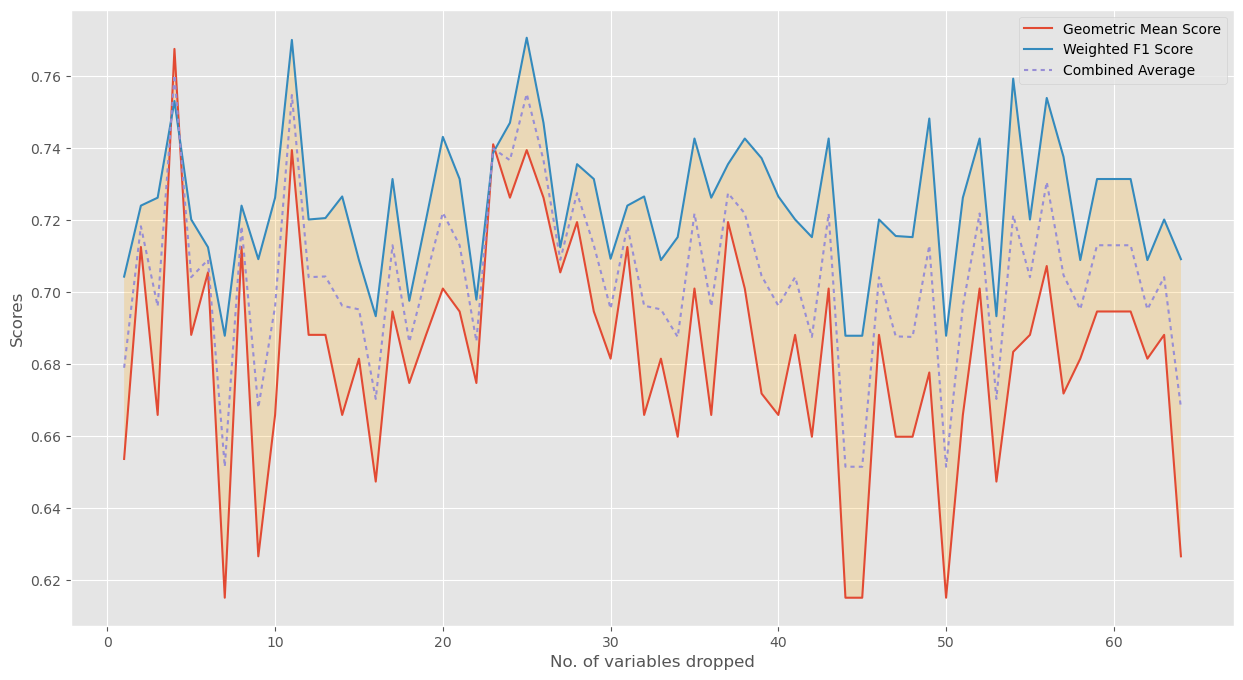

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming score_array is your DataFrame with columns: no_variables_dropped, geometric_mean_score, Weighted_F1_score, mean

plt.figure(figsize=(15, 8))

# Plot the Geometric Mean Score
ax1 = sns.lineplot(x="no_variables_dropped", y="geometric_mean_score", data=score_array, label='Geometric Mean Score')

# Plot the Weighted F1 Score
sns.lineplot(x="no_variables_dropped", y="Weighted_F1_score", data=score_array, label='Weighted F1 Score', ax=ax1)

# Plot the Combined Average (mean)
sns.lineplot(x="no_variables_dropped", y="mean", data=score_array, label='Combined Average', ax=ax1, dashes=(2, 2))

# Set labels and legend
ax1.set(xlabel='No. of variables dropped', ylabel='Scores')
plt.legend()

# Fill the area between Geometric Mean Score and Weighted F1 Score
plt.fill_between(score_array.no_variables_dropped, 
                 score_array.geometric_mean_score, 
                 score_array.Weighted_F1_score, 
                 alpha=0.2, facecolor='orange')

plt.show()


In [51]:
# extract details of the iteration that derived the best scores after pruning

score_array[score_array["mean"] == score_array["mean"].max()]

,no_variables_dropped,geometric_mean_score,Weighted_F1_score,mean
3,4,0.767515,0.753041,0.760278


In [52]:
# create a list to house all variables to be pruned

to_drop = feature_importance.sort_values(by = "var_impt", ascending=False)[-53:len(feature_importance)]

In [53]:
to_drop_list = to_drop.reset_index().iloc[:,1]

In [54]:
to_drop_list

0                 Males_FTime_31_48hrs
1                           Other_qual
2                             NS-SEC_4
3                               Muslim
4              Females_ptTime_16_30hrs
5                      central_heating
6                            age_50_54
7                           1_carsVans
8                         hse_detached
9                  tenure_rent_hsgAssc
10                               Hindu
11            1-family_married_depKids
12                         Pop_density
13                           eth_asian
14                      toWork_bicycle
15       toWork_underground_light_rail
16                           age_15_19
17                         No_religion
18                                Sikh
19                       tenure_shared
20                           age_60_64
21                             born_EU
22                         no_carsVans
23            Females_ptTime_less15hrs
24                              Jewish
25                       

In [55]:
# create a new dataframe for hosting variables after pruning

df_01_data_dropped = df_01_data[:]

In [56]:
df_01_data_dropped = df_01_data_dropped.drop(columns=to_drop_list)

In [57]:
df_01_data_dropped.head()

,Pop_size,avg_pop_churn,age_0_4,age_10_14,age_20_24,age_35_39,age_45_49,age_55_59,1-personHse_other,1-family_married_noKids,...,Lv1_qual,Lv2_qual,Lv3_qual,Lv4_qual,toWork_home,toWork_train,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan
117,-0.547038,-0.828705,-0.026616,1.248996,-0.286701,-0.489960,0.236264,-0.459302,-0.161472,-0.576754,...,0.766667,0.923077,0.125000,-0.580645,-0.286080,-0.412487,0.116914,-0.033778,-0.225338,0.342601
122,1.770035,-0.715757,0.901141,1.401606,0.186528,0.224900,0.060440,-0.668605,-0.185505,-0.278509,...,0.266667,0.442308,0.416667,-0.281106,-0.453053,-0.280013,0.575981,0.194933,-0.650903,0.224018
147,0.261324,0.353822,1.288973,1.935743,-0.010363,0.148594,-0.560440,-0.883721,-0.568532,-0.942982,...,0.700000,0.884615,0.458333,-0.534562,-0.579379,-0.255452,0.781938,-0.419310,0.153593,0.163076
149,-1.024390,0.594072,0.517110,0.333333,0.179620,0.313253,-0.208791,0.529070,0.123920,-0.489035,...,0.166667,0.403846,-0.416667,-0.405530,-0.702701,-0.214646,0.228585,-0.027419,0.150302,0.021470
184,0.557491,1.339158,1.566540,1.204819,0.887737,-0.273092,-0.439560,-0.808140,0.170484,-0.864035,...,0.666667,0.346154,0.041667,-0.423963,-0.659604,-0.376338,0.965619,-0.451696,-0.847051,0.017254


In [58]:
# split the dataset into training and test set again

x_train_dropped, x_test_dropped, y_train, y_test = train_test_split(df_01_data_dropped, df_01_labels, stratify = df_01_labels, test_size=0.3, random_state=42)

In [59]:
# test the perfomance of this model containing pruned variables

scores = cross_val_score(brf2, x_train_dropped, y_train.values.ravel(), cv=5, scoring = 'f1_weighted')
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
brf2 = brf2.fit(x_train_dropped, y_train.values.ravel())
y_pred = brf2.predict(x_test_dropped)
f1 = f1_score(y_test, y_pred, average="weighted")
print ('Wighted F1 score on Test set:', f1)

C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warni

mean validation - F1 Weighted score: F1 score: 0.76 (+/- 0.13)
building tree 1 of 230
building tree 2 of 230
building tree 4 of 230
building tree 5 of 230
building tree 7 of 230
building tree 3 of 230
building tree 6 of 230
building tree 9 of 230
building tree 8 of 230
building tree 10 of 230
building tree 13 of 230
building tree 15 of 230
building tree 14 of 230
building tree 16 of 230
building tree 11 of 230
building tree 12 of 230
building tree 18 of 230
building tree 20 of 230
building tree 22 of 230
building tree 21 of 230
building tree 17 of 230
building tree 19 of 230
building tree 25 of 230
building tree 28 of 230
building tree 23 of 230
building tree 27 of 230
building tree 26 of 230
building tree 29 of 230
building tree 24 of 230
building tree 30 of 230
building tree 31 of 230
building tree 33 of 230
building tree 34 of 230
building tree 32 of 230
building tree 36 of 230
building tree 37 of 230
building tree 35 of 230
building tree 39 of 230
building tree 42 of 230
building t

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 46 of 230
building tree 40 of 230
building tree 49 of 230
building tree 47 of 230
building tree 50 of 230
building tree 52 of 230
building tree 48 of 230
building tree 51 of 230
building tree 54 of 230
building tree 57 of 230
building tree 53 of 230
building tree 58 of 230
building tree 59 of 230
building tree 56 of 230
building tree 55 of 230
building tree 60 of 230
building tree 64 of 230
building tree 62 of 230
building tree 61 of 230
building tree 63 of 230
building tree 65 of 230
building tree 66 of 230
building tree 69 of 230
building tree 68 of 230
building tree 67 of 230
building tree 70 of 230
building tree 71 of 230
building tree 73 of 230
building tree 76 of 230
building tree 72 of 230
building tree 77 of 230
building tree 74 of 230
building tree 79 of 230
building tree 80 of 230
building tree 81 of 230
building tree 78 of 230
building tree 75 of 230
building tree 82 of 230
building tree 83 of 230
building tree 86 of 230
building tree 84 of 230
building tree 85

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 149 of 230building tree 151 of 230
building tree 144 of 230

building tree 152 of 230
building tree 146 of 230
building tree 156 of 230
building tree 150 of 230
building tree 153 of 230
building tree 155 of 230
building tree 154 of 230
building tree 157 of 230
building tree 160 of 230
building tree 162 of 230
building tree 159 of 230
building tree 158 of 230
building tree 163 of 230
building tree 161 of 230
building tree 167 of 230
building tree 164 of 230
building tree 169 of 230
building tree 171 of 230
building tree 165 of 230
building tree 168 of 230
building tree 166 of 230
building tree 173 of 230
building tree 170 of 230
building tree 172 of 230
building tree 176 of 230
building tree 174 of 230
building tree 177 of 230
building tree 178 of 230
building tree 182 of 230
building tree 175 of 230
building tree 179 of 230
building tree 184 of 230
building tree 181 of 230
building tree 188 of 230
building tree 186 of 230
building tree 180 of 230
building tree 187 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished


In [60]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(y_test.values.ravel(),y_pred)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.6473474510270238


In [61]:
unique_label = np.unique(y_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:MainGen  pred:MargGen  pred:SupGen
true:MainGen            12             0            0
true:MargGen             1             6            9
true:SupGen              2            11           34


<Axes: title={'center': 'Non-normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

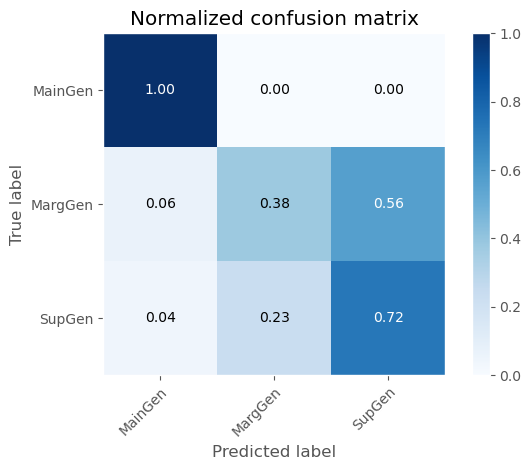

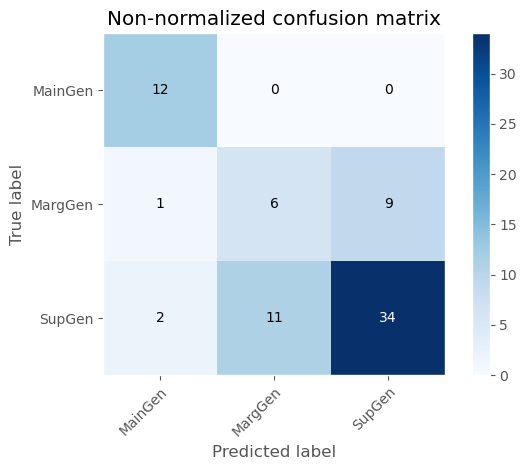

In [62]:
# plot a confusion matrix using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=["MainGen","MargGen","SupGen"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=["MainGen","MargGen","SupGen"], normalize=False,
                      title='Non-normalized confusion matrix')

In [63]:
# run model on the entire dataset

In [64]:
# model's performance on the entire dataset

y_pred_2001_all = brf2.predict(df_01_data_dropped)
f1 = f1_score(df_01_labels, y_pred_2001_all, average="weighted")
print ('Wighted F1 score on Test set:', f1)

Wighted F1 score on Test set: 0.874287453216272


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished


In [65]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(df_01_labels.values.ravel(),y_pred_2001_all)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.8852692562777006


In [66]:
unique_label = np.unique(df_01_labels)
print(pd.DataFrame(confusion_matrix(df_01_labels, y_pred_2001_all, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:MainGen  pred:MargGen  pred:SupGen
true:MainGen            42             0            0
true:MargGen             1            42            9
true:SupGen              3            19          134


<Axes: title={'center': 'Non-normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

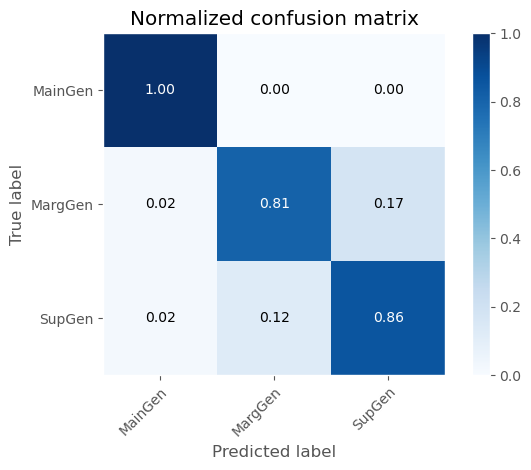

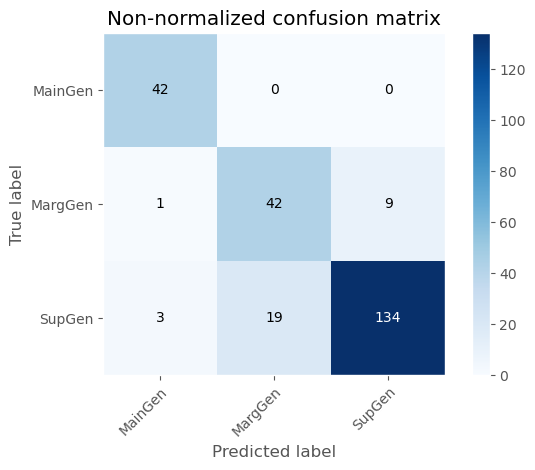

In [67]:
# plot a confusion matrix using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_2001_all, classes=["MainGen","MargGen","SupGen"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_2001_all, classes=["MainGen","MargGen","SupGen"], normalize=False,
                      title='Non-normalized confusion matrix')

In [68]:
# read in original file and append the predictions

df_pred_all = pd.read_csv("df_modelling_std_01_labels.csv").drop(columns=["Unnamed: 0"])

In [69]:
df_pred_all = df_pred_all[df_pred_all["GEN_Class3"] != "NON-GEN"]

In [70]:
df_pred_all["predictions"] = y_pred_2001_all

In [71]:
df_pred_all.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,...,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,Class_2_status,Class_3_status,GEN_Class2,GEN_Class3,predictions
117,E01000121,-0.547038,-0.828705,-0.026616,1.000000,1.248996,1.362205,-0.286701,-0.731574,-0.837054,...,0.342601,0.667757,-0.488036,-0.561064,0.843292,GEN,SupGen,GEN,SupGen,SupGen
122,E01000126,1.770035,-0.715757,0.901141,0.860987,1.401606,1.354331,0.186528,-0.191083,-0.066964,...,0.224018,0.005096,-0.488184,-0.425226,0.179252,GEN,SupGen,GEN,SupGen,SupGen
147,E01000152,0.261324,0.353822,1.288973,2.201794,1.935743,1.535433,-0.010363,-0.393085,-0.609375,...,0.163076,-0.101262,-0.431432,-0.277425,2.372262,GEN,MargGen,GEN,MargGen,MargGen
149,E01000154,-1.024390,0.594072,0.517110,1.103139,0.333333,0.047244,0.179620,-0.036397,-0.075893,...,0.021470,0.015681,-0.450296,-0.209442,-0.339874,GEN,MargGen,GEN,MargGen,MargGen
184,E01000189,0.557491,1.339158,1.566540,0.641256,1.204819,0.901575,0.887737,-0.111010,-0.046875,...,0.017254,0.707088,-0.445188,-0.265877,1.372387,GEN,MargGen,GEN,MargGen,MargGen


In [72]:
df_pred_all = df_pred_all.reset_index()

In [73]:
# categorising the predictions:
# 'Accu' means accurate predictions
# 'Main-Marg' refers to instances where the real category is MainGen but the predicted value is MargGen
# 'Main-Sup' refers to instances where the real category is MainGen but the predicted value is SupGen
# 'Marg-Main' refers to instances where the real category is MargGen but the predicted value is MainGen
# 'Marg-Sup' refers to instances where the real category is MargGen but the predicted value is SupGen
# 'Sup-Main' refers to instances where the real category is SupGen but the predicted value is MainGen
# 'Sup-Marg' refers to instances where the real category is SupGen but the predicted value is MargGen

df_pred_all["pred_cat"] = "Accu"

for i in range(len(df_pred_all)):
    if df_pred_all.loc[i,"GEN_Class3"] == "MainGen" and df_pred_all.loc[i,"predictions"] == "MargGen":
        df_pred_all.loc[i, "pred_cat"] = "Main-Marg"
    elif df_pred_all.loc[i,"GEN_Class3"] == "MainGen" and df_pred_all.loc[i,"predictions"] == "SupGen":
        df_pred_all.loc[i, "pred_cat"] = "Main-Sup"
    elif df_pred_all.loc[i,"GEN_Class3"] == "MargGen" and df_pred_all.loc[i,"predictions"] == "MainGen":
        df_pred_all.loc[i, "pred_cat"] = "Marg-Main"  
    elif df_pred_all.loc[i,"GEN_Class3"] == "MargGen" and df_pred_all.loc[i,"predictions"] == "SupGen":
        df_pred_all.loc[i, "pred_cat"] = "Marg-Sup"         
    elif df_pred_all.loc[i,"GEN_Class3"] == "SupGen" and df_pred_all.loc[i,"predictions"] == "MainGen":
        df_pred_all.loc[i, "pred_cat"] = "Sup-Main"          
    elif df_pred_all.loc[i,"GEN_Class3"] == "SupGen" and df_pred_all.loc[i,"predictions"] == "MargGen":
        df_pred_all.loc[i, "pred_cat"] = "Sup-Marg"

In [74]:
df_pred_all.head()

,index,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,...,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,Class_2_status,Class_3_status,GEN_Class2,GEN_Class3,predictions,pred_cat
0,117,E01000121,-0.547038,-0.828705,-0.026616,1.000000,1.248996,1.362205,-0.286701,-0.731574,...,0.667757,-0.488036,-0.561064,0.843292,GEN,SupGen,GEN,SupGen,SupGen,Accu
1,122,E01000126,1.770035,-0.715757,0.901141,0.860987,1.401606,1.354331,0.186528,-0.191083,...,0.005096,-0.488184,-0.425226,0.179252,GEN,SupGen,GEN,SupGen,SupGen,Accu
2,147,E01000152,0.261324,0.353822,1.288973,2.201794,1.935743,1.535433,-0.010363,-0.393085,...,-0.101262,-0.431432,-0.277425,2.372262,GEN,MargGen,GEN,MargGen,MargGen,Accu
3,149,E01000154,-1.024390,0.594072,0.517110,1.103139,0.333333,0.047244,0.179620,-0.036397,...,0.015681,-0.450296,-0.209442,-0.339874,GEN,MargGen,GEN,MargGen,MargGen,Accu
4,184,E01000189,0.557491,1.339158,1.566540,0.641256,1.204819,0.901575,0.887737,-0.111010,...,0.707088,-0.445188,-0.265877,1.372387,GEN,MargGen,GEN,MargGen,MargGen,Accu


In [75]:
# checkpoint - output file
# df_pred_all.to_csv("df_pred_all_modelling2.csv")

## Adding Geographic Covariate 1 - Proximity to London's inner boroughs

In [78]:
# read in dataset consisting the proximal distances between each LSOA and the boundaries of inner boroughs

proximity_innerBor = pd.read_csv("proximity_innerBoroughs_modelling2.csv")

In [79]:
proximity_innerBor.head()

,LSOA11CD,LSOA11NM,LAD11CD,LAD11NM,Proximity_to_InnerBoroughs
0,E01000001,City of London 001A,E09000001,City of London,0.000000
1,E01000002,City of London 001B,E09000001,City of London,0.000000
2,E01000003,City of London 001C,E09000001,City of London,0.000000
3,E01000005,City of London 001E,E09000001,City of London,0.000000
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,1059.179475


In [80]:
# read in original dataset

df_01_lsoa = pd.read_csv("df_modelling_std_01_labels.csv").drop(columns=["Unnamed: 0"])

In [81]:
# remove non-essential variables at this stage

df_01_lsoa = df_01_lsoa[df_01_lsoa["GEN_Class3"] != "NON-GEN"]

In [82]:
# attach the 1st geog covariate to the original dataset

df_01_lsoa = df_01_lsoa.drop(columns=["Class_2_status","Class_3_status","GEN_Class2","GEN_Class3"])

In [83]:
# create a new dataset which geog covariate 2 can be appended onto later

df_01_geogco = df_01_lsoa.merge(proximity_innerBor[["Proximity_to_InnerBoroughs","LSOA11CD"]], left_on="LSOA11CD", right_on="LSOA11CD")

In [84]:
# prepping the dataset with geog covariate 1 to be modelled and tested

df_01_geogco2 = df_01_geogco[:]

In [85]:
df_01_geogco = df_01_geogco.drop(columns = "LSOA11CD")

In [86]:
df_01_geogco = df_01_geogco.drop(columns=to_drop_list)

In [87]:
df_01_geogco.head()

,Pop_size,avg_pop_churn,age_0_4,age_10_14,age_20_24,age_35_39,age_45_49,age_55_59,1-personHse_other,1-family_married_noKids,...,Lv2_qual,Lv3_qual,Lv4_qual,toWork_home,toWork_train,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,Proximity_to_InnerBoroughs
0,-0.547038,-0.828705,-0.026616,1.248996,-0.286701,-0.489960,0.236264,-0.459302,-0.161472,-0.576754,...,0.923077,0.125000,-0.580645,-0.286080,-0.412487,0.116914,-0.033778,-0.225338,0.342601,1471.672997
1,1.770035,-0.715757,0.901141,1.401606,0.186528,0.224900,0.060440,-0.668605,-0.185505,-0.278509,...,0.442308,0.416667,-0.281106,-0.453053,-0.280013,0.575981,0.194933,-0.650903,0.224018,5413.185305
2,0.261324,0.353822,1.288973,1.935743,-0.010363,0.148594,-0.560440,-0.883721,-0.568532,-0.942982,...,0.884615,0.458333,-0.534562,-0.579379,-0.255452,0.781938,-0.419310,0.153593,0.163076,5320.458983
3,-1.024390,0.594072,0.517110,0.333333,0.179620,0.313253,-0.208791,0.529070,0.123920,-0.489035,...,0.403846,-0.416667,-0.405530,-0.702701,-0.214646,0.228585,-0.027419,0.150302,0.021470,4995.244427
4,0.557491,1.339158,1.566540,1.204819,0.887737,-0.273092,-0.439560,-0.808140,0.170484,-0.864035,...,0.346154,0.041667,-0.423963,-0.659604,-0.376338,0.965619,-0.451696,-0.847051,0.017254,8706.604818


In [88]:
# test the performance of this model with geog covariate 1

scores = cross_val_score(brf2, df_01_geogco, df_01_labels.values.ravel(), cv=5, scoring = 'f1_weighted')
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
brf2 = brf2.fit(df_01_geogco, df_01_labels.values.ravel())
y_pred_geogco = brf2.predict(df_01_geogco)
f1 = f1_score(df_01_labels, y_pred_geogco, average="weighted")
print ('Wighted F1 score on Test set:', f1)

C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warni

mean validation - F1 Weighted score: F1 score: 0.73 (+/- 0.08)
building tree 1 of 230
building tree 3 of 230
building tree 4 of 230
building tree 9 of 230
building tree 6 of 230
building tree 2 of 230
building tree 5 of 230
building tree 8 of 230
building tree 10 of 230
building tree 11 of 230
building tree 7 of 230
building tree 13 of 230
building tree 14 of 230
building tree 12 of 230
building tree 16 of 230
building tree 15 of 230
building tree 17 of 230
building tree 20 of 230
building tree 22 of 230
building tree 21 of 230
building tree 24 of 230
building tree 19 of 230
building tree 23 of 230
building tree 18 of 230
building tree 25 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 32 of 230
building tree 30 of 230
building tree 31 of 230
building tree 33 of 230
building tree 34 of 230
building tree 29 of 230
building tree 36 of 230
building tree 37 of 230
building tree 43 of 230
building tree 41 of 230
building tree 39 of 230
building t

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 35 of 230
building tree 40 of 230
building tree 47 of 230
building tree 45 of 230
building tree 46 of 230
building tree 50 of 230
building tree 44 of 230
building tree 49 of 230
building tree 48 of 230
building tree 53 of 230
building tree 55 of 230
building tree 54 of 230
building tree 52 of 230
building tree 51 of 230
building tree 56 of 230
building tree 57 of 230
building tree 60 of 230
building tree 58 of 230
building tree 62 of 230
building tree 61 of 230
building tree 59 of 230
building tree 64 of 230
building tree 65 of 230
building tree 63 of 230
building tree 67 of 230
building tree 69 of 230
building tree 70 of 230
building tree 66 of 230
building tree 68 of 230
building tree 75 of 230
building tree 73 of 230
building tree 76 of 230
building tree 72 of 230
building tree 71 of 230
building tree 79 of 230
building tree 78 of 230
building tree 77 of 230
building tree 82 of 230
building tree 81 of 230
building tree 80 of 230
building tree 83 of 230
building tree 74

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 136 of 230
building tree 135 of 230
building tree 132 of 230
building tree 133 of 230
building tree 134 of 230
building tree 137 of 230
building tree 140 of 230
building tree 138 of 230
building tree 143 of 230
building tree 144 of 230
building tree 142 of 230
building tree 141 of 230
building tree 145 of 230
building tree 139 of 230
building tree 147 of 230
building tree 148 of 230
building tree 153 of 230
building tree 150 of 230
building tree 149 of 230
building tree 152 of 230
building tree 151 of 230
building tree 146 of 230
building tree 154 of 230
building tree 155 of 230
building tree 157 of 230
building tree 161 of 230
building tree 156 of 230
building tree 158 of 230
building tree 159 of 230
building tree 160 of 230
building tree 165 of 230
building tree 167 of 230
building tree 163 of 230
building tree 162 of 230
building tree 166 of 230
building tree 169 of 230
building tree 170 of 230
building tree 171 of 230
building tree 168 of 230
building tree 174 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished


In [89]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(df_01_labels.values.ravel(),y_pred_geogco)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.9552963168813977


In [90]:
unique_label = np.unique(df_01_labels)
print(pd.DataFrame(confusion_matrix(df_01_labels, y_pred_geogco, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:MainGen  pred:MargGen  pred:SupGen
true:MainGen            42             0            0
true:MargGen             0            52            0
true:SupGen              5            15          136


<Axes: title={'center': 'Non-normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

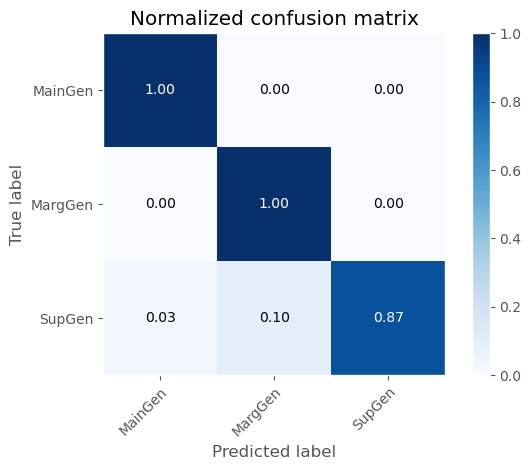

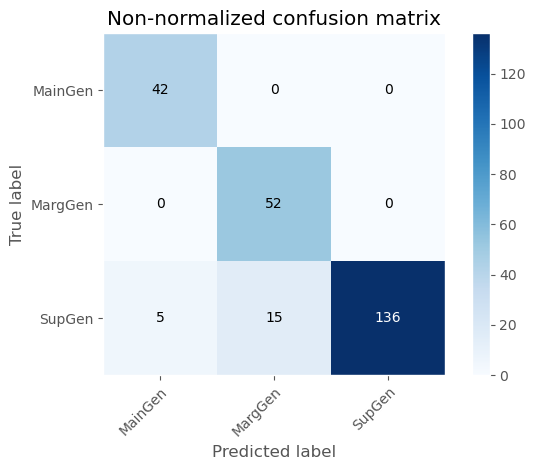

In [91]:
# plot a confusion matrix using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_geogco, classes=["MainGen","MargGen","SupGen"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_geogco, classes=["MainGen","MargGen","SupGen"], normalize=False,
                      title='Non-normalized confusion matrix')

## Adding Geographic Covariate 2 - Summed PC1 scores across all neighbourhing LSOAs under a queen's contiguity matrix

In [94]:
# read in relevant dataset

neighbour_pca_scores = pd.read_csv("df_neighbours_pca_01_modelling.csv").drop(columns="Unnamed: 0")

In [95]:
neighbour_pca_scores.head()

,LSOA11CD,PCA_score_nbr
0,E01000001,2.354388
1,E01000002,2.479326
2,E01000003,0.634527
3,E01000005,-0.537932
4,E01000006,-1.117856


In [96]:
df_01_geogco2.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,...,toWork_train,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,Proximity_to_InnerBoroughs
0,E01000121,-0.547038,-0.828705,-0.026616,1.000000,1.248996,1.362205,-0.286701,-0.731574,-0.837054,...,-0.412487,0.116914,-0.033778,-0.225338,0.342601,0.667757,-0.488036,-0.561064,0.843292,1471.672997
1,E01000126,1.770035,-0.715757,0.901141,0.860987,1.401606,1.354331,0.186528,-0.191083,-0.066964,...,-0.280013,0.575981,0.194933,-0.650903,0.224018,0.005096,-0.488184,-0.425226,0.179252,5413.185305
2,E01000152,0.261324,0.353822,1.288973,2.201794,1.935743,1.535433,-0.010363,-0.393085,-0.609375,...,-0.255452,0.781938,-0.419310,0.153593,0.163076,-0.101262,-0.431432,-0.277425,2.372262,5320.458983
3,E01000154,-1.024390,0.594072,0.517110,1.103139,0.333333,0.047244,0.179620,-0.036397,-0.075893,...,-0.214646,0.228585,-0.027419,0.150302,0.021470,0.015681,-0.450296,-0.209442,-0.339874,4995.244427
4,E01000189,0.557491,1.339158,1.566540,0.641256,1.204819,0.901575,0.887737,-0.111010,-0.046875,...,-0.376338,0.965619,-0.451696,-0.847051,0.017254,0.707088,-0.445188,-0.265877,1.372387,8706.604818


In [97]:
# merge the original dataset with geog covariate 2

df_01_geogco2 = df_01_geogco2.merge(neighbour_pca_scores[["LSOA11CD","PCA_score_nbr"]], left_on="LSOA11CD", right_on="LSOA11CD")

In [98]:
df_01_geogco2 = df_01_geogco2.drop(columns = "LSOA11CD")

In [99]:
df_01_geogco2 = df_01_geogco2.drop(columns=to_drop_list)

In [100]:
df_01_geogco2.head()

,Pop_size,avg_pop_churn,age_0_4,age_10_14,age_20_24,age_35_39,age_45_49,age_55_59,1-personHse_other,1-family_married_noKids,...,Lv3_qual,Lv4_qual,toWork_home,toWork_train,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,Proximity_to_InnerBoroughs,PCA_score_nbr
0,-0.547038,-0.828705,-0.026616,1.248996,-0.286701,-0.489960,0.236264,-0.459302,-0.161472,-0.576754,...,0.125000,-0.580645,-0.286080,-0.412487,0.116914,-0.033778,-0.225338,0.342601,1471.672997,-1.656521
1,1.770035,-0.715757,0.901141,1.401606,0.186528,0.224900,0.060440,-0.668605,-0.185505,-0.278509,...,0.416667,-0.281106,-0.453053,-0.280013,0.575981,0.194933,-0.650903,0.224018,5413.185305,-1.728011
2,0.261324,0.353822,1.288973,1.935743,-0.010363,0.148594,-0.560440,-0.883721,-0.568532,-0.942982,...,0.458333,-0.534562,-0.579379,-0.255452,0.781938,-0.419310,0.153593,0.163076,5320.458983,-1.854426
3,-1.024390,0.594072,0.517110,0.333333,0.179620,0.313253,-0.208791,0.529070,0.123920,-0.489035,...,-0.416667,-0.405530,-0.702701,-0.214646,0.228585,-0.027419,0.150302,0.021470,4995.244427,-1.758481
4,0.557491,1.339158,1.566540,1.204819,0.887737,-0.273092,-0.439560,-0.808140,0.170484,-0.864035,...,0.041667,-0.423963,-0.659604,-0.376338,0.965619,-0.451696,-0.847051,0.017254,8706.604818,-1.570620


In [101]:
# test the performance of the model with both geog covariates

scores = cross_val_score(brf2, df_01_geogco2, df_01_labels.values.ravel(), cv=5, scoring = 'f1_weighted')
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
brf2 = brf2.fit(df_01_geogco2, df_01_labels.values.ravel())
y_pred_geogco2 = brf2.predict(df_01_geogco2)
f1 = f1_score(df_01_labels, y_pred_geogco2, average="weighted")
print ('Wighted F1 score on Test set:', f1)

C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\apple\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warni

mean validation - F1 Weighted score: F1 score: 0.72 (+/- 0.07)
building tree 3 of 230
building tree 2 of 230
building tree 4 of 230
building tree 8 of 230
building tree 6 of 230
building tree 1 of 230
building tree 9 of 230
building tree 7 of 230
building tree 5 of 230
building tree 11 of 230
building tree 10 of 230
building tree 13 of 230
building tree 12 of 230
building tree 15 of 230
building tree 17 of 230
building tree 14 of 230
building tree 19 of 230
building tree 18 of 230
building tree 16 of 230
building tree 22 of 230
building tree 20 of 230
building tree 25 of 230
building tree 21 of 230
building tree 27 of 230
building tree 23 of 230
building tree 26 of 230
building tree 24 of 230
building tree 30 of 230
building tree 28 of 230
building tree 31 of 230
building tree 33 of 230
building tree 32 of 230
building tree 29 of 230
building tree 36 of 230
building tree 34 of 230
building tree 38 of 230
building tree 35 of 230
building tree 40 of 230
building tree 42 of 230
building t

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


building tree 41 of 230
building tree 44 of 230
building tree 51 of 230
building tree 46 of 230
building tree 50 of 230
building tree 52 of 230
building tree 53 of 230
building tree 47 of 230
building tree 49 of 230
building tree 48 of 230
building tree 54 of 230
building tree 57 of 230
building tree 60 of 230
building tree 58 of 230
building tree 59 of 230
building tree 56 of 230
building tree 55 of 230
building tree 62 of 230
building tree 61 of 230
building tree 63 of 230
building tree 64 of 230
building tree 65 of 230
building tree 69 of 230
building tree 67 of 230
building tree 68 of 230
building tree 66 of 230
building tree 70 of 230
building tree 71 of 230
building tree 73 of 230
building tree 72 of 230
building tree 78 of 230
building tree 76 of 230
building tree 75 of 230
building tree 77 of 230
building tree 74 of 230
building tree 79 of 230
building tree 80 of 230
building tree 82 of 230
building tree 83 of 230
building tree 81 of 230
building tree 86 of 230
building tree 84

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s


building tree 141 of 230
building tree 148 of 230
building tree 152 of 230
building tree 150 of 230
building tree 151 of 230
building tree 153 of 230
building tree 155 of 230
building tree 154 of 230
building tree 158 of 230
building tree 156 of 230
building tree 159 of 230
building tree 160 of 230
building tree 162 of 230
building tree 164 of 230
building tree 161 of 230
building tree 157 of 230
building tree 163 of 230
building tree 165 of 230
building tree 167 of 230
building tree 168 of 230
building tree 171 of 230
building tree 170 of 230
building tree 172 of 230
building tree 166 of 230
building tree 169 of 230
building tree 174 of 230
building tree 173 of 230
building tree 175 of 230
building tree 180 of 230
building tree 179 of 230
building tree 176 of 230
building tree 178 of 230
building tree 177 of 230
building tree 181 of 230
building tree 184 of 230
building tree 186 of 230
building tree 182 of 230
building tree 189 of 230
building tree 187 of 230
building tree 183 of 230


[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished


In [102]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(df_01_labels.values.ravel(),y_pred_geogco2)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.959956372661254


In [103]:
unique_label = np.unique(df_01_labels)
print(pd.DataFrame(confusion_matrix(df_01_labels, y_pred_geogco2, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:MainGen  pred:MargGen  pred:SupGen
true:MainGen            42             0            0
true:MargGen             0            52            0
true:SupGen              6            12          138


<Axes: title={'center': 'Non-normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

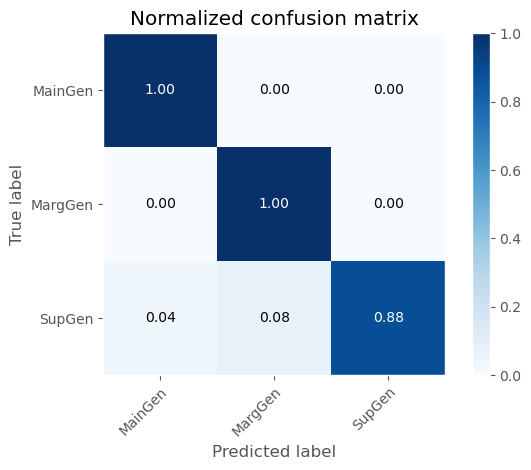

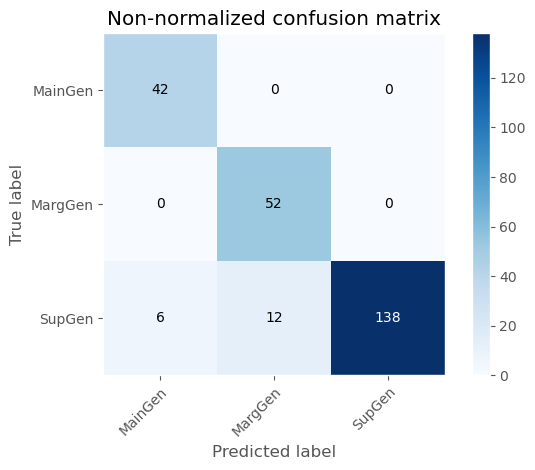

In [104]:
# plot a confusion matrix using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_geogco2, classes=["MainGen","MargGen","SupGen"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_geogco2, classes=["MainGen","MargGen","SupGen"], normalize=False,
                      title='Non-normalized confusion matrix')

## Predict Future Trends with 2011-2016 Data

In [105]:
# read in relevant dataset

df_11_pred = pd.read_csv("predictions_modelling1.csv").drop(columns="Unnamed: 0")

In [106]:
df_11_pred.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,...,toWork_train,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,predictions
0,E01000001,-0.646753,0.634259,-1.140,-1.810474,-1.733333,-1.726651,0.050193,0.719540,0.114504,...,-0.857143,-0.250000,-0.482143,-0.886919,-0.823899,0.145695,2.099398,-1.112676,-1.409938,NON-GEN
1,E01000002,-0.911688,1.189815,-1.660,-2.159601,-1.986667,-1.444191,0.478764,1.002299,0.320611,...,-0.815560,-0.522727,-0.910714,-0.884044,-0.610063,0.162252,1.466867,-0.802817,-1.472050,NON-GEN
2,E01000003,-0.301299,0.349537,-1.655,-1.910224,-1.786667,-1.785877,-0.046332,0.898851,0.465649,...,-0.697518,-0.136364,-0.392857,-0.858649,-0.383648,1.264901,2.662651,0.633803,-0.747412,NON-GEN
3,E01000005,-1.649351,0.412037,-0.615,-0.987531,-1.275556,1.261959,1.833977,0.250575,0.587786,...,0.169014,-0.136364,-0.392857,-0.678965,-0.698113,0.556291,3.737952,0.661972,0.473085,NON-GEN
4,E01000006,0.272727,-0.004630,1.270,0.458853,-0.035556,0.615034,0.266409,-0.133333,0.274809,...,-0.136821,-0.795455,0.107143,0.232391,-0.113208,-0.549669,0.364458,1.084507,0.481366,NON-GEN


In [107]:
df_11_pred_GEN = df_11_pred[df_11_pred["predictions"] == "GEN"]

In [108]:
# merge geog covariate 1

df_11_pred_GEN = df_11_pred_GEN.merge(proximity_innerBor[["Proximity_to_InnerBoroughs","LSOA11CD"]], left_on="LSOA11CD", right_on="LSOA11CD")

In [109]:
# merge geog covariate 2

df_11_pred_GEN = df_11_pred_GEN.merge(neighbour_pca_scores[["LSOA11CD","PCA_score_nbr"]], left_on="LSOA11CD", right_on="LSOA11CD")

In [110]:
df_11_pred_modelling2 = df_11_pred_GEN.drop(columns=["LSOA11CD","predictions"])

In [111]:
# removed pruned variables

df_11_pred_modelling2 = df_11_pred_modelling2.drop(columns=to_drop_list)

In [112]:
df_11_pred_modelling2.head()

,Pop_size,avg_pop_churn,age_0_4,age_10_14,age_20_24,age_35_39,age_45_49,age_55_59,1-personHse_other,1-family_married_noKids,...,Lv3_qual,Lv4_qual,toWork_home,toWork_train,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,Proximity_to_InnerBoroughs,PCA_score_nbr
0,0.290909,-0.620370,0.360,0.991111,0.027027,-0.177489,0.062069,0.206704,-0.575499,0.055172,...,0.540865,-0.584615,0.836458,0.323273,0.522727,-0.071429,0.699090,0.849057,4480.068056,-1.907507
1,0.106494,-0.215278,0.380,0.813333,0.077220,-0.116883,0.675862,0.256983,-0.028490,-0.077241,...,-0.478365,-0.442308,1.424693,-0.001341,-0.772727,0.821429,0.598467,1.427673,4394.396599,-1.817103
2,0.381818,-0.671296,1.630,0.262222,-0.015444,0.632035,0.668966,-0.569832,-0.308506,-0.833103,...,-0.540865,-0.761538,1.511312,0.140845,0.500000,-0.142857,0.399617,0.798742,963.015481,-1.769335
3,0.561039,-0.291667,0.905,0.977778,0.100386,-0.203463,0.234483,-0.810056,-0.402930,-0.322759,...,0.552885,-0.546154,1.500970,0.052314,0.022727,0.982143,0.684715,0.572327,2017.442755,-1.881934
4,-0.496104,-0.418981,0.545,1.342222,-0.362934,0.025974,0.496552,-0.363128,-0.685389,-0.245517,...,-0.262019,-0.380769,1.780220,0.029510,1.750000,-0.285714,0.502156,1.012579,2320.997431,-1.794484


In [113]:
# predict labels

y_pred_modelling2_2011 = brf2.predict(df_11_pred_modelling2)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 230 out of 230 | elapsed:    0.0s finished


In [114]:
# append the predictions with the original dataset

df_11_pred_GEN["predictions_modelling2"] = y_pred_modelling2_2011

In [115]:
df_11_pred_GEN.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,...,toWork_carVan,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,predictions,Proximity_to_InnerBoroughs,PCA_score_nbr,predictions_modelling2
0,E01000016,0.290909,-0.620370,0.360,1.012469,0.991111,1.025057,0.027027,-0.039080,-0.175573,...,0.699090,0.849057,-0.314570,0.283133,1.169014,0.655280,GEN,4480.068056,-1.907507,SupGen
1,E01000018,0.106494,-0.215278,0.380,0.862843,0.813333,0.751708,0.077220,-0.190805,-0.195929,...,0.598467,1.427673,-0.417219,0.165663,0.408451,0.914079,GEN,4394.396599,-1.817103,SupGen
2,E01000040,0.381818,-0.671296,1.630,0.967581,0.262222,1.712984,-0.015444,-0.425287,-0.348601,...,0.399617,0.798742,-0.728477,-0.189759,-0.647887,1.521739,GEN,963.015481,-1.769335,SupGen
3,E01000046,0.561039,-0.291667,0.905,1.107232,0.977778,0.792711,0.100386,0.080460,-0.320611,...,0.684715,0.572327,-0.155629,-0.159639,-0.788732,0.828157,GEN,2017.442755,-1.881934,SupGen
4,E01000057,-0.496104,-0.418981,0.545,0.992519,1.342222,0.993166,-0.362934,-0.133333,-0.267176,...,0.502156,1.012579,-0.317881,0.009036,-0.084507,0.898551,GEN,2320.997431,-1.794484,SupGen


In [116]:
df_11_pred = df_11_pred.merge(df_11_pred_GEN[["LSOA11CD","predictions_modelling2"]], left_on="LSOA11CD", right_on="LSOA11CD", how="left")

In [117]:
df_11_pred.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,...,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,predictions,predictions_modelling2
0,E01000001,-0.646753,0.634259,-1.140,-1.810474,-1.733333,-1.726651,0.050193,0.719540,0.114504,...,-0.250000,-0.482143,-0.886919,-0.823899,0.145695,2.099398,-1.112676,-1.409938,NON-GEN,NaN
1,E01000002,-0.911688,1.189815,-1.660,-2.159601,-1.986667,-1.444191,0.478764,1.002299,0.320611,...,-0.522727,-0.910714,-0.884044,-0.610063,0.162252,1.466867,-0.802817,-1.472050,NON-GEN,NaN
2,E01000003,-0.301299,0.349537,-1.655,-1.910224,-1.786667,-1.785877,-0.046332,0.898851,0.465649,...,-0.136364,-0.392857,-0.858649,-0.383648,1.264901,2.662651,0.633803,-0.747412,NON-GEN,NaN
3,E01000005,-1.649351,0.412037,-0.615,-0.987531,-1.275556,1.261959,1.833977,0.250575,0.587786,...,-0.136364,-0.392857,-0.678965,-0.698113,0.556291,3.737952,0.661972,0.473085,NON-GEN,NaN
4,E01000006,0.272727,-0.004630,1.270,0.458853,-0.035556,0.615034,0.266409,-0.133333,0.274809,...,-0.795455,0.107143,0.232391,-0.113208,-0.549669,0.364458,1.084507,0.481366,NON-GEN,NaN


In [118]:
# label non-gentrifying LSOAs accordingly

for i in range(len(df_11_pred)):
    if pd.isna(df_11_pred.loc[i,"predictions_modelling2"]) == True:
        df_11_pred.loc[i,"predictions_modelling2"] = "NON-GEN"

In [119]:
df_11_pred.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,...,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,predictions,predictions_modelling2
0,E01000001,-0.646753,0.634259,-1.140,-1.810474,-1.733333,-1.726651,0.050193,0.719540,0.114504,...,-0.250000,-0.482143,-0.886919,-0.823899,0.145695,2.099398,-1.112676,-1.409938,NON-GEN,NON-GEN
1,E01000002,-0.911688,1.189815,-1.660,-2.159601,-1.986667,-1.444191,0.478764,1.002299,0.320611,...,-0.522727,-0.910714,-0.884044,-0.610063,0.162252,1.466867,-0.802817,-1.472050,NON-GEN,NON-GEN
2,E01000003,-0.301299,0.349537,-1.655,-1.910224,-1.786667,-1.785877,-0.046332,0.898851,0.465649,...,-0.136364,-0.392857,-0.858649,-0.383648,1.264901,2.662651,0.633803,-0.747412,NON-GEN,NON-GEN
3,E01000005,-1.649351,0.412037,-0.615,-0.987531,-1.275556,1.261959,1.833977,0.250575,0.587786,...,-0.136364,-0.392857,-0.678965,-0.698113,0.556291,3.737952,0.661972,0.473085,NON-GEN,NON-GEN
4,E01000006,0.272727,-0.004630,1.270,0.458853,-0.035556,0.615034,0.266409,-0.133333,0.274809,...,-0.795455,0.107143,0.232391,-0.113208,-0.549669,0.364458,1.084507,0.481366,NON-GEN,NON-GEN


In [120]:
# check the breakdown

df_11_pred.groupby("predictions_modelling2").size()

predictions_modelling2
MainGen      22
MargGen      28
NON-GEN    4450
SupGen      335
dtype: int64

In [121]:
# checkpoint - output file
df_11_pred.to_csv("predictions_GEN_modelling2.csv")